# Model & tools

Here is the code for all of the functions and classes used in simulations and analysis of the results. The code is identical to the one found in "model_tools.py".

<div id="toc"></div>

In [11]:
import random
import numpy as np
import itertools

from scipy import stats as st 
from pandas import DataFrame as DF
from pandas import HDFStore as HDF
import matplotlib.pyplot as plt

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')
// https://github.com/kmahelona/ipython_notebook_goodies          ...interactive table of contents

<IPython.core.display.Javascript object>

In [13]:
## command line code for making JUPYTER code cells collapsible
#  pip install nbextension-cellfolding
#  jupyter nbextension install --py cellfolding --user
#  jupyter nbextension enable --py cellfolding --user 

## parameters

In [14]:
 # parameters
# overall
no_countries = 2
ns = [5000,5000]              # no HSHs
ms = [550,550]                # no firms
global_bank = False           # just one bank for the whole world?

# HSHs
wage_resist = [12]*no_countries  # wage resistance in unemployment; 12 in baseline, 8 in alternative
wage_flex = [0.05]*no_countries  # wage flexibility;                0.05 in baseline, 0.08 or 0.25 in alternative
prop_to_save_O = 0.15        # optimistic saving target
prop_to_save_P = 0.2         # pessimistic saving target
cons_of_excess_savings = 0.5 # rate of cons. of excess savings
l_providers = 10             # number of firms to be considered on labor market 

# firms
K = 10                # no of machines
productivity = 100    # machine productivity

production_time = 8           # length of production
inv_normal = 2                # periods of full prod. for targeted inventories
price_flex = 0.05             # adjustment parameter
#d_p = random.randrange(1,4)  # price rigidity;  for a firm, drawn after each price change 
targeted_vacancies = 0.03     # targeted vacancies 
#d_w_e = random.randrange(6,18) # length of employment constracts - drawn for each new contract separately
mu_F = 0.5                    # goods to be sold
capital_normal_ratio = 0.2    # optimisstic targeted net wealth
capital_high_ratio = 0.5      # pessimistic targeted net wealth
sales_normal_ratio = 0.83     # targeted sales - to use for sentiment; in paper it is 0.85
#t_f = random.randrange(12,36) # regeneration time after bankruptcy; drawn anew for each bankruptcy
in_T = inv_normal*K*productivity # targeted inventories

#util_rate = random.randrange(50,100)   # initial targeted utilization rate of machinery for a firm; drawn for each firm at creation
util_flex = 10                # flexibility (adjustment) of utilization rate

wage_flex_up = 0.06       # firms' upward wage flexibility  
wage_flex_down = 0.09     # firms' downward wage flexibility

# bank
r = 0.05           # normal interest rate
r_ = 0.1           # premium interest rate
normal_length = 12      # normal credit length
extended_length = 12    # extended credit length
kappa_B = 0.085         # targeted capital;   in the paper it is 0.1

# opinion
p = 0.7     # animal spirits, firms
p2 = 0.7    # animal spirits, households
h = 3       # size of neighbourhood

In [15]:
# international trade parameters
pegged_rates = [-1]*no_countries     # which currencies are pegged together, -1 if to none
trade_sensitivity = 0.1              # sensitivity in exchange factors updating    ## gamma
normal_variance = 0.002

trade_costs = np.array([[0.05]*no_countries]*no_countries)                         ## tau
np.fill_diagonal(trade_costs, [0]*no_countries)                              ## keep as np array 

free_market = True                 # all quotas are 1?
trade_quotas = np.array([[1]*no_countries]*no_countries)                                  
np.fill_diagonal(trade_quotas, [1]*no_countries) 
trade_quotas = [list(country) for country in trade_quotas]                   ## quicker to have it as list

if no_countries == 2:
    providers = 15                 # market selection - no of firms considered by each hsh on goods market
elif no_countries == 6:
    providers = 30                
else:
    providers = 10

transport_firms = 2    # trade costs are distributed to: 0 for nowhere, 1 for exporting country, 2 for importing country, 3 for 50:50


In [16]:
def parameters(name = None, seeds = None):
    """Returns dictionary with the current parameter values."""
    global period
    try:
        pp = period
    except:
        pp = -1                                        # if period is not defined yet
    return {"name": str(name) , "random_seeds": str(seeds),
            "period": "current period = " + str(pp), 
            "no_countries": "number of countries = " + str(no_countries),        
            "global_bank": "if there is only 1 global bank = " + str(global_bank),
            "ns": "number of HSHs = " + str(ns),                               
            "ms": "number of firms = " + str(ms),
                            
            "wage_resist": "hsh - wage resistance in unemployment = " + str(wage_resist),  
            "wage_flex": "hsh - wage flexibility = " + str(wage_flex),
            "prop_to_save_O": "hsh - optimistic saving target = " + str(prop_to_save_O), 
            "prop_to_save_P": "hsh - pessimistic saving target = " + str(prop_to_save_P),
            "cons_of_excess_savings": "hsh - rate of cons. of excess savings = " + str(cons_of_excess_savings),    
            "l_providers": "hsh - number of firms to be considered on labor market = " + str(l_providers),
            "providers": "hsh - number of firms to be considered on goods market = " + str(providers),
            
            "K": "f - number of machines = " + str(K),                         
            "productivity": "f - machine productivity = " + str(productivity),   
            "production_time": "f - length of production = " +str(production_time),                    
            "inv_normal": "f - periods of full prod. for targeted inventories = " + str(inv_normal),
            "price_flex": "f - adjustment parameter = " + str(price_flex),       
            "targeted_vacancies": "f - targeted rate of vacancies = " + str(targeted_vacancies),            
            "mu_F": "f - portion of goods to be sold = " + str(mu_F),          
            "capital_normal_ratio": "f - optimisstic targeted net wealth = " + str(capital_normal_ratio),
            "capital_high_ratio": "f - pessimistic targeted net wealth = " + str(capital_high_ratio), 
            "sales_normal_ratio": "f - targeted sales = " + str(sales_normal_ratio),
            "in_T": "f - targeted inventories = inv_normal*K*productivity = " + str(in_T), 
            "util_flex": "f - flexibility of utilization rate = " + str(util_flex),
            "wage_flex_up": "f - upward wage flexibility = " + str(wage_flex_up), 
            "wage_flex_down": "f - downward wage flexibility = " + str(wage_flex_down),
            
            "r": "B - standard interest rate = " + str(r),                     
            "r_": "B - premium interest rate = " + str(r_),
            "normal_length": "B - credit length of repayment = " + str(normal_length), 
            "extended_length": "B - extended length of repayment = " + str(extended_length),
            "kappa_B": "B - targeted capital = " + str(kappa_B),
            
            "p": "f - opinion model - strength of animal spirits = " + str(p),
            "p2": "hsh - opinion model - strength of animal spirits = " + str(p2), 
            "h": "opinion model - size of neighbourhood = " + str(h),
                        
            "trade_sensitivity": "sensitivity of exchange factors = " + str(trade_sensitivity), 
            "normal_variance": "variance parameter for random exchange rates factors = " + str(normal_variance),
            "trade_costs": "costs of trade from country i to country j = " + str(trade_costs), 
            "trade_quotas": "proportion of firms from country j allowed to sell in country i = " + str(trade_quotas),
            "free_market": "whether can all firms participate in all goods markets = " + str(free_market), 
            "pegged_rates": " which currencies are pegged together, -1 if to none = " + str(pegged_rates),
            "transport_firms": "to where are trade costs distributed = " + str(transport_firms)
            }
    

# Households

HSH class

In [17]:
class HSH:
    """Individual household."""
        
    def __init__(self, country, ID):
        # parameters       pouzit ako globalnu (setri pamat) alebo ako attribute (asi setri cas)?
        self.wage_resist = wage_resist[country]      # length of wage resistance in unemployment
        self.wage_flex = wage_flex[country]          # wage adjustment
        self.optimist = prop_to_save_O               # optimistic saving target
        self.pessimist = prop_to_save_P              # pessimistic saving target
        self.excess_cons = cons_of_excess_savings    # rate of cons. of excess savings
        self.neighborhood = h            # size of sentiment-influencing neighborhood
        self.spirits = p2                 # strength of animal spirits
        
        # individual hsh-specific attributes
        self.type = "h"    #  bank, firm, hsh
        self.country = country
        self.ID_no = int(ID) 
        self.ID = str(self.country) + "_" + "h" + "_" + str(ID)
        
        # initial values, variables
        self.rec_div = 0       # no of dividends this hsh receives                               ## not needed
        # wage taking
        self.res_wage = 0             # reservation wage                                  
        self.wage = 0                 # actual wage, determined on job market
        self.months_u = 0             # months since unemployed        
        self.employed = False         # currently employed?
        self.worked = True            # did work during the previous period? initially true due to its use in sentiment updating
        self.vol_unemployed = False   # if refused the best wage offer
        
        # sentiment
        self.sentiment = random.choice([True, False])   # optimistic if True
        self.old_sentiment = self.sentiment             # needed if influencing other households' sentiments
        self.saving_fraction =  self.optimist if self.sentiment else self.pessimist
        
        # consumption
        self.yearly_income = []     # list of incomes in past 12 months 
        self.income = 0             # current period income
        self.avg_income = 0         # 12 month average income                                 ## not needed as attribute
        self.savings_T = 0          # targeted savings
        self.cons_T = 0             # targeted consumption
        self.budget = 0             # actual budget as minimum between targeted consumption and cash on hand 
        self.cons = 0               # volume of current consumption
        self.cons_value = 0         # value of current consumption
        self.forced_savings = self.budget - self.cons_value # unused budget
        
        # archive of data - might be used for chosen households
        self.archive = ["archive of " + self.ID] 
        
    def create_account(self):
        """At initialization, creates a bank account."""
        self.account = Account(self.country, self)     # note - must be seperate from __init__ because we need to have bank 
                                            # for it, but we also need households for initialization of banks (ownership)
    
    
    def sentiment_update(self):
        """Updates households sentiment and saving behaviour. 
        As timing technicality, refreshes income, wage and voluntary unemployment."""
        self.income = 0                      # refreshing
        self.vol_unemployed = False          # refreshing
        if not self.employed:                # refreshing, here in order to avoid inconsistencies during bankruptcies
            self.wage = 0
        
        influenced = random.random()
##        # version of immidiate dependency on job status
##        if not self.worked:            # unemployed in the previous period?   then not depended on animal spirits
        # version from JAMEL code - dependednt on work from 2 periods before, everyone pessimistic in the second period
        if self.months_u > 0:            # unemployed in the second-to-last period?   then not depended on animal spirits
            self.sentiment = False     # false for pessimist
            self.saving_fraction = self.pessimist
        else:
            if influenced > self.spirits:    # does not rely on others
                self.sentiment = True        # true for optimist
                self.saving_fraction = self.optimist
            else:                            # relies on others
##                neighbors = np.random.choice(np.delete(HSHs[self.country],self.ID_no), self.neighborhood, replace = False)
                global HSHs
                neighbors = random.sample(HSHs[self.country], k=self.neighborhood) # can actually contain intself
                votes = sum([hsh.old_sentiment for hsh in neighbors])  # use old sentiment of neighbors
                if votes > self.neighborhood/2:
                    self.sentiment = True
                    self.saving_fraction = self.optimist
                else:
                    self.sentiment = False
                    self.saving_fraction = self.pessimist
        self.worked = False            # refreshing
        
        
    def res_wage_update(self):
        """Updates reservation wage, count of unemployed months. Part of labor market."""
        if self.employed:
            self.res_wage = self.wage
            self.months_u = 0
        else:
            if self.months_u == 0:
                self.months_u = random.random()          # so there is some small chance of adjustment, also used in sentiment updating
            else:
                self.months_u += 1
            alpha, beta = random.random(), random.random()
            if alpha*self.wage_resist < self.months_u:   # not resistant to lowering of reservation wage?
                self.res_wage *= 1 - beta*self.wage_flex
        
       
    def consumption_update(self):                                 
        """Updates targeted consumption. As timing technicality, updates old sentiment."""
        self.cons, self.cons_value = 0, 0               # refreshing
        self.yearly_income.append(self.income)            # updating
        self.yearly_income = self.yearly_income[-12:]
        self.avg_income = sum(self.yearly_income)/len(self.yearly_income)                    ## not needed as attribute
        
        self.savings_T = int(12*self.avg_income*self.saving_fraction)     # truncated
        
        savings = int(self.account.deposit - self.avg_income)             # truncated
        if savings < self.savings_T:
            self.cons_T = int((1 - self.saving_fraction)*self.avg_income) # truncated
        else:
            self.cons_T = int(self.avg_income + self.excess_cons*(savings - self.savings_T)) # truncated
        self.budget = min(self.account.deposit, self.cons_T)
        
        self.old_sentiment = self.sentiment
        
    def purchase(self, volume, value):
        """Purchase and consumption of goods. Part of goods market."""
        self.account.deposit -= value
        self.cons += volume
        self.cons_value += value
    
    
    def archiving(self, *attributes):
        """Adds to archive chosen attribute values."""
        global period
        if not period % 5:                       # ie. if period % 5 == 0
            self.archive.append(attributes)
        new_report = ["period: " + str(period)]
        for attr in attributes:
            sub_attributes = attr.split(".")
            obj = self
            for sub_attr in sub_attributes:      # consider eg. account.deposit
                obj = getattr(obj, sub_attr)
            new_report.append(obj)   
        self.archive.append(new_report)
    

# Firms

Machine class

In [18]:
class Machine:
    """Individual machine. Listed within a firm. Keeps track of its production process progress and value."""
   
    def __init__(self, firm, ID):
        self.productivity = productivity   # amount of volume added in 1 update
        self.prod_length = production_time             # length of production
    
        self.ID = ID         # firmID + "_m" + NUMBER
        self.firm = firm
        self.progress = 0    # how far is it in production process?
        self.value = 0       # wages spend on working this machine during current production process
    
    def update(self, wage):
        """Updates production process, add inventories when the process finishes."""
        self.progress += 1
        self.value += wage
        if self.progress >= self.prod_length:
            self.firm.new_prod += self.productivity*self.progress   # final volume is 8*productivity
            self.firm.new_prod_value += self.value
            self.progress = 0        # refresh
            self.value = 0           # refresh

Contract class

In [19]:
class Contract:
    """Job contract. Listed within a firm. Keeps track of the partakers, its wage and length, pays out wages."""
    def __init__(self, hsh, firm):
        self.hsh = hsh
        self.firm = firm
        self.wage = round(firm.wage)
        self.length = random.randrange(6,18)          # how long it will last
        self.time = 0                        # number of periods since initialization
        hsh.employed = True
        #hsh.months_u = 0                                                           ## as in JAMEL code, do not update yet
        hsh.wage = self.wage
        
    def update(self):
        """Pays wage, updates time, in due time adds itself to firm's list of contracts to cancel."""
        self.time += 1
        self.hsh.worked = True                # hsh was employed in the current period, used for opinion model
        self.hsh.account.deposit += self.wage  
        self.hsh.income += self.wage
        self.firm.account.deposit -= self.wage  
        if self.time >= self.length:
            self.firm.contracts_to_cancel.append(self)
            
    def cancel(self, delete_wage = False):
        """Cancels the contract in due time or if layed-off."""
        self.hsh.employed = False
        if delete_wage:               # if layed-off during production planning
            self.hsh.wage = 0


Firm class

In [20]:
class Firm:
    """Individual firm."""
    
    def __init__(self, country, ID):
        global HSHs                                                                          ## write in parameters ??
        # parameters              pouzit ako globalnu (setri pamat) alebo ako attribute (asi setri cas)??
        self.K = K                        # no of machines
        self.productivity = productivity  # machine productivity 
        self.max_prod = productivity*K    # max production in a period
        
        self.price_flex = price_flex         # adjustment parameter for price of goods
        self.util_flex = util_flex           # flexibility (adjustment) of utilization rate
        self.wage_flex_up = wage_flex_up     # upward wage flexibility
        self.wage_flex_down = wage_flex_down # downward wage flexibility
        
        self.vacancy_T = targeted_vacancies                     # targeted vacancies                            
        
        self.sell_ratio = mu_F                # goods to be sold                                 ## not used in the current version
        self.optimist = capital_normal_ratio  # optimisstic targeted net wealth
        self.pessimist = capital_high_ratio   # pessimistic targeted net wealth
        self.sales_T = sales_normal_ratio     # targeted sales - to use for sentiment
        self.inv_T = in_T                     # targeted inventories
        
        self.neighborhood = h             # size of sentiment-influencing neighborhood
        self.spirits = p                  # strength of animal spirits
        
        # individual firm-specific attributes
        self.type = "f"    #  bank, firm, hsh
        self.country = country
        self.ID_no = int(ID) 
        self.ID = str(self.country) + "_" + "f" + "_" + str(ID)
        self.owner = random.choice(HSHs[country])    # randomly chooses owner (possibility of repetition for diff. firms)
        self.owner.rec_div += 1
        self.bankrupt = False         # nonactive for t_f periods if goes bankrupt, then recreation as a new firm (with new owner)
        self.machines = [Machine(self, self.ID+"_m"+str(no)) for no in range(self.K)]    # K machines for a firm
        
        # variables and initial values
        
        # inventories
        self.inv = 0                # volume of finished goods
        self.inv_value = 0          # equals cost of its production, ie wage of corresponding workers
        self.unit_cost = 0          # average cost
        self.new_prod = 0           # newly finished goods during a current period
        self.new_prod_value = 0
        
        # labor demand
        self.job_offering = True                      # if looking for new employees
        self.util_rate_T = random.randrange(50,100)   #targeted utilization rate of machinery for a firm; drawn for each firm at creation
        self.labor_d = int(self.util_rate_T*self.K/100)  # initial demand for labour 
        self.hiring = self.labor_d                    # difference between employed and demanded labor
        self.new_hirings = 0                          # newly employed workers in the current period
        self.labor = 0                                # actual labor employed in the current period
        self.contracts = []                   # list of job contracts held
        self.contracts_to_cancel = []         # list of contracts to terminate 
        self.labor_d_series = []              # list of demanded labor (in the last 4 periods)
        
        # goods supply
        self.goods_offering = False
        self.supply = 0           # goods supply volume for a period
        self.curr_supply = 0      # supply volume but updated after each sale
        self.price = 0            # sale price of goods
        self.prices = []          # sale prices in different countries
        self.high_price = 0       # used in price updates
        self.low_price = 0        # used in price updates
        self.price_rigidity = 0   # number of periods until next price adjustment is allowed   
        self.sales = 0              # volume of goods sold in the current period
        self.cost_of_sales = 0      # production value of sold goods
        self.sales_value = 0        # sale value of sold goods 
        self.sales_series = []      # past 12-month sales volumes        
        
        # wage offer
        self.skip_in_first = True   # so we skip wage and sentiment determination in the 1st period of firm's existence
        self.vacancy_rate = 0            
        self.vacancies = 0           # number of vacancies in a period
        self.wage = 3000             # wage offer,   initial==3000
        self.vacancy_series = []     # list of number of vacancies (in the last 4 periods)
        
        # account
        self.account = Account(self.country, self) 
        
        # sentiment
        self.sentiment = True                 # determined by opinion model, initially optimistic  
        self.old_sentiment = self.sentiment   # needed when influencing other firms' sentiments
        
        # dividends
        self.assets = 0         # = deposit + value_of_inv + value_of_unfinished_goods
        self.capital = 0        # = assets - debts
        self.wealth_ratio = self.optimist if self.sentiment else self.pessimist
        self.capital_T = 0     # target net wealth, determined by sentiment and assets
        self.dividend = 0      
        
        # archive, might be filled for chosen firms   
        self.archive = ["archive of " + self.ID]  
        
        self.exporting = False                ### added at the end for chosen
        
        
    def new_period(self):                                                   ## old sentiment could be updated beforehand
        """Updates attributes for new period."""                            ## and contracts cleared during sentiment_update
        self.old_sentiment = self.sentiment
        self.exporting = False                       ### added at the end for chosen
        # cancelation of old contracts
        for contr in self.contracts_to_cancel:
            contr.cancel()
            self.contracts.remove(contr)
        self.contracts_to_cancel = []
        self.labor = len(self.contracts)
        
    
    def sentiment_update(self):
        """Updates the sentiment and targeted wealth ratio of the firm."""
##        if not self.skip_in_first:
        influenced = random.random()
        if influenced > self.spirits:      # does not rely on others
            if self.skip_in_first:         # in the first period, when looking at its sales it is pessimistic for sure
                self.sentiment = False
            else:
                avg_past_sales = sum(self.sales_series)/len(self.sales_series) # past 12-month average sales                           
                if avg_past_sales/self.max_prod > self.sales_T:
                    self.sentiment = True      # true for optimist
                else:
                    self.sentiment = False
            
        else:           # relies on others
            global FIRMs
            neighbors = random.sample(FIRMs[self.country], k = self.neighborhood) # might choose itself
            votes = sum([firm.old_sentiment for firm in neighbors])
            if votes > self.neighborhood/2:
                self.sentiment = True
            else:
                self.sentiment = False
        self.wealth_ratio = self.optimist if self.sentiment else self.pessimist
        
        
    def pay_dividend(self):
        """Updates and pays dividend to its owner."""
        global bank_account, wto
        unfin_inv_value = sum([mach.value for mach in self.machines])     # production costs of unfinished goods
        assets = self.account.deposit + self.inv_value + unfin_inv_value
        
        if global_bank:             # updates loans' value with respect to current exchange rates
            self.account.domestic_loans = int(self.account.loans * wto.exch_rates[0][self.country])  # EUR/PLN
            capital = assets - self.account.domestic_loans
        else:
            capital = assets - self.account.loans
        capital_T = int(self.wealth_ratio*assets)           # truncated
        
        self.dividend = min(self.account.deposit, capital - capital_T) if capital > capital_T else 0
        if self.dividend > 0:                               # pays out dividend
            self.owner.account.deposit += self.dividend 
            self.owner.income += self.dividend
            self.account.deposit -= self.dividend 
        self.capital = capital                                        ## as attribute ???
        self.capital_T = capital_T                                    ## as attribute ???
        self.assets = assets                                          ## as attribute ???
        #self.owner.capital += self.capital                           ## do we need this? to add capital as HSH attribute ???
    
        
    def lay_off(self, number, delete_wage = False):
        """Lays-off workers. Part of new period-updates and production plan."""
        for i in range(number):
            contr = self.contracts.pop()       # returns and removes the most recent contract from the list
            contr.cancel(delete_wage)
        self.labor = len(self.contracts)
    
    
    def production_plan(self):
        """Updates labor demand, sale price, offered wage, makes new loan if needed."""
        # labor to hire
        alpha, beta = random.random(), random.random()
        alpha_beta = alpha*beta
               
        inv_diff = (self.inv_T - self.inv)/self.inv_T   # proportional difference between targeted and actual inventories
        if alpha_beta < inv_diff:          # lack of inventories, increase production 
            delta_labor_d = alpha*self.util_flex 
        elif alpha_beta < -inv_diff:       # the opposite
            delta_labor_d = -alpha*self.util_flex 
        else: 
            delta_labor_d = 0              # no change
        self.util_rate_T += delta_labor_d  # utilization rate of machinery, in % points
        self.util_rate_T = max(min(self.util_rate_T, 100), 0)              
        
        self.labor_d = int(self.K*self.util_rate_T/100)       # update labor demand, truncating
        
        hiring = self.labor_d - self.labor     # missing/excessive workers
        if hiring > 0:     
            self.job_offering = True
        else:
            self.job_offering = False
            self.lay_off(-hiring, True)              # lays off excessive workforce
        
        
        # price of goods
        self.price_rigidity -= 1         # passing of a period
        if self.supply == 0:             # use overall supply from the previous period
            sales_ratio = 0
        else:
            sales_ratio = self.sales/self.supply     # use overall sales and supply from the previous period
        
        if self.price == 0:
            self.price = self.unit_cost            # is zero before first finished goods;    no new price rigidity (?) 
            self.high_price = (1 + self.price_flex)*self.price
            self.low_price = (1 - self.price_flex)*self.price
        
        elif self.price_rigidity <= 0:
            # SmartPricingManager version, does not work as described in the paper           
            if sales_ratio == 1:                
                self.low_price = self.price
                if inv_diff > 0:                # fewer than targeted inventories, raise the price
                    self.price = random.uniform(self.low_price, self.high_price)
                    self.price_rigidity = random.randrange(1,4)
                self.high_price *= 1 + self.price_flex      # update only after eventual change in price
            else:
                self.high_price = self.price
                if inv_diff < 0:                # too many inventories, decrease the price
                    self.price = random.uniform(self.low_price, self.high_price)
                    self.price_rigidity = random.randrange(1,4)
                self.low_price *= 1 - self.price_flex       # update only after eventual change in price
            
##            # BasicPricingManager version, equations as described in the paper
##            if alpha_beta < inv_diff:                 # but not depended on unslod supply as mentioned in the paper  (?)
##                self.price *= 1 + alpha*self.price_flex        # update price
##                self.price_rigidity = random.randrange(1,4)  # rigidity starts anew
##            elif alpha_beta < -inv_diff:                
##                self.price *= 1 - alpha*self.price_flex       # update price
##                self.price = max(1, self.price)
##                self.price_rigidity = random.randrange(1,4)  # rigidity starts anew
        
        global wto, trade_costs, transport_firms
        self.prices = self.price*(1 + trade_costs[self.country]) * wto.exch_rates[self.country]
        self.exporting_price =  self.prices[0] if self.country == 1 else self.prices[1]    ### added at the end for chosen
        
        if transport_firms == 1:                # exporting transportation firms
            self.trade_fees = list(self.price * trade_costs[self.country])
        elif transport_firms == 2:              # importing transportation firms
            self.trade_fees = list(self.price * trade_costs[self.country] * wto.exch_rates[self.country])
        elif transport_firms == 3:              # 50:50
            self.trade_fees_1 = list(0.5*self.price * trade_costs[self.country])
            self.trade_fees_2 = list(0.5*self.price * trade_costs[self.country] * wto.exch_rates[self.country])
        
        # wage offer
        if self.skip_in_first:     # in the first period leave initial wage to rule                            ???
            self.skip_in_first = False
            
        elif hiring > 0:
            alpha, beta = random.random(), random.random()
            alpha_beta =  alpha*beta
            sum_labor_d = sum(self.labor_d_series)
            self.vacancy_rate = 0 if sum_labor_d == 0 else sum(self.vacancy_series)/sum_labor_d # average rate over past 4 periods
            vacancy_diff = (self.vacancy_T - self.vacancy_rate)/self.vacancy_T    # proportional diff. between targeted and actual vacancy rates
            if alpha_beta < vacancy_diff:              # too few vacancies -> excessive labor supply, decrease wage
                delta_wage = -alpha*self.wage_flex_down 
            elif alpha_beta < -vacancy_diff:           # too many vacancies, increase wage
                delta_wage = alpha*self.wage_flex_up
            else:
                delta_wage = 0
            self.wage *= 1 + delta_wage               # not rounded, round only when making contract
                    
        
        # loans required
        wage_bill = sum([contract.wage for contract in self.contracts])   # wages of currently employed workers
        if hiring > 0:
            wage_bill += hiring*round(self.wage)              # add expected new wages
        needs = wage_bill - self.account.deposit
        if needs > 0:
            self.account.debts.append(Loan(needs, self))      # make a new loan
            
        self.hiring = hiring
        self.new_hirings = 0
    
    
    def job_update(self, contract): 
        """Adding a new employee, updating labor offering. Part of labor market."""
        self.contracts.append(contract)
        self.labor += 1
        self.new_hirings += 1
        if self.labor_d > self.labor:     
            self.job_offering = True                                                ## redundant
        else:
            self.job_offering = False
    
    
    def produce(self):
        """Advancing production, updating contracts, vacancy and labor data. After labor market."""
        self.new_prod = 0
        self.new_prod_value = 0
        self.vacancies = self.hiring - self.new_hirings if self.hiring > 0 else 0
        self.vacancy_series.append(self.vacancies)
        self.labor_d_series.append(self.labor_d)
        self.vacancy_series, self.labor_d_series = self.vacancy_series[-4:], self.labor_d_series[-4:]
        
        self.machines.sort(key = lambda machine: machine.progress, reverse = True)  # most advanced machines first
        for mach, contr in zip(self.machines[:self.labor], self.contracts):  
            mach.update(contr.wage)           # advances production, updates newly finished inventories
            contr.update()                    # pays wages, updates list of contracts to cancel
        self.inv += self.new_prod
        self.inv_value += self.new_prod_value
        
        if self.inv > 0:
            self.unit_cost = self.inv_value/self.inv                       ## needed except when price == 0 ?
        else:
            self.unit_cost = 0
                   
            
    def determine_supply(self):
        """Determination of the volume of goods offered to the market."""
        self.goods_offering = False           # refreshing
        if self.inv != 0 and self.price > 0:
            prod_level = self.util_rate_T/100
            # SmartStoreManager version, not what is described in the paper
            if self.inv <= self.inv_T:
                self.supply = int(prod_level*self.inv/2)                            # truncated value
            else:                                               
                # note - self.inv_T == 2*self.K*self.productivity 
                self.supply = int(prod_level*self.inv_T/2 + self.inv - self.inv_T)  # truncated value
##            # version from BasicStoreManager follows what is described in the paper   
##            self.supply = min(self.sell_ratio*self.inv, self.inv_T)     
        
        else:
            self.supply = 0
        
        if self.supply > 0:
            self.goods_offering = True
        
        self.curr_supply = self.supply
        self.sales, self.cost_of_sales, self.sales_value = 0, 0, 0       # refresh for the current period
        self.sales_series.append(0)
        self.sales_series = self.sales_series[-12:]
        
        self.nom_supply = self.supply*self.price            #####
        
    
    def goods_sale(self, volume, country):           
        """Sale of goods, a single transaction. Part of goods market."""
        value = int(volume * self.prices[country])                   # truncated
        domestic_value = int(volume * self.price)
        self.curr_supply -= volume
        self.sales += volume
        self.sales_series[-1] += volume                             ## to set once after all sales are done ?? no, leave it
##        self.sales_value += value
##        self.account.deposit += value
        self.sales_value += domestic_value
        self.account.deposit += domestic_value
        
        global transport_firms, trans_firms
        if transport_firms == 1:              # exporting transportation firms
            trans_firms[self.country].total_profits += int(volume*self.trade_fees[country])   # truncated
        elif transport_firms == 2:            # importing transportation firms
            import_costs = int(volume*self.trade_fees[country])   # truncated
            trans_firms[country].total_profits += import_costs
        elif transport_firms == 3:
            import_costs = int(volume*self.trade_fees_2[country])
            trans_firms[self.country].total_profits += int(volume*self.trade_fees_1[country])
            trans_firms[country].total_profits += import_costs
        
        
        global wto, global_bank
        if not global_bank:
##            wto.bank_accounts[self.country] += value    # transaction accounted for in inter-bank accounts
            if transport_firms in [2,3]:
                wto.bank_accounts[self.country] += domestic_value
                wto.bank_accounts[country] -= value - import_costs
            else:
                wto.bank_accounts[self.country] += domestic_value    
                wto.bank_accounts[country] -= value         # for receiving bank it offsets a new liability (deposit) and vice versa

##        if country != self.country:
##            wto.imports[country] += volume
##            wto.exports[self.country] += volume
        wto.export_details[self.country][country] += volume
##        wto.import_details[country][self.country] += volume        # symmetrical to exports
        
        transf_value = int(self.inv_value*volume/self.inv) # truncated
        self.inv_value -= transf_value                # value of inventories are decreased proportionally to volume
        self.inv -= volume   
        self.cost_of_sales += transf_value            # production cost of sold goods, based on average unit cost
        
        if self.curr_supply <= 0:
            self.goods_offering = False
        
        
    def go_bankrupt(self):
        """Lays-off all workers, remove itself from the list of firms. Part of debt recovery process."""
        global FIRMs, BANKs, add_firms, period, global_bank
##        if self.bankrupt:
##            print(str(period) + ": " + self.ID + " is already bankrupted")
##        else:
        self.bankrupt = period                                                  ## not needed anywhere
        self.lay_off(self.labor, False)               # lay off all workers
        self.contracts_to_cancel = []
        self.owner.rec_div -= 1
        t_f = random.randrange(12,36)          # time until a new firm replacing this one is created
        add_firms[self.country][t_f] += 1
        
        # updating list of firms and accounts
        FIRMs[self.country].remove(self)
        bank = BANKs[self.country]             
        bank.accounts.remove(self.account)
        bank.firm_accounts.remove(self.account)
        if global_bank:
            bank.accounts_bc[self.country].remove(self.account)
            bank.firm_accounts_bc[self.country].remove(self.account)
        
    
    def archiving(self, *attributes):
        """Adds to archive chosen attribute values."""
        global period
        if not period % 5:                       # ie. if period % 5 == 0
            self.archive.append(attributes)
        new_report = ["period: " + str(period)]
        for attr in attributes:
            sub_attributes = attr.split(".")
            obj = self
            for sub_attr in sub_attributes:      # consider eg. account.deposit
                obj = getattr(obj, sub_attr)
            new_report.append(obj)   
        self.archive.append(new_report)
        

# Banks

Loan class

In [21]:
def yearly2monthly(annual_rate):
    """Recalculates yearly interest rate to monthly terms."""
    return (1 + annual_rate)**0.0833333358168602 - 1        # using the formula from the original JAMEL code


class Loan:
    """Individual loan. Keeps track of its length, interest rate, quality, pays back interest and principal, downgrades itself."""
    
    def __init__(self, amount, firm):
        """Increases receiving firm's deposit, loans."""
        global BANKs, global_bank, wto
        # parameters
        self.length1 = normal_length     # initial period expiration
        self.length2 = extended_length   # extended period of expiration
        self.extended = False
        self.y_rate = r                 # normal interest rate - yearly
        self.rate = yearly2monthly(r)   # monthly normal rate
        self.y_extended_rate = r_       # premium int rate - yearly
        self.extended_rate = yearly2monthly(r_) # nomthly premium rate
        self.time = 0       # start paying interests immidiately, in total 13 interest payments before recovery
        
        if global_bank:                                                     # need zloty, borrow in euro
            self.principal = int(amount*wto.exch_rates[firm.country][0])    # PLN/EUR, rounding down
##            self.account.domestic_loans += amount                           # PLN
        else:
            self.principal = amount
        self.firm = firm
        self.country = firm.country
        self.account = firm.account
        self.bank = BANKs[self.country]        # firm's domestic bank      
        self.account.deposit += amount         # when foreign bank then firm gets amount in its currency...
        self.account.loans += self.principal   #... but loan is denominated in bank's currency
        self.bank.loans += self.principal      #...  
        self.actual_rate = self.rate
        
    
    def pay_interest(self):
        """Pays back interest, if firm does not have money for it it adds the difference to the principal."""
        global global_bank, wto
        interest = int(self.principal*self.actual_rate)    # truncating
        if global_bank:
            diff = interest - int(self.account.deposit*wto.exch_rates[self.country][0]) # PLN/EUR
        else:
            diff = interest - self.account.deposit
        
        if diff > 0:                 # interest paid by additional borrowing
            self.principal += diff              
            self.account.loans += diff
            self.bank.loans += diff                                                    ## leave it to bank.review() ?
            if self.extended:
                self.bank.doubtful_loans += diff
                self.account.doubtful_loans += diff
            self.account.deposit = 0                                            ## neglecting residue from currency exchange 
        else:
            if global_bank:
                self.account.deposit -= int(interest*wto.exch_rates[0][self.country]) # EUR/PLN
            else:
                self.account.deposit -= interest
        self.bank.own_deposit += interest
        self.bank.interests += interest
    
   
    def pay_back(self):
        """Pays back (part of) principal if due or if doubtful."""
        global global_bank, wto
        if global_bank:
            funds = round(self.account.deposit*wto.exch_rates[self.country][0]) # PLN/EUR
        else:
            funds = self.account.deposit
        repayment = min(self.principal, funds)
        if self.extended:                   # repays what it can
            if self.time >= self.length2:        # is due
                if repayment < self.principal:   # not fully repaid
                    self.downgrade()
            self.principal -= repayment
            self.account.loans -= repayment   
            self.account.doubtful_loans -= repayment
            self.bank.loans -= repayment                        ## or maybe leave to cumulative summation in bank.review()
            self.bank.doubtful_loans -= repayment               ##
            if global_bank:
                self.account.deposit -= int(repayment*wto.exch_rates[0][self.country]) # EUR/PLN
            else:
                self.account.deposit -= repayment
        
        else:
            if self.time >= self.length1:       # is due
                self.principal -= repayment
                
                self.account.loans -= repayment   
                self.bank.loans -= repayment                    ## or maybe leave to cumulative summation in bank.review()
                if global_bank:
                    self.account.deposit -= int(repayment*wto.exch_rates[0][self.country]) # EUR/PLN
                else:
                    self.account.deposit -= repayment
                if 0 < self.principal:          # not fully repaid
                    self.downgrade()
                    
        self.time += 1
        if self.principal <= 0:                 # modify list of firm's debts
            self.account.debts_to_remove.append(self)           ## dont remove now so as to not mess with iteration through debts
##            self.account.debts.remove(self)
##            if self.extended:
##                self.account.extended_debts.remove(self)
        
        
    def downgrade(self):
        """Downgrades loan if principal is not paid back in due time."""
        self.time = 0                           # new repayment period starts
        if self.extended:
            if self.bank.accommodating:
                self.account.extended_debts.remove(self)
                self.account.extended_debts.append(self)  # now it is the newest extended loan
            else:
                self.bank.bankruptcies.append(self.firm)       # firm must go bankrupt
                self.account.bad = True
        else:
            self.extended = True
            self.actual_rate = self.extended_rate
            self.account.extended_debts.append(self)      # now it is the newest extended loan
            self.bank.doubtful_loans += self.principal
            self.account.doubtful_loans += self.principal
    

Account class

In [22]:
class Account:
    """Bank account for firms and households."""
    def __init__(self, country, holder):                           ## to modify what bank is it in if foreign debts allowed
        global BANKs, global_bank
        self.country = country
        self.holder = holder
        self.deposit = 0
        self.loans = 0
        self.doubtful_loans = 0
        self.domestic_loans = 0        # value of loans in domestic currency when in regime of 1 global bank
        self.debts = []
        self.extended_debts = []
        self.debts_to_remove = []
        BANKs[country].accounts.append(self)
        if global_bank:
            BANKs[country].accounts_bc[country].append(self)
        if "f" in holder.ID:                # if holder is a firm
            BANKs[country].firm_accounts.append(self)
            self.bad = False
            if global_bank:
                BANKs[country].firm_accounts_bc[country].append(self)
    
    def sort_debts(self):
        """Extended debts should be dealt with first."""
        self.debts = self.extended_debts + [debt for debt in self.debts if not debt.extended]
    
    
    def get_amount(self):                                                              ## not needed 
        """Returns overall value of the account."""
        return self.deposit - self.loans
    
    def get_status(self):                                                              ## not needed 
        """Returns debtor status."""
        return sum([loan.extended for loan in self.debts]) > 0  # is status doubtful?

Bank class

In [23]:
class Bank:
    """Individual bank."""
    
    def __init__(self, country, ID):
        global HSHs, global_bank, no_countries
        # parameters       
        self.target_ratio = kappa_B   # targeted capital ratio
        self.accommodating = True        # firms dont go bankrupt until month 120
        self.bankrupt = False    
        
        # bank-specific attributes
        self.type = "b"    #  bank, firm, hsh
        self.country = country
        self.ID = str(self.country) + "_" + "b" + "_" + str(ID)
        self.owner = random.choice(HSHs[country])           # randomly chosen domestic HSH
        self.owner.rec_div += 1
                
        # variables and initial values
        self.own_deposit = 0         # bank's own money
        self.deposits = 0            # of firms and HSHs
        self.firm_deposits = 0
        self.hsh_deposits = 0
        self.interests = 0           # sum of interests paid by firms in a period
        self.loans = 0               # sum of loans currently on books
        self.doubtful_loans = 0
        self.doubtful_ratio = 0      # ratio of doubtful loans in terms of value   
        
        self.accounts = []           # list of accounts of HSHs and firms
        self.firm_accounts = []                       ## what is more efficient - keeping separate lists or subsetting ???
        if global_bank:
            self.accounts_bc = [[] for i in range(no_countries)]     # accounts sorted by countries
            self.firm_accounts_bc = [[] for i in range(no_countries)] 
        
        self.bankruptcies = []       # list of bankruptcies in the current period
        self.no_of_bankruptcies = 0
        self.losses = 0              # lost assets due bad loans in the current period
         
        self.capital = self.loans - self.deposits      # should be equal to own deposit           
        self.target = self.loans * self.target_ratio   # targeted level of capital                    
        self.dividend = max(0, self.capital - self.target)
        
        
    def pay_dividend(self):
        """Pays dividend to its owner."""
        if self.dividend > 0:
            self.owner.account.deposit += self.dividend 
            self.owner.income += self.dividend
            self.own_deposit -= self.dividend
            
            
    def debt_recovery(self):
        """Interests are paid, due debts recovered, firms go bankrupt."""
        global wto, global_bank, no_countries
        self.bankruptcies = []     # refreshing
        self.interests = 0         # refreshing
        self.losses = 0            # refreshing
##        shuffled_accounts = np.random.permutation(np.array(self.firm_accounts))
        random.shuffle(self.firm_accounts)  # shuffling accounts in place
##        for account in shuffled_accounts:
        for account in self.firm_accounts:
            for loan in account.debts:              
                loan.pay_interest()                  
            account.sort_debts()            # during pay_back() extended loans must be dealt with first              
##        for account in shuffled_accounts:    
        for account in self.firm_accounts:  # keep separate loops due to the need of financing bankruptcies
            for loan in account.debts:
                loan.pay_back()             # pays back principal, downgrades, and add bankruptcies
                if account.bad:
                    break
            [account.debts.remove(loan) for loan in account.debts_to_remove]
            [account.extended_debts.remove(loan) for loan in account.debts_to_remove if loan.extended]
            account.debts_to_remove = []
                
        if global_bank:
            self.no_of_bankruptcies = [sum([f.country == cc for f in self.bankruptcies]) for cc in range(no_countries)]
        else:
            self.no_of_bankruptcies = len(self.bankruptcies)
        
        doubtful_sub = 0
        for firm in self.bankruptcies:
            self.losses += firm.account.loans 
            doubtful_sub += firm.account.doubtful_loans
            firm.go_bankrupt()
        
        self.own_deposit -= self.losses    # bank loses money
        self.loans -= self.losses
        self.doubtful_loans -= doubtful_sub
        if not self.bankrupt:
            if self.own_deposit <= 0:       # bank has lost too much money
                global period
                self.bankrupt = period            
                print(str(period) + ": ", "Bank", self.ID, "is bankrupt!")
        
    def review(self):                                                                   ## to incorporate to debt_recovery ?
        """Calculates assets, liabilities, capital."""
        global wto, global_bank, period
        if global_bank:
            self.deposits = sum([sum([int(account.deposit*wto.exch_rates[i][0]) for account in cc]) for i, cc in enumerate(self.accounts_bc)])
            self.firm_deposits = sum([sum([int(account.deposit*wto.exch_rates[i][0]) for account in cc]) for i, cc in enumerate(self.firm_accounts_bc)])
        else:
            self.deposits = sum([account.deposit for account in self.accounts]) 
            self.firm_deposits = sum([account.deposit for account in self.firm_accounts]) 
        self.hsh_deposits = self.deposits - self.firm_deposits
##        self.loans = sum([account.loans for account in self.firm_accounts])    
##        self.doubtful_loans = sum([loan.amount for account in self.firm_accounts for loan in account.debts if loan.extended])
        self.doubtful_ratio = self.doubtful_loans/self.loans if self.loans != 0 else 0        ### can be calculated during data finalization
        
        ## JAMEL version of doubtful ratio                                   #################################
##        self.doubtful_loans2 = sum([account.loans for account in self.firm_accounts  if account.get_status()])
##        self.doubtful_ratio2 = self.doubtful_loans2/self.loans if self.loans != 0 else 0  
        
        
        # deposits flow to and from foreign banks is accounted for so it does not play any role in capital determination
        self.capital = self.loans - self.deposits + wto.bank_accounts[self.country]
        self.target = int((self.deposits - wto.bank_accounts[self.country])*self.target_ratio)   # truncated      
        self.dividend = max(0, self.capital - self.target)  
        
        
        if not self.bankrupt:
            if self.capital < 0:      # bank is bankrupt
                self.bankrupt = period 
                print(str(period) + ": ", "Bank ", self.ID, " is bankrupt!")
#        if self.capital != self.own_deposit:                                                 #########  to delete
#            print(str(period) + ": ", "Bank ", self.ID, " capital inconsistency!")



# WTO

WTO class

In [24]:
class WTO:
    """Worl Trade Organization keeps track of international trade variables and parameters."""
    def __init__(self):
        global no_countries, trade_sensitivity, normal_variance, trade_costs, trade_quotas
        # parameters
        self.no_countries = no_countries
        self.trade_sensitivity = trade_sensitivity   # sensitivity in exchange factors updating    ## gamma
        self.normal_variance = normal_variance       # std, actually, for exchange rate regime equation
        self.trade_costs = trade_costs                                        ## keep as np array  ## tau   ###not needed here
        self.trade_quotas = trade_quotas                                      ## quicker to have it as list ###not needed here
        
        
        # initial values
        self.export_details = [[0]*self.no_countries for i in range(self.no_countries)]
        self.import_details = [[0]*self.no_countries for i in range(self.no_countries)] 
##        self.exports = [0]*self.no_countries    # in volume                           ## keep as list
##        self.imports = [0]*self.no_countries    # in volume                           ## keep as list
        self.trade_balances = np.array([[0]*self.no_countries]*self.no_countries)
        self.total_product = 0             # volume of globally newly produced goods 
        self.exch_factors = np.array([1]*self.no_countries)
        self.exch_rates = np.outer(self.exch_factors, 1/self.exch_factors)            ## keep as np array
        self.natural_exch_rates = self.exch_rates.copy()
        
        self.bank_accounts = [0]*self.no_countries     # to keep track of interbank transactions
        
        
    def update(self):
        """Updates exchange rates."""
        global TSs, pegged_rates
        self.total_product = sum([country[0] for country in TSs["production"].data[-1]]) ## sums are in position 0
##        balances = self.trade_balances                                  ## already updated during time series collection
        balances = self.trade_balances.sum(axis = 1)     # total trade balances, detailed ones already updated
        tr_sen = self.trade_sensitivity
        
        if self.total_product != 0:
##            random_factors = np.random.normal(0, self.normal_variance, self.no_countries)      # should be this
            random_factors = np.random.uniform(0, self.normal_variance, self.no_countries)       # this is actually a mistake
            self.exch_factors = (1 + tr_sen/self.total_product * balances + random_factors)*self.exch_factors
        self.exch_rates = np.outer(self.exch_factors, 1/self.exch_factors) 
        self.natural_exch_rates = self.exch_rates.copy()
        for i, pegging in enumerate(pegged_rates):
            if pegging != -1:
                self.exch_rates[pegging][i] = 1               # country i is pegged to country "pegging"
                self.exch_rates[i] = self.exch_rates[pegging] # country i takes exchange rates of its pegging country
        
        self.export_details = [[0]*self.no_countries for i in range(self.no_countries)]     # refreshing
##        self.import_details = [[0]*self.no_countries for in in range(self.no_countries)]     # refreshing
##        self.exports = [0]*self.no_countries       # refreshing
##        self.imports = [0]*self.no_countries       # refreshing

# Transportation firms

In [25]:
class Trans_firm:
    def __init__(self, country, ID):
        global HSHs, no_countries
        self.type = "t"    #  bank, firm, hsh
        self.country = country
        self.ID_no = int(ID) 
        self.ID = str(self.country) + "_" + "t" + "_" + str(ID)
        self.owner = random.choice(HSHs[country])    # randomly chooses owner (possibility of repetition for diff. firms)
        self.owner.rec_div += 1
        
##        self.profits = [0]*no_countries
        self.total_profits = 0
        self.old_profits = 0
        
    def pay_out(self):
        """At the end of period, pays out all gained trade costs to its owner."""
##        self.total_profits = sum(self.profits) 
        self.owner.account.deposit += self.total_profits
        self.owner.income += self.total_profits 
        self.owner.yearly_income[-1] += self.total_profits
##        self.profits = [0]*no_countries
        self.old_profits = self.total_profits
        self.total_profits = 0

# Time series

collect_data function

In [26]:
def good_sum(data):
    """Corrected against overflowing."""
    return np.sum(data, dtype = np.float)

def good_mean(data):
    """Corrected against overflowing."""
    return np.mean(data, dtype = np.float)

def good_min(data):
    """Corrected against empty data."""
    try:
        l = len(data)
    except:
        return np.min(data)
    if l == 0:
        return np.nan
    else:
        return np.min(data)
    
def good_max(data):
    """Corrected against empty data."""
    try:
        l = len(data)
    except:
        return np.max(data)
    if l == 0:
        return np.nan
    else:
        return np.max(data)

In [27]:
def collect_data(agent, variable, summary_stats = True, customized_list_f = None):
    """Collects cross-sectional data from individual agents."""                  ## could be as method in TS
    if customized_list_f is not None:
        list_of_agents = customized_list_f()    # applying function which returns list of chosen agents
    elif agent == "H" or agent == "Hacc":         # HSHs or HSH accounts
        global HSHs
        list_of_agents = HSHs
    elif agent == "F" or agent == "Facc":         # firms or firm accounts
        global FIRMs
        list_of_agents = FIRMs
    else:                                         # banks
        global BANKs
        data = [getattr(bank, variable) for bank in BANKs]   
    
    if agent == "Hacc" or agent == "Facc":        # bank accounts variables
        data = [np.array([getattr(agent.account, variable) for agent in country]) for country in list_of_agents]
    elif agent == "H" or agent == "F":            # agents' variables
        data = [np.array([getattr(agent, variable) for agent in country]) for country in list_of_agents]
    
    if summary_stats:
##        functions = [np.sum, np.mean, np.min, np.median, np.max, np.std]
        #print(variable)
        functions = [good_sum, good_mean, good_min, np.median, good_max, np.std]
        stats = [[round(fun(country), 3) for fun in functions] for country in data] 
        return stats
    else:                      # only sum and average
        return [[good_sum(country), round(good_mean(country), 3)]  for country in data]
        

TS class

In [28]:
class TS:
    """Time series for a chosen variable."""
    def __init__(self, agent, variable, summary_stats, customized_list_f = None):
        self.name = agent + ": " + variable
        self.data = []                                            ####[[agent, variable, summary_stats]] + change indexing in methods
        self.agent = agent
        self.variable = variable
        self.summary_stats = summary_stats
        self.customized_list_f = customized_list_f     # function which returns list of chosen agents
        
        
    def update(self):
        """Collects current cross-sectional data, appends it to the time series."""
        self.data.append(collect_data(self.agent, self.variable, self.summary_stats, self.customized_list_f))
        
    
    def sums(self):
        """Returns list of country-specific time series of sums from data."""
        no_countries = len(self.data[0])
        return [[period_data[i][0] for period_data in self.data] for i in range(no_countries)]  # [country1_ts, country2_ts,...]
    
    def means(self):
        """Returns list of country-specific time series of means from data."""
        no_countries = len(self.data[0])
        return [[period_data[i][1] for period_data in self.data] for i in range(no_countries)]  # [country1_ts, country2_ts,...]
    
    def mins(self):
        """Returns list of country-specific time series of minima from data."""
        no_countries = len(self.data[0])
        if self.summary_stats:
            return [[period_data[i][2] for period_data in self.data] for i in range(no_countries)]  # [country1_ts, country2_ts,...]
    
    def medians(self):
        """Returns list of country-specific time series of medians from data."""
        no_countries = len(self.data[0])
        if self.summary_stats:
            return [[period_data[i][3] for period_data in self.data] for i in range(no_countries)]  # [country1_ts, country2_ts,...]
    
    def maxs(self):
        """Returns list of country-specific time series of maxima from data."""
        no_countries = len(self.data[0])
        if self.summary_stats:
            return [[period_data[i][4] for period_data in self.data] for i in range(no_countries)]  # [country1_ts, country2_ts,...]
    
    def stds(self):
        """Returns list of country-specific time series of standard deviations from data."""
        no_countries = len(self.data[0])
        if self.summary_stats:
            return [[period_data[i][5] for period_data in self.data] for i in range(no_countries)]  # [country1_ts, country2_ts,...]

In [29]:
# customized_list_f for TS objects and collect_data(), functions specifying lists of agents from which data is to be collected
def working_hsh():
    """Function for choosing only employed households; to be used for collection of data."""
    global HSHs
    return [[hsh for hsh in country if hsh.worked] for country in HSHs]

def unemployed_hsh():
    """Selects households which are unemployed."""
    global HSHs
    return [[hsh for hsh in country if not hsh.employed] for country in HSHs]

def exporting_firms_fun():                       ### added at the end for chosen
    """Selects firms that have exported goods during the period."""
    global FIRMs
    return [[f for f in country if f.exporting] for country in FIRMs]

Special_TS class

In [30]:
class Special_TS:
    """Some additional time series."""
    def __init__(self, variable):
        self.data = []
        self.variable = variable
        self.name = variable
        
    def update(self):
        if self.variable == "no_of_firms":     # number of active firms in the current period
            global FIRMs
            self.data.append([len(country) for country in FIRMs]) 
            
        elif self.variable == "trade_fees":
            global trans_firms
            self.data.append([tr.old_profits for tr in trans_firms])    
        
        elif self.variable in ["trade_balances", "exch_rates", "natural_exch_rates", 
                             "export_details", "import_details", "bank_accounts"]:
            global wto
            if self.variable == "trade_balances":              # calculate and add to TS     
                exp = np.array(wto.export_details)
                wto.trade_balances = exp - exp.T                                    ## keep attribute as np array
                self.data.append(list(wto.trade_balances))                          ## make a copy
            elif self.variable == "import_details":            # calculate and add to TS     
                wto.import_details = np.array(wto.export_details).T                        ## no need to keep as attribute
                self.data.append(list(wto.import_details))                          ## make a copy
            elif self.variable == "export_details":
                self.data.append(np.array(wto.export_details)) # make a FULL copy 
            else:
                self.data.append(getattr(wto, self.variable).copy())  ## lists or arrays are referenced by default, copy needed
            
    
    def sums(self, country = 0):
        """Returns list of country-specific time series from data."""
        no_countries = len(self.data[0])
        if self.variable in ["trade_balances", "exch_rates", "natural_exch_rates", 
                             "export_details", "import_details"]:          # matrices   
            return [[period_data[country][i] for period_data in self.data] for i in range(no_countries)]
        
        return [[period_data[i] for period_data in self.data] for i in range(no_countries)]  # [country1_ts, country2_ts,...]
    

# Initialization

init function

In [31]:
def init():
    """Create agents and time series."""
    # create lists of per-country arrays of  HSHs, firms and banks
    global HSHs, all_HSHs, BANKs, FIRMs, add_firms, wto, TSs, period, global_bank
    HSHs = [[HSH(country,ID) for ID in range(ns[country])] for country in range(no_countries)]
##    all_HSHs = list(np.concatenate(HSHs))      # HSHs from all countries in 1 long list 
    all_HSHs = []
    for country in HSHs:                       # HSHs from all countries in 1 long list 
        all_HSHs.extend(country)
    
    if global_bank:
        the_bank = Bank(0, 0)        # 1 global bank, always in the country 0
        BANKs = [the_bank for country in range(no_countries)]  # all references go to the global bank
    else:
        BANKs = [Bank(country, 0) for country in range(no_countries)]
    
    FIRMs = [[Firm(country,ID) for ID in range(ms[country])] for country in range(no_countries)]
    
    [hsh.create_account() for hsh in all_HSHs]     # create accounts for households
    
    add_firms = [ [0]*36 for i in range(no_countries)]  # numbers of firms to replace after bankruptcies in next periods
    
    wto = WTO()
    
    global transport_firms
    if transport_firms != 0: 
        global trans_firms
        trans_firms = [Trans_firm(country, 0) for country in range(no_countries)]
        

    # time series
    TSs = { # HSH
        "employment": TS("H", "worked", False),
        "wages": TS("H", "wage", True),
        "working_wages": TS("H", "wage", True, working_hsh),
        "vol_unemployed": TS("H", "vol_unemployed", False),
        "months_u": TS("H", "months_u", True),
        "unemployed_months_u": TS("H", "months_u", False, unemployed_hsh),
        "hsh_sentiment": TS("H", "sentiment", False),
        "hsh_income": TS("H", "income", True),
        "savings_T": TS("H", "savings_T", True),
        "budget": TS("H", "budget", True),
        "cons": TS("H", "cons", False),
        "cons_value": TS("H", "cons_value", True),
        "forced_savings": TS("H", "forced_savings", True),
        "hsh_deposits": TS("Hacc", "deposit", True),
        
        # firms
        "prices": TS("F", "price", True),
        "offered_wages": TS("F", "wage", True),
        "production": TS("F", "new_prod", False),
        "production_value": TS("F", "new_prod_value", True),
        "labor_demand": TS("F", "labor_d", False),
        "labor": TS("F", "labor", False),
        "job_offers": TS("F", "hiring", False),
        "vacancies": TS("F", "vacancies", True),
        "inventories": TS("F", "inv", True),
        "sales": TS("F", "sales", True),
        "sales_value": TS("F", "sales_value", True),
        "sales_costs": TS("F", "cost_of_sales", True),
        "firm_assets": TS("F", "assets", True),
        "firm_capital_target": TS("F", "capital_T", True),
        "firm_capital": TS("F", "capital", True),
        "firm_dividends": TS("F", "dividend", True),
        "firm_sentiment": TS("F", "sentiment", False),
        "firm_deposits": TS("Facc", "deposit", True),
        "loans": TS("Facc", "loans", True),
        
        "exporting_firms": TS("F", "exporting", False),                                      ### added at the end for chosen
        "exporting_prices": TS("F", "exporting_price", True, exporting_firms_fun) ,
        "exporting_received_prices": TS("F", "price", True, exporting_firms_fun) ,
        "exporting_assets": TS("F", "assets", True, exporting_firms_fun) ,
        "exporting_capital": TS("F", "capital", True, exporting_firms_fun) ,
        "exporting_capital_target": TS("F", "capital_T", True, exporting_firms_fun) ,
        "exporting_loans": TS("Facc", "loans", True, exporting_firms_fun) ,                            ######
        
        "nom_supply": TS("F", "nom_supply", True),   ######### added at the end just for experiment
        "supply": TS("F", "supply", True),           ######### added at the end just for experiment
        "unsold_supply": TS("F", "curr_supply", True),           ######### added at the end just for experiment
        
        
        # bank
        "bank_capital": TS("B", "capital", False),
        "bank_deposit": TS("B", "own_deposit", False),
        "deposits": TS("B", "deposits", False),
        "doubtful_loans": TS("B", "doubtful_loans", True),
        "doubtful_ratio": TS("B", "doubtful_ratio", False),
        "bankruptcies": TS("B", "no_of_bankruptcies", False),
        "bank_dividend": TS("B", "dividend", False),
##        "doubtful_ratio2": TS("B", "doubtful_ratio2", False),         #######################################
        
        # special additions
        "spec_no_of_firms": Special_TS("no_of_firms"),
        "spec_exch_rates": Special_TS("exch_rates"),
        "spec_natural_exch_rates": Special_TS("natural_exch_rates"),
        "spec_export_details": Special_TS("export_details"),
        "spec_import_details": Special_TS("import_details"),      ## make sure it is updated before trade balances
        "spec_trade_balances": Special_TS("trade_balances"),      ## important part for functioning of the model
        "spec_bank_accounts": Special_TS("bank_accounts")
        
    }

    if transport_firms != 0:
        TSs["spec_trade_fees"] = Special_TS("trade_fees")    
    
    period = -1
    


# Period functions

add_new_firms function

In [32]:
# 0. after bankruptcies when regeneration time passes, add new firms
def add_new_firms():
    """After bankruptcy, add new firms when the regeneration period has passed."""
    global add_firms, FIRMs
    for country in range(no_countries):
        N = add_firms[country].pop(0)             # number of firms to add in the current period
        add_firms[country].append(0)              # add to the end of list for new bankruptcy entries
        for i in range(N):
            ID = FIRMs[country][-1].ID_no + 1
            new_firm = Firm(country,ID)
            new_firm.wage = random.choice(FIRMs[country]).wage       # initial wage is randomly copied from another firm
            FIRMs[country].append(new_firm)
            

labor_market function

In [33]:
# 3. labor market
def labor_market():
    """Firms offer wages, unemployed households choose the best ones. Contracts are made if the best wage is high enough.
    Market is closed within each country."""
    global l_providers, all_HSHs, shuffled_HSHs, FIRMs
    #G = providers                             # makes reference quicker
    unemployed = [[not hsh.employed for hsh in country] for country in shuffled_HSHs]   # HSHs are already shuffled
    unemployed_HSHs = [shuffled_HSHs[i][unemployed[i]] for i in range(no_countries)]    # arrays of all unemployed HSHs
    
##    # version 0 is with only offering firms considered,  version 1 with all non-bankrupt as in the JAMEL code
##    offering = [np.array([firm.job_offering for firm in country]) for country in FIRMs]
##    offering_firms = [FIRMs[i][offering[i]] for i in range(no_countries)]   # arrays of all job-offering firms
    for hsh in all_HSHs:
        hsh.res_wage_update()     # all HSHs update their reservation wage

    for country, un_HSHs in enumerate(unemployed_HSHs):  # country's number and shuffled unemployed HSHs 
        for hsh in un_HSHs:
##            # version 0 - considering only firms which actually offer new jobs
##            if len(offering_firms[country]) > G:
##                firms = np.random.choice(offering_firms[country], G, replace = False)    # labor market only for domestic firms
##            elif len(offering_firms[country]) > 0:
##                firms = offering_firms[country]
##            else:        # no more firms which offer jobs
##                break         
##            offers = {firm : firm.wage  for firm in firms}               ## seems like using lists, list.index(max(list)) 
                                                                          ## would be actually quicker
            # version 1 - version from JAMEL code, considers all firms                                                 
            firms = random.choices(FIRMs[country], k = l_providers)     # with replacement as in JAMEL code
            offers = {firm : firm.wage  for firm in firms if firm.job_offering}
            if len(offers) == 0:     
                continue                            # no firms offering jobs were drawn, hsh remains unemployed
            
            winner = max(offers, key = offers.get)  # firm with highest offered wage     
            if winner.wage >= hsh.res_wage:        # job accepted only if offered wage >= reservation wage
                contr = Contract(hsh, winner)      # creates new contract
                winner.job_update(contr)           # updates firm's labor information
            else:
                hsh.vol_unemployed = True          # hsh refused offered wage - voluntarily unemployed
                
##                # version 0
##                if not winner.job_offering:   # remove winner from job-offering firms if they fulfilled their demand
##                    offering_firms[country] = np.delete(offering_firms[country],
##                                                        np.where(offering_firms[country] == winner))
        

market_creation, goods_market functions

In [34]:
# 5. goods markets
def market_creation():
    """Based on trade quotas, randomly chooses firms which are allowed to participate in countries' goods markets."""
    global FIRMs, free_market, trade_quotas
    if free_market:                     # all firms are allowed to all markets
        result = [firm for country in FIRMs for firm in country]
        return [result for country in FIRMs]
    else:
        result = [[] for country in FIRMs]
        for i, quotas in enumerate(trade_quotas):
            for j, quota in enumerate(quotas):  # each country has its own goods market made of all domestic and ...
                if quota == 1:                   # ...quota of allowed randomly chosen foreign firms
                    result[i].extend(FIRMs[j])
                elif quota == 0:
                    continue
                else:
                    number = int(quota*len(FIRMs[j]))
                    result[i].extend(random.sample(FIRMs[j], k = number))
        return result
    
def goods_market():
    """Global goods market - households and firms are paired, goods are bought and sold."""
    global period, all_HSHs, providers
    firms_to_choose = market_creation()
    
    for hsh in all_HSHs:      ## have been shuffled at the start of the period 
        d_c = hsh.country       # hsh's domestic country
        
        firms = random.sample(firms_to_choose[d_c], k = providers)  # sample without replacement
        firms = [f for f in firms if f.goods_offering]  # clear firms with zero supply
        firms.sort(key = lambda f: f.prices[d_c])       # firms are ordered by price, ascending
        budget = hsh.budget
        try:
            winner = firms.pop(0)     # firm with lowest price is returned and removed 
        except:                       # no firm that offers goods was drawn
            if (period > 35):    # in JAMEL if year > 2002
                for i in range(10):                     # try to spend rest of the budget on 10 random firms
                    winner = random.choice(firms_to_choose[d_c])                          #### perhaps choose domestic ???
                    if winner.goods_offering:
                        price = winner.prices[d_c]
                        if budget > price:              # strictly higher as in JAMEL code
                            volume = int(budget/price)  # truncated
                            value = int(price*volume)   # truncated
                            budget -= value
                            hsh.purchase(volume, value)
                            winner.goods_sale(volume, d_c)
                            if budget == 0: break
            hsh.forced_savings = budget
            continue                  
##        offers = {firm : firm.price  for firm in firms}                     
##        winner = min(offers, key = offers.get)  
        empty = False                        # when are offering firms emtpy
        price = winner.prices[d_c]
        while budget >= price*winner.curr_supply:       # hsh can buy all of the firm's supply
##            if winner.goods_offering:
            volume = winner.curr_supply      #int(hsh.budget/winner.price)       # truncated
            value = int(price*volume)           # truncated
            budget -= value
            hsh.purchase(volume, value)
            winner.goods_sale(volume, d_c)
            if winner.country != hsh.country:
                winner.exporting = True                                                     ### added at the end for chosen
##                offering[0] = np.delete(offering[0], np.where(offering[0] == winner))  # firm has sold what it offered
##            del offers[winner]
            try:
##                winner = min(offers, key = offers.get)        
                winner = firms.pop(0)               # continue with firm with next lowest price
                price = winner.prices[d_c]
            except:
                empty = True                        # no more offers
                break
        if (not empty) and (budget > 0):               # all of the (remaining) budget is spend on 1 firm
            volume = int(budget/price)       # truncated
            if volume > 0:
                value = int(price*volume)    # truncated
                budget -= value
                hsh.purchase(volume, value)
                winner.goods_sale(volume, d_c)
        
        if (period > 35) and (budget > hsh.budget/10):    # in JAMEL if year > 2002
            for i in range(10):                     # try to spend rest of the budget on 10 random firms
                winner = random.choice(firms_to_choose[d_c])  
                price = winner.prices[d_c]
                if winner.goods_offering:
                    if budget > price:              # strictly higher in JAMEL
                        volume = int(budget/price)  # truncated
                        value = int(price*volume)   # truncated
                        budget -= value
                        hsh.purchase(volume, value)
                        winner.goods_sale(volume, d_c)
                        if budget == 0: break
        hsh.forced_savings = budget

update_ts function

In [35]:
# 7. updates time series data
def update_ts():
    """At the end of a period, updates data time series."""
    global TSs, chosen_HSHs, chosen_FIRMs, hsh_archive_variables, firm_archive_variables
    for ts in list(TSs.values()):
        ts.update()
    
    for hsh in chosen_HSHs:
        hsh.archiving(*hsh_archive_variables)
    for firm in chosen_FIRMs:
        firm.archiving(*firm_archive_variables)
    

do_period function

In [36]:
def do_period():
    """Executes all action of a period."""
    # 0. initialing new period
    global period, HSHs, all_HSHs, FIRMs, BANKs, wto, global_bank
    period += 1
    add_new_firms()
    
    if period == 120:                      # in JAMEL it is in 01/2010
        for bank in BANKs:
            bank.accommodating = False     # firms can go bankrupt
            
    global shuffled_HSHs
    shuffled_HSHs = [np.random.permutation(country_hshs) for country_hshs in HSHs]  # shuffling so order in markets etc is random
    random.shuffle(all_HSHs)                                                        # shuffle in place
##    shuffled_FIRMs = [np.random.permutation(country_firms) for country_firms in FIRMs]  
    
    
    
    # 0. refresh data, update sentiments
    if period > 0:
        wto.update()
    [firm.new_period() for country in FIRMs for firm in country]                          ## keep this as first
    [firm.sentiment_update() for country in FIRMs for firm in country]  
    [hsh.sentiment_update() for hsh in all_HSHs]                       ## actually no need to shuffle here
          
    # 1. dividends are paid
    if global_bank:
        BANKs[0].pay_dividend()
    else:
        for bank in BANKs:
            bank.pay_dividend()
    [firm.pay_dividend() for country in FIRMs for firm in country]
    
    
    # 2.  production planning
    [firm.production_plan() for country in FIRMs for firm in country]
        
    
    # 3.a labor market together with production and wage pay
    labor_market()
    
    # 3.b production is undertaken, wages are paid
    [firm.produce() for country in FIRMs for firm in country] 
    
    
    # 4.a firms choose amount of inventories to offer
    [firm.determine_supply() for country in FIRMs for firm in country]
    
    # 4.b HSHs adjust consumption         
    [hsh.consumption_update() for hsh in all_HSHs]
    
    
    # 5. market with goods
    goods_market()
    
    global transport_firms
    if transport_firms != 0:
        global trans_firms
        [tr.pay_out() for tr in trans_firms]     # paying out trade costs to households owning transportation firms
    
    # 6. debt recovery
    if global_bank:
        BANKs[0].debt_recovery()
        BANKs[0].review()
    else:
        for bank in BANKs: 
            bank.debt_recovery()
            bank.review()
        
    # 7. data collection
    update_ts()

# Final data tools

In [37]:
def cut(series, start = 0, end = None):
    """Cuts off the ends of time series."""
    return [s[start:end] for s in series]

periodize function

In [38]:
def periodize(series, cumulation = True, averaging = False, perioda = 12, shift = 0):
    """Decreases frequency of the data or accumulates over given period."""
    results = []
    for country in series:
        if cumulation:
            end = len(country) - 11 - shift
            if averaging:
                res = [sum(country[shift+i:(shift+i+perioda)])/perioda for i in range(0,end,perioda)] # take only full years
            else:
                res = [sum(country[shift+i:(shift+i+perioda)]) for i in range(0,end,perioda)]         # take only full years
            results.append(res)
        else:
            if averaging:
                results.append(list(np.array(country[shift::perioda])/12))
            else:
                results.append(country[shift::perioda])
    return results

growths function

In [39]:
def growths(series, rate = True, add_zero = False):
    """Returns time series of growth or growth rates."""
    results = []
    for country in series:
        s1 = np.array(country[:-1])    # t-1
        s2 = np.array(country[1:])     # t
        diff = s2 - s1
        if rate:
            if add_zero:
                results.append([0] + list(diff/s1))
            else:
                results.append(list(diff/s1))
        else:
            if add_zero:
                results.append([0] + list(diff))
            else:
                results.append(list(diff))
    return results

differences function

In [40]:
def differences(series1 = "ones", series2 = None, relative = False, reverse = False):
    """Returns simple or relative differences or sums of two sets of time series."""
    results = []
    if series1 == "ones":           # to make inverse ratio, eg employment -> unemployment
        series1 = [[1 for i in range(len(series2[0]))] for j in range(len(series2))]
    for country_s1, country_s2 in zip(series1, series2):   # iterate over countries
        incon = len(country_s1) - len(country_s2)     # if we compare growth series with normal one there is difference in length
        if incon == 0:
            s1, s2 = np.array(country_s1), np.array(country_s2)
        else:
            s1, s2 = (np.array(country_s1[1:]), np.array(country_s2)) if incon > 0 else (np.array(country_s1), np.array(country_s2[1:]))
        if reverse:       # sum, actually
            diff = s1 + s2
        else:
            diff = s1 - s2
        if relative:
            results.append(list(diff/s1))
        else: 
            results.append(list(diff))
    return results

ratios function

In [41]:
def ratios(series1, series2, multiply = 1, constants = False):
    """Returns ratios of two sets of time series"""
    results = []
    if constants:
        series2 = [np.full([1, len(series1[i])], series2[i])[0] for i in range(len(series1))]
    for country_s1, country_s2 in zip(series1, series2):   # iterate over countries
##        incon = len(country_s1) - len(country_s2)     # if we compare growth series with normal one there is difference in length
##        if incon == 0:
        s1, s2 = np.array(country_s1), np.array(country_s2)
##        else:
##            s1, s2 = (np.array(country_s1[1:]), np.array(country_s2)) if incon > 0 else (np.array(country_s1), np.array(country_s2[1:]))
        results.append(list(multiply*s1/s2))
    return results

trade_stats function

In [42]:
def trade_stats(data_dict): 
    """Calculates total trade balances, relative trade volumes."""
    no_cc = len(data_dict["spec_trade_balances"].data[0])    # number of countries
    if no_cc == 1:                  # 1 country model
        global period
        return [[[0]*(period+1)]]*5 + [[[1]*(period+1)]]*2
    
    total_balances_ts = [np.sum(data_dict["spec_trade_balances"].sums(cc), axis = 0) for cc in range(no_cc)]
    
    total_exports_ts = []
    total_imports_ts = []
    for cc in range(no_cc):
        foreign_exports = [series for i, series in enumerate(data_dict["spec_export_details"].sums(cc)) if cc != i]
        total_exports_ts.append(np.sum(foreign_exports, axis = 0))    # foreign exports, excluding domestic sales
        foreign_imports = [series for i, series in enumerate(data_dict["spec_import_details"].sums(cc)) if cc != i]
        total_imports_ts.append(np.sum(foreign_imports, axis = 0))    # foreign imports, excluding domestic consumption
    
    export_rates = ratios(total_exports_ts, data_dict["sales"].sums())   # total foreign exports to sales
    import_rates = ratios(total_imports_ts, data_dict["cons"].sums())    # total foreign imports to consumption
    
    detailed_export_rates = [[ratios([data_dict["spec_export_details"].sums(cc)[i]], [data_dict["sales"].sums()[cc]]) for i in range(no_cc)] for cc in range(no_cc)]
    detailed_export_rates = [[details[0] for details in country] for country in detailed_export_rates]  # concatenating
    detailed_import_rates = [[ratios([data_dict["spec_import_details"].sums(cc)[i]], [data_dict["cons"].sums()[cc]]) for i in range(no_cc)] for cc in range(no_cc)]
    detailed_import_rates = [[details[0] for details in country] for country in detailed_import_rates]  # concatenating
    
    return total_balances_ts, total_exports_ts, total_imports_ts, export_rates, import_rates, detailed_export_rates, detailed_import_rates
    

y_to_m function

In [43]:
def y_to_m(series, final_length = 1380):
    """Prepares yearly data for being plotted againts monthly data."""
    final_series = []
    lin = np.arange(12)
    for s in series:
        final_s = np.empty(final_length)
        final_s[:] = np.nan
        for i, point in enumerate(s[:-1]):
            final_s[12*(i+1):12*(i+2)] = point + (s[i+1] - point)*lin/12
        
        final_series.append(list(final_s))
    return final_series

cut_dict function

In [44]:
def cut_dict(*data_dicts, start = 0, end = None):
    """Cuts the ends of each time series in each data dictionary."""
    from copy import deepcopy
    result = []
    for data_dict in data_dicts:
        new_dict = {}
        for key in data_dict.keys():
            if key == "bank_bankruptcies":
                new_dict[key] = deepcopy(data_dict[key])
                continue
            if key[-2:] == "_y":             # for yearly data
                try:
                    x = data_dict[key].data  # testing if it has data attribute
                    new_dict[key] = deepcopy(data_dict[key])
                    y_end = None if end is None else int(end/12)
                    new_dict[key].data = new_dict[key].data[int(start/12):y_end]
                except:
                    y_end = None if end is None else int(end/12)
                    new_dict[key] = cut(data_dict[key], int(start/12), y_end)
            
            else:                           # for the rest, ie monthly data
                try:
                    x = data_dict[key].data  # testing if it has data attribute
                    new_dict[key] = deepcopy(data_dict[key])
                    new_dict[key].data = new_dict[key].data[start:end]
                except:
                    new_dict[key] = cut(data_dict[key], start, end)
        result.append(new_dict)
    return result

# Whole simulation

Simulation class

In [45]:
class Simulation:
    """Initiliazes and runs a simulation of the model. Exports created datasets."""
    def __init__(self, 
                 seed1 = None, seed2 = None,
                 chosen_agents_indeces = "default",
                 chosen_variables = "default"):
        """Initiliazes a simulation. 
        Random seeds can be specified for replication purposes. They are inherited throughout the methods of the class.
        Chosen individual agents can archive their chosen micro-data."""
        global no_countries
        if chosen_agents_indeces == "default":
            chosen_agents_indeces = [ [[0]]*no_countries, [[0]]*no_countries ]
        if chosen_variables == "default":
            chosen_variables = [ ["cons_value"], ["dividend"] ]                               ## or something
        
        self.seed1 = seed1
        self.seed2 = seed2
        if seed1 is not None:                                     ## or leave it even if seed == None, doesnt really matter
            random.seed(seed1)   
        if seed2 is not None:
            np.random.seed(seed2)   # random seeds hold for the whole simulation
        
        init()                           # initialization of agents, time series
        global HSHs, FIRMs, chosen_HSHs, chosen_FIRMs, hsh_archive_variables, firm_archive_variables
        # create lists of agents who archive their micro-data
        chosen_HSHs = [country[hsh_i] for c, country in enumerate(HSHs) for hsh_i in chosen_agents_indeces[0][c] ]
        chosen_FIRMs = [country[f_i] for c, country in enumerate(FIRMs) for f_i in chosen_agents_indeces[1][c] ] 
        hsh_archive_variables, firm_archive_variables = chosen_variables
                
        
    def run(self, no_of_periods = 12, seeds = "continue"):
        """Run given number of periods. Random seeds can be changed; 
        choose "continue" for inheriting the current random state."""
        if seeds != "continue":
            self.seed1, self.seed2 = seeds
            random.seed(seeds[0])               # seed == None is equivalent to no seed
            np.random.seed(seeds[1])            # seed == None is equivalent to no seed
        
        for t in range(no_of_periods):
            do_period()
            
    def finalize_data(self):
        """Prepares final data - constructs ratios, growth rates, yearly time series."""
        global TSs, K, BANKs
        self.additional_ts = {}
        # yearly inventories
        self.additional_ts["inventories_y"] = periodize(TSs["inventories"].sums(), False)
        
        # motnhly and yearly unemployment rates
        unemployment_m = differences("ones", TSs["employment"].means())
        self.additional_ts["unemployment_m"] = unemployment_m
        self.additional_ts["unemployment_y"] = periodize(unemployment_m, True, True)
        self.additional_ts["vol_unemployed_rate_m"] = ratios(TSs["vol_unemployed"].means(), unemployment_m)
        self.additional_ts["vol_unemployed_rate_y"] = ratios(periodize(TSs["vol_unemployed"].means()), self.additional_ts["unemployment_y"])
        
        # monthly and yearly inflation, sales
        price_level_m = ratios(TSs["sales_value"].sums(), TSs["sales"].sums())
        self.additional_ts["price_level_m"] = price_level_m
        self.additional_ts["inflation_m"] = growths(price_level_m)
        sales_y = periodize(TSs["sales"].sums())
        self.additional_ts["sales_y"] = sales_y
        sales_value_y = periodize(TSs["sales_value"].sums())
        self.additional_ts["sales_value_y"] = sales_value_y
        price_level_y = ratios(sales_value_y, sales_y)
        self.additional_ts["price_level_y"] = price_level_y
        self.additional_ts["inflation_y"] = growths(price_level_y, add_zero = True)
        
        # yearly vacancy rates
        self.additional_ts["vacancy_rates_m"] = ratios(TSs["vacancies"].sums(), TSs["labor_demand"].sums())
        vacancies_y = periodize(TSs["vacancies"].sums())
        self.additional_ts["vacancies_y"] = vacancies_y
        labor_demand_y = periodize(TSs["labor_demand"].sums())
        self.additional_ts["labor_demand_y"] = labor_demand_y
        self.additional_ts["vacancy_rates_y"] = ratios(vacancies_y, labor_demand_y)
        
        # banks' capital adequacy ratio
        self.additional_ts["capital_adequacy_ratio_m"] = ratios(TSs["bank_capital"].sums(), TSs["loans"].sums())
        
        # yearly and monthly profits, total income and share of profits and wages
        gross_profits_m = differences(TSs["sales_value"].sums(), TSs["sales_costs"].sums(), relative = False)
        self.additional_ts["gross_profits_m"] = gross_profits_m
        total_income_m = differences(TSs["wages"].sums(), gross_profits_m, relative = False, reverse = True)  # sum
        self.additional_ts["total_income_m"] = total_income_m
        self.additional_ts["wage_share_m"] = ratios(TSs["wages"].sums(), total_income_m)
        self.additional_ts["profits_share_m"] = ratios(gross_profits_m, total_income_m)
        gross_profits_y = periodize(gross_profits_m)
        self.additional_ts["gross_profits_y"] = gross_profits_y
        total_income_y = periodize(total_income_m)
        self.additional_ts["total_income_y"] = total_income_y
        wages_y = periodize(TSs["wages"].sums())
        self.additional_ts["wages_y"] = wages_y
        self.additional_ts["wage_share_y"] = ratios(wages_y, total_income_y)
        self.additional_ts["profits_share_y"] = ratios(gross_profits_y, total_income_y)
        
        # mean real profits per active firm
        self.additional_ts["mean_real_profits_m"] = ratios(ratios(gross_profits_m, price_level_m),  TSs["spec_no_of_firms"].sums())
        self.additional_ts["mean_real_profits_y"] = ratios(ratios(gross_profits_y, price_level_y),
                                                           periodize(TSs["spec_no_of_firms"].sums()), multiply = 12)  ## multiply because number of firms is accumulated
        
        # mark-ups over production costs, ie wages
        self.additional_ts["mark_ups_m"] = ratios(differences(TSs["sales_value"].sums(), TSs["wages"].sums(), relative = False),
                            TSs["wages"].sums())
        self.additional_ts["mark_ups_y"] = ratios( differences(sales_value_y, wages_y, relative = False),  wages_y )
        
        # bankruptcy rates
        bankruptcies_y = periodize(TSs["bankruptcies"].sums())
        self.additional_ts["bankruptcies_y"] = bankruptcies_y
        try:                             # if simulation ended at the end of december
            self.additional_ts["bankruptcy_rate_y"] = ratios(bankruptcies_y, 
                                                             periodize(TSs["spec_no_of_firms"].sums(),cumulation = False))
        except:                          # if simulation ended within an unfinished year
            self.additional_ts["bankruptcy_rate_y"] = ratios(bankruptcies_y, 
                                                             cut(periodize(TSs["spec_no_of_firms"].sums(),cumulation = False), end = -1)) 
        
        # capacity utilization
        self.additional_ts["capacity_utilization_m"] = ratios(TSs["labor"].sums(), TSs["spec_no_of_firms"].sums(), multiply = K)
        self.additional_ts["capacity_utilization_y"] = ratios(periodize(TSs["labor"].sums()), periodize(TSs["spec_no_of_firms"].sums()),  multiply = K)
        
        # mean and median monthly and yearly real wages among working population
        self.additional_ts["mean_real_wage_m"] = ratios(TSs["working_wages"].means(), price_level_m)       
        self.additional_ts["median_real_wage_m"] = ratios(TSs["working_wages"].medians(), price_level_m)
        self.additional_ts["mean_real_wage_y"] = ratios(ratios(
                                                 periodize(TSs["working_wages"].sums()), periodize(TSs["employment"].sums())
                                                               ), price_level_y)
        
        # firms' self-financing ratio and targeted debt
        self.additional_ts["self_financing_ratio_m"] = ratios(TSs["firm_capital"].sums(), TSs["firm_assets"].sums())
        self.additional_ts["targeted_debt_ratio_m"] = differences(TSs["firm_assets"].sums(), TSs["firm_capital_target"].sums(), relative = True)  # ratio
        self.additional_ts["targeted_debt_m"] = differences(TSs["firm_assets"].sums(), TSs["firm_capital_target"].sums())
        self.additional_ts["mean_targeted_debt_m"] = differences(TSs["firm_assets"].means(), TSs["firm_capital_target"].means())
        self.additional_ts["excessive_debt_rate_m"] = ratios(TSs["loans"].sums(), self.additional_ts["targeted_debt_m"])
        
        ### added at the end for chosen
        self.additional_ts["exporting_self_financing_ratio_m"] = ratios(TSs["exporting_capital"].sums(), TSs["exporting_assets"].sums())
        self.additional_ts["exporting_targeted_debt_m"] = differences(TSs["exporting_assets"].sums(), TSs["exporting_capital_target"].sums()) 
        self.additional_ts["exporting_excessive_debt_rate_m"] = ratios(
            TSs["exporting_loans"].sums(), self.additional_ts["exporting_targeted_debt_m"])
        ### 
        
        # hsh hoarding
        self.additional_ts["hoarding_m"] = ratios(TSs["hsh_deposits"].sums(), TSs["hsh_income"].sums(), multiply = 1/12) # defined as in JAMEL
        
        # average unemployment duration
        self.additional_ts["unemployment_duration_y"] = periodize(TSs["unemployed_months_u"].means())
        
        # yearly velocity of money
        self.additional_ts["money_velocity_y"] = ratios(total_income_y, 
                                                        periodize(TSs["deposits"].sums(), cumulation = False, shift = 11)) # divided by december's deposits
        
        # yearly consumption, forced savings
        self.additional_ts["cons_y"] = periodize(TSs["cons"].sums())
        self.additional_ts["mean_cons_y"] = periodize(TSs["cons"].means())
        self.additional_ts["cons_value_y"] = periodize(TSs["cons_value"].sums())
        self.additional_ts["mean_cons_value_y"] = periodize(TSs["cons_value"].means())
        self.additional_ts["forced_savings_rate_m"] = ratios(TSs["forced_savings"].sums(), TSs["budget"].sums())
        self.additional_ts["forced_savings_rate_y"] = ratios(periodize(TSs["forced_savings"].sums()), 
                                                              periodize(TSs["budget"].sums()))
        
        # trade statistics
        bal, exp, imp, exp_r, imp_r, det_exp_r, det_imp_r = trade_stats(TSs)
        self.additional_ts["total_trade_balances_m"] = bal
        self.additional_ts["total_exports_m"] = exp
        self.additional_ts["total_imports_m"] = imp
        self.additional_ts["total_export_rates_m"] = exp_r
        self.additional_ts["total_import_rates_m"] = imp_r
        self.additional_ts["detailed_export_rates_m"] = det_exp_r
        self.additional_ts["detailed_import_rates_m"] = det_imp_r
        
        self.additional_ts["total_trade_balances_y"] = periodize(bal)
        self.additional_ts["total_exports_y"] = periodize(exp)
        self.additional_ts["total_imports_y"] = periodize(imp)
        self.additional_ts["total_export_rates_y"] = ratios(self.additional_ts["total_exports_y"], sales_y )
        self.additional_ts["total_import_rates_y"] = ratios(self.additional_ts["total_imports_y"], self.additional_ts["cons_y"])
        
        # bank bankruptcies
        self.additional_ts["bank_bankruptcies"] = [[bk.bankrupt] for bk in BANKs]
        
        
    def export_data(self, folder = "", note = "", hdf = True, csv = True):   
        """Exports data produced by the simulation to csv file saved in the given folder.
        Folder's name should end with slash (forward slashes are preffered in path names).
        Name of the exported file can be modified with the given note."""
        global no_countries, TSs
        name1 = str(no_countries) + "_" + str(self.seed1) + "_" + str(self.seed2) + "_" + note 
        name2 = name1 + "_additional"
        dataset1 = DF({variable: TSs[variable].data for variable in  TSs})
        #dataset = DF({series.name: series.data for series in list(TSs.values())})
        dataset2 = DF(self.additional_ts)
        seeds = [self.seed1, self.seed2]
        pars = DF(parameters(name1, seeds), index = [""])       # (current) parameters
#        pars["sim_name"] = name1
        
        if hdf:
            store = HDF(folder + name1 + ".h5")                               ## forward slashes seem to be needed in path 
            store["data"] = dataset1
            store["add"] = dataset2
            store["pars"] = pars
            store.close()
            
        if csv:
            dataset1.to_csv(folder + name1 + ".csv")
            dataset2.to_csv(folder + name2 + ".csv")
            pars.to_csv(folder + name1 + "_pars.csv")
        

experiment function

In [46]:
def experiment(rand_seeds, periods, note, hdf = True, csv = True):
    for seeds in rand_seeds:
        aa = Simulation(seeds[0], seeds[1])
        aa.run(periods)  
        aa.finalize_data()
        aa.export_data(note = note, hdf = hdf, csv = csv)

exp_grid function

In [47]:
def exp_grid(grid, parameters, rand_seeds, periods, note, start = 0, hdf = True, csv = True, notify = True):
    """Performs experiments for given grid of parameter values."""
    global model_tools
    if notify:
        print("start of exp_grid:", note)
    for i, value in enumerate(grid):
        if i < start:                 # when we need to finish what was already in progress
            continue
        for j, par in enumerate(parameters):    # set parameters for the current experiment
#            setattr(model_tools, par, value[j])
            globals()[par] = value[j] 
        curr_note = note + "_" + str(i+1)             # number them from 1
        experiment(rand_seeds, periods, curr_note, hdf, csv)
        if notify:
            print("experiment", i, "is finished")
    if notify:
        print("end of exp_grid:", note)

make_grid function

In [48]:
def make_grid(*values_list):
    """Creates grid of values. 
    Each input should be a complete set of parameter options. An item in such set should be a list."""
    from itertools import product
    grid = []
    list_of_sqaures = list(product( *values_list))
    for sqaure in list_of_sqaures:
        new = []
        [new.extend(pars) for pars in sqaure]
        grid.append(new)
    return grid

make_matrix function

In [49]:
def make_matrix(quota, costs = False):
    """Makes a matrix with 1 or 0 on diagonal and quota everywhere else."""
    global no_countries
    quotas = np.array([[quota]*no_countries]*no_countries)                                     
    if costs:
        np.fill_diagonal(quotas, [0]*no_countries)  # trade costs
        return quotas             # as np array
    else:
        np.fill_diagonal(quotas, [1]*no_countries)  # trade quotas
        return [list(country) for country in quotas] 

time_exp function

In [50]:
def time_exp(periods = 5, repeats = 5):
    import time
    times = []
    s = Simulation()
    for rep in range(repeats):
        tic = time.perf_counter()
        s.run(periods)
        toc = time.perf_counter()
        times.append(toc-tic)
    print(sum(times)/repeats)

set_base_pars function

In [51]:
def set_base_pars(no_hshs = None):
    """Sets all experiment-dependend parameters to base levels."""
    global ns, ms, global_bank, transport_firms, no_countries, wage_resist, wage_flex
    global trade_costs, free_market, trade_quotas, pegged_rates, trade_sensitivity, normal_variance, providers, p, p2
    
    if no_hshs is not None:         # leave unchanged by default
        ns = no_hshs
        ms = [int(11*n/100) for n in no_hshs]
    global_bank = False
    transport_firms = 2                                        ##################################
    no_countries = len(ns)
    
    wage_resist = [12]*no_countries           
    wage_flex = [0.05]*no_countries             
    
    trade_costs = make_matrix(0.2, True)                      
    
    free_market = True                
    trade_quotas = make_matrix(1)
    
    pegged_rates = [-1]*no_countries     
    
    trade_sensitivity = 0.1         
    normal_variance = 0.002
    
    if no_countries == 2:
        providers = 15          
    elif no_countries == 6:
        providers = 30                
    else:
        providers = 10
        
    p = 0.7
    p2 = 0.7


# Data loading

load_hdf function

In [52]:
def load_hdf(path, condition = None, ret_parameters = True, limit = None, variables = "all"):
    """From given path loads every h5 file and returns dictionary of time series and TS objects."""
    import glob
    import pandas as pd
    
    def assign_TS(df, col):
        """Stores data in either TS or Spec_TS objects."""
        if col[:5] == "spec_":
            ts = Special_TS(col)                                                                                 #####
            ts.variable = col[5:]                          ## remove "spec_" from name so sums() method works properly
            ts.data = list(df[col])
            return ts
        ts = TS("someone", col, True)
        ts.name = col
        ts.data = list(df[col])
        return ts
    
    files = glob.glob(path)
    if condition is not None:         # dont load files which fulfill condition
        files_to_remove = []
        for item in files:
            if condition(item):
                files_to_remove.append(item)
        [files.remove(item) for item in files_to_remove]
    
    files = files[:limit]
    data = []
    parameters = []
    for index, file in enumerate(files):
        store = pd.HDFStore(file)
        dataset1 = store["data"] 
        dataset2 = store["add"]
        if ret_parameters:
            pars = store["pars"]
            parameters.append({col: list(pars[col]) for col in pars.columns})
        store.close()
        if variables == "all":
            variables1 = dataset1.columns
            variables2 = dataset2.columns
        else:
            variables1 = [var for var in variables if var in dataset1.columns] + ["employment"]
            variables2 = [var for var in variables if var in dataset2.columns] + ["bank_bankruptcies"]
        TSs = [assign_TS(dataset1, col) for col in variables1]      # makes time series objects
        data_dict1 = {ts.name: ts for ts in TSs}
        data_dict2 = {col: list(dataset2[col]) for col in variables2}
        try:
            data_dict2["production_y"] = periodize(data_dict1["production"].sums())
        except:
            pass
        data.append({**data_dict1, **data_dict2})               # return data in dictionary format
        
    if ret_parameters:
        return data, files, parameters
    else:
        return data, files

load_data function

In [53]:
def load_data(path, condition = None, ret_parameters = False):
    """From given path loads every csv data file and returns lists of time series objects."""
    import glob
    import os
    import pandas as pd
    import json
    import re
    import ast
    
    
    def adjust_nans(cell):
        """Adjust NaNs so they are readable by json.loads."""
        return re.sub(r'\bnan\b', 'NaN', cell)

    def get_rid_of_inf(cell):
        """Deals with numpy "inf"."""
        ee = re.sub('inf','0 ',cell)
        return json.loads(ee)
    
    def adjust_arrays(cell):
        """Converts strings of numpy arrays to lists."""
        rr = re.sub('array\(',' ',cell)
        return json.loads(re.sub('\)',' ',rr))
    
    def adjust_more1(cell):
        """Replaces blank spaces with commas, coverts string to list."""
        ee = re.sub('\s+',', ',cell) 
        return ast.literal_eval(re.sub("\[,", "[", ee))
    
    def adjust_more2(cell):
        """Replaces blank spaces with commas while keeping correct list syntax."""
        ee = re.sub('\s+',', ',cell) 
        ee = re.sub(', ]',']',ee) 
        return ast.literal_eval(ee)
    
    def assign_TS2(df, col):
        """Stores data in either TS or Spec_TS objects."""
        if col[:5] == "spec_":
            ts = Special_TS(col[5:])               ## remove "spec_" from name so sums() method works properly
            ts.data = list(df[col])
            return ts
        ts = TS("someone", col, True)
        ts.name = col
        ts.data = list(df[col])
        return ts
    
    files = glob.glob(path)
    
    if condition is not None:         # dont load files which fulfill condition
        files_to_remove = []
        for item in files:
            if condition(item):
                files_to_remove.append(item)
        [files.remove(item) for item in files_to_remove]
    par_files_paths = [file[:-4] + "_pars.csv" for file in files]  
    par_files = [glob.glob(par_path) for par_path in par_files_paths]         # files with parameters
    
    data = []
    bad_columns = [[] for file in files]
    for index, file in enumerate(files):        
        df = pd.read_csv(file)           
        df.drop(df.columns[0], axis=1, inplace=True)  # first column are just periods
        df = df.applymap(adjust_nans)                 # makes NaNs readable
        try:
            df = df.applymap(json.loads)     # converts "stringed" lists back to lists
        except:
            for col in df.columns:
                if col == "excessive_debt_rate_m":
                    df[col] = df[col].apply(get_rid_of_inf)
                elif col == "spec_export_details":
                    df[col] = df[col].apply(adjust_more1)
                elif col in ("spec_import_details", "spec_trade_balances"):
                    df[col] = df[col].apply(adjust_arrays)
                else:
                    try:
                        df[col] = df[col].apply(json.loads)
                    except:
                        try:
                            df[col] = df[col].apply(adjust_more2)
                        except:
                            bad_columns[index].append(col)
        TSs = [assign_TS2(df, col) for col in df.columns]      # makes time series objects
        data.append({ts.name: ts for ts in TSs})               # return data in dictionary format
    if bad_columns != [[] for file in files]:
        print("There are bad columns!")
    
    if ret_parameters:
        parameters = []
        for file in par_files:
            if file == []:
                continue
            pars = pd.read_csv(file[0]) 
            pars.drop(pars.columns[0], axis=1, inplace=True)  # first column is nonsense
            parameters.append({col: list(pars[col]) for col in pars.columns})
        return data, bad_columns, files, parameters
    return data, bad_columns, files

# Visualization

Visual class  

to do: check y_labels in panel if "%" to be replaced by "rate"

In [54]:
class Visual:
    
    def plot(series, 
             marker = "-", size = (10,4),  
             x_label = "period", y_label = "value", 
             title = "Plot", legend = None,
             zipping = True,
            grid = True,
            path = None):
        """Plots multiple time series."""
        if zipping:
            ys = list(zip(*series))
        else:
            ys = series
        plt.rcParams["figure.figsize"] = size
        plt.plot(ys, marker) 
        plt.ylabel(y_label)
        plt.xlabel(x_label)         # months or years
        plt.title(title)
        if legend is None:
            legend = ["country " + str(i) for i in range(len(series))]
        plt.legend(legend)
        if grid:
            plt.grid()
        
        if path is not None:
            plt.savefig(path)
        plt.show()
        plt.close()
        
    def plot2(series,
              marker = "-", size = (10,4),
              x_label = "period", y_label = "value", y_lim = None, x_lim = None,
              title = "Plot", legend = None,
              series2 = None, y2_lim = None, y2_label = "value 2", legend2 = None, marker2 = "-",
              zipping = True, zipping2 = True,
              grid = True,
              path = None):
        """Plots multiple time series."""
        if zipping:
            ys = list(zip(*series))
        else:
            ys = series
        
        plt.rcParams["figure.figsize"] = size
        fig, ax = plt.subplots()
        plt.title(title)
        
        plots = ax.plot(ys, marker)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        if legend is None:
            legend = ["country " + str(i) for i in range(len(series))]
        legend = legend[:len(plots)]
        if y_lim is not None:
            ax.set_ylim(y_lim)
        if x_lim is not None:
            ax.set_xlim(x_lim)
            
        if series2 is not None:
            ax2 = ax.twinx()
            ax2._get_lines.prop_cycler = ax._get_lines.prop_cycler
            if zipping2:
                ys2 = list(zip(*series2))
            else:
                ys2 = series2
            plots += ax2.plot(ys2, marker2)
            ax2.set_ylabel(y2_label)
            if legend2 is None:
                legend2 = ["country " + str(i) for i in range(len(series2))]
            legend += legend2
            #ax2.legend(legend2)
            if y2_lim is not None:
                ax2.set_ylim(y2_lim)
        
        ax.legend(plots, legend)        
        if grid:
            plt.grid()
            
        if path is not None:
            plt.savefig(path, bbox_inches = "tight")
        plt.show()
        plt.close()    
    
    
    def plot_circles(radii, spacing = 1, grid = None,
                     no_rows = 3, no_cols = 3,
                     x_ticks = None, y_ticks = None,
                     x_label = None, y_label = None,
                     title = None,
                     path = None):
        figure, axes = plt.subplots()
        axes.set_aspect( 1 )
        if grid == None:
            grid = [[(spacing*j, spacing*i) for j in range(1,1+no_cols)] for i in range(1,1+no_rows)]
        for i, per_costs in enumerate(radii):
            for j, rad in enumerate(per_costs):
                Drawing_colored_circle = plt.Circle(( grid[i][j][0] , grid[i][j][1] ), rad/2 )
                axes.add_artist( Drawing_colored_circle )
        
        plt.xlim(0,spacing*(no_cols+1))
        plt.ylim(0,spacing*(no_rows+1))
        
        if x_ticks is None:
            x_ticks = ["low", "medium", "free trade"][0:no_cols]
        if y_ticks is None:
            y_ticks = ["high", "medium", "none"][0:no_rows]
        plt.xticks([row[0] for row in grid[0]], x_ticks)
        plt.yticks([row[0][1] for row in grid], y_ticks)
        
        if x_label is None:
            x_label = "trade quotas"
        if y_label is None:
            y_label = "trade costs"
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        
        if title is None:
            title = 'Mean Export Rates for base-base scenario'
        plt.title( title )
        if path is not None:
            plt.savefig(path, bbox_inches = "tight")  
        plt.show()
        
    
    def curve(series1, series2, 
              marker = "o-", individually = True, 
              standard = True, size = (12,5),
              title = "Phillips curve",
              x_label = "unemployment", y_label = "inflation",
             path = None):
        """Plots 2-D plane of given series."""
        if not individually:
            plt.rcParams["figure.figsize"] = size
            xs = list(zip(*series1))
            ys = list(zip(*series2))
            if standard:                      # standard measures
                plt.xlim([0, 0.3])            # x axis from 0 to .3
                plt.ylim([-0.1, 0.3])            # y axis from 0 to .2
            plt.plot(xs, ys, marker) 
            plt.xlabel(x_label)
            plt.ylabel(y_label)
            plt.title(title)
            plt.legend(["country " + str(i) for i in range(len(series1))])
            
        else:
            N = len(series1)   # number of subplots
            M =  (N+1)//2      # number of rows                  int(str(N)+str(i//2+1)+str(i%2+1))
            fig = plt.figure(figsize = size)
            plots = [fig.add_subplot(M,2,i+1) for i in range(N)]
            for i, chart in enumerate(plots):
                chart.set_title("country " + str(i))
                chart.set_xlabel(x_label)
                chart.set_ylabel(y_label)
                chart.plot(series1[i], series2[i], marker)
                if standard:
                    chart.set_xlim([0, 0.3])            # x axis from 0 to .3
                    chart.set_ylim([-0.1, 0.3])            # y axis from 0 to .2
            fig.suptitle(title)
            fig.subplots_adjust(hspace = 0.7)
        
        if path is not None:
            plt.savefig(path)
        plt.show()
        plt.close()
        
    def whiskers(series, x_labels = None, y_label = "value", title = "Plot", size = (12,5), path = None):
        """Creates boxplots of given time series."""
        if x_labels == None:
            labels = ["country " + str(i) for i in range(len(series))]
        else:
            labels = x_labels
            
        plt.rcParams["figure.figsize"] = size
        plt.boxplot(series, labels = labels)
        plt.title(title)
        plt.ylabel(y_label)
        
        if path is not None:
            plt.savefig(path)
        plt.show()
        plt.close()
        
    def histogram(series, x_label = "variable", y_label = "value", title = "Plot", path = None):
        """Creates histograms for given series."""
        plt.hist(series)
        plt.title(title)
        plt.ylabel(y_label)
        plt.xlabel(x_label)   
        plt.legend(["country " + str(i) for i in range(len(series))])
        
        if path is not None:
            plt.savefig(path)
        plt.show()
        plt.close()
        
          
    def compare(*multiple_series,   
                dim = [2, 1],
                size = (10, 7),
                sharex = "col",
                sharey = "row",
                x_labels = None, 
                y_labels = None, 
                legend = None,
                titles = None,
                sup_title = "Comparison figure",
               grid = True,
               path = None):
        """Creates multiple aligned plots."""
        M, N = dim
        plt.rcParams["figure.figsize"] = size
        fig, axs = plt.subplots(M, N, sharex = sharex, sharey = sharey)
        fig.suptitle(sup_title) 
        L = M*N  
        if x_labels is None:
            x_labels = ["variable"]*L
        if y_labels is None:
            y_labels = ["value"]*L
        if titles is None:
            titles = ["Plot"]*L
        for i in range(L):
            ys = list(zip(*multiple_series[i]))
            
            if M == 1 or N == 1:
                axs[i].set_xlabel(x_labels[i]) 
                axs[i].set_ylabel(y_labels[i]) 
                axs[i].title.set_text(titles[i])
                axs[i].plot(ys)
                if legend is None:
                    axs[i].legend(["country " + str(i) for i in range(len(multiple_series[i]))])
                elif legend != "No":
                    axs[i].legend(legend[i])
                if grid:
                    axs[i].grid()
            else:
                j = i//N
                k = i%N  
                axs[j, k].set_xlabel(x_labels[i]) 
                axs[j, k].set_ylabel(y_labels[i]) 
                axs[j, k].title.set_text(titles[i])
                axs[j, k].plot(ys)
                if legend is None:
                    axs[j, k].legend(["country " + str(i) for i in range(len(multiple_series[i]))])
                elif legend != "No":
                    axs[j, k].legend(legend[i])
                if grid:
                    axs[j, k].grid()    
            
        #for ax in fig.get_axes():
            #ax.label_outer()
        
        if path is not None:
            plt.savefig(path)
        plt.show()
        plt.close()    
        
    
    
    def panel(*data_dict, name = "main", countries = "all", csv = False, grid = True, path = None,
             sup_title = None, titles = None, x_labels = None, y_labels = None, 
             variables = None, yearly_prod = True, titl1 = True):
        """From given simulation datasets and for chosen countries shows chosen graphical panel."""
        no_sim = len(data_dict)      # number of simulations displayed
        if countries == "all":
            if csv:                  # if we use data from csv files
                countries = [range(len(sim["median_real_wage_m"].data)) for sim in data_dict]    # no of countries in individual simulations
            else:
                countries = [range(len(sim["median_real_wage_m"])) for sim in data_dict]
        
        def panel_structure(no_sim, no_rows, variables, 
                        countries, data_dict, 
                        y_labels, titles,
                        sup_title, x_lab = "month",
                        grid = True, path = None):   
            """Constructs panel for given variables."""
            
            def pull_out(variable, data):
                if variable[1] == "means":
                    return data[variable[0]].means()
                if variable[1] == "sums":
                    return data[variable[0]].sums()
                if variable[1] == "data":
                    if csv:
                        return data[variable[0]].data
                    else:
                        return data[variable[0]]
            
            def make_legend(countries, no_of_rows):
                """Contructs legends for subplots."""
                legend = []
                for sub in countries:
                    leg = ["country " + str(cc) for cc in sub]
                    legend.append(leg)
                    legend.append(leg)
                return legend*no_of_rows
            
            dims = [no_sim*no_rows, 2]
            plots = []
            for i in range(no_rows):
                items = []
                for var in variables[2*i:2*(i+1)]:
                    if var[0] == "income_distributions":
                        new_item = []
                        for j,sim in enumerate(data_dict):
                            if csv:
                                sub_item = [sim["profits_share_y"].data[l] for l in countries[j]]           
                                sub_item.extend([sim["wage_share_y"].data[l] for l in countries[j]])
                            else:
                                sub_item = [sim["profits_share_y"][l] for l in countries[j]]
                                sub_item.extend([sim["wage_share_y"][l] for l in countries[j]])
                            new_item.append(sub_item)
                        items.append(new_item)
                    else:
                        items.append([ [pull_out(var, sim)[l] for l in countries[j]] for j,sim in enumerate(data_dict)])
                [plots.extend([item1, item2]) for item1, item2 in zip(items[0], items[1])]
                
            legend = make_legend(countries, no_rows)
            if isinstance(x_lab, str):
                x_labels = [x_lab]*(no_rows*2*no_sim)
            else:
                x_labels = x_lab
            
            Visual.compare(*plots, dim = dims, size = (17, 3.5*no_rows*no_sim), 
                           sharey = False, sharex = True, legend = legend,
                           y_labels = y_labels, x_labels = x_labels, 
                           titles = titles, sup_title = sup_title, 
                           grid = grid, path = path)
        
        
        if name == "main": # main panel - mean offer prices, price levels, employment rates, total consumption volumes,
                                        # median real wages, mean sales volume
            variables = [("prices","means"), ("price_level_m","data"), ("employment","means"), 
                         ("cons","sums"), ("median_real_wage_m","data"), ("sales","means")]
            y_labels = ["offer price", "unit value of sales"]*no_sim + ["%", "volume"]*no_sim + ["wage", "volume"]*no_sim
            titles = ["mean prices", "price level"]*no_sim + \
            ["employment rate", "total consumption"]*no_sim + ["median real wages", "mean sales"]*no_sim
            sup_title = "Main Panel"
            
            panel_structure(no_sim, 3, variables, countries, data_dict, y_labels, titles, sup_title, grid = grid, path = path)
            
        elif name == "cons": # consumption panel - mean offer prices, hsh deposits, mean consumption values, hsh hoarding,
                                                # imports rates, forced savings rates 
            
            variables = [("prices","means"), ("hsh_deposits","sums"), ("cons","means"), 
                         ("hoarding_m","data"), ("total_import_rates_m","data"), ("forced_savings","means")]
            y_labels = ["offer price", "value"]*no_sim + ["volume", "% of income"]*no_sim + ["% of consumption", "value"]*no_sim
            titles = ["mean prices", "HSHs' deposits"]*no_sim + ["mean consumption", "HSHs' hoarding of deposits"]*no_sim +\
            ["imports to consumption rate", "HSHs' mean forced savings rate"]*no_sim
            sup_title = "Consumption Panel"
            
            panel_structure(no_sim, 3, variables, countries, data_dict, y_labels, titles, sup_title, grid = grid, path = path)
            
        elif name == "sentiments": # sentiments panel - hshs sentiment, firms sentiment, employment rate, self-financing rate,
                                                      # hshs hoarding rate, firms dividends
            variables = [("hsh_sentiment","means"), ("firm_sentiment","means"), ("employment","means"), 
                         ("self_financing_ratio_m","data"), ("hoarding_m","data"), ("firm_dividends","means")]
            y_labels = ["% of optimists", "% of optimists"]*no_sim + ["%", "%"]*no_sim + ["% of income", "value"]*no_sim
            titles = ["HSHs' sentiments", "firms' sentiments"]*no_sim + ["employment rate", "self-financing ratio"]*no_sim +\
            ["HSHs' hoarding of deposits", "firms' mean dividends"]*no_sim
            sup_title = "Sentiments Panel"
            
            panel_structure(no_sim, 3, variables, countries, data_dict, y_labels, titles, sup_title, grid = grid, path = path)
            
        elif name == "profits": # profits panel - mean real profits, profit shares on incomes, mark-ups, capacity utilization,
                                                # firms dividends, bankruptcies
                
            variables = [("mean_real_profits_m","data"), ("profits_share_m","data"), ("mark_ups_m","data"), 
                         ("capacity_utilization_m","data"), ("firm_dividends","means"), ("bankruptcies","sums")]
            y_labels = ["value", "% of total income"]*no_sim + ["ratio", "%"]*no_sim + ["value", "amount"]*no_sim
            titles = ["mean real profits", "profit share"]*no_sim + ["mark-ups", "capacity utilization"]*no_sim + \
            ["firms' mean dividends", "bankruptcies"]*no_sim
            sup_title = "Profits Panel"
            
            panel_structure(no_sim, 3, variables, countries, data_dict, y_labels, titles, sup_title, grid = grid, path = path)
            
        elif name == "money": # money panel - deposits, loans, inflation, doubtful ratios, money velocities, bank dividends,
                                            # adequacy ratios, banks' own deposits, wto bank accounts, banks' capitals
            
            if csv:
                var9 = "bank_accounts"
            else:
                var9 = "spec_bank_accounts"
            
            variables = [("deposits","sums"), ("loans","sums"), ("inflation_y","data"), 
                         ("doubtful_ratio","sums"), ("money_velocity_y","data"), ("bank_dividend","sums"),
                        ("capital_adequacy_ratio_m","data"), ("bank_deposit","sums"), (var9,"sums"), ("bank_capital","sums"),]
            y_labels = ["value", "value"]*no_sim + ["rate", "rate"]*no_sim + ["frequency", "value"]*no_sim + \
            ["%", "value"]*no_sim + ["value", "value"]*no_sim
            titles = ["total deposits", "loans"]*no_sim + ["yearly inflation", "doubtful loans ratio"]*no_sim + \
            ["yearly money velocity", "banks' dividends"]*no_sim + ["capital adequacy ratios", "banks' own deposits "]*no_sim +\
            ["foreign balances", "banks' capital"]*no_sim
            sup_title = "Money Panel"
            
            panel_structure(no_sim, 5, variables, countries, data_dict, y_labels, titles, sup_title, grid = grid, path = path)
            
        elif name == "int_trade": # international trade panel - export rates, import rates, detailed exports, detailed imports
                                                              # for country 0, exchange rates, trade balances
            
            if csv:
                var3, var4, var5 = "export_details", "import_details", "exch_rates" 
            else:
                var3, var4, var5 = "spec_export_details", "spec_import_details", "spec_exch_rates"
            
            variables = [("total_export_rates_m","data"), ("total_import_rates_m","data"), (var3,"sums"), 
                         (var4,"sums"), (var5,"sums"), ("total_trade_balances_m","data")]
            y_labels = ["% of sales", "% of consumption"]*no_sim + ["volume", "volume"]*no_sim + ["rate", "volume"]*no_sim
            titles = ["total exports to sales ratios", "total imports to consumption ratio"]*no_sim + \
            ["export details for country 0", "import details for country 0"]*no_sim + \
            ["exchange rates for country 0", "total trade balances"]*no_sim
            sup_title = "International Trade Panel"
            
            panel_structure(no_sim, 3, variables, countries, data_dict, y_labels, titles, sup_title, grid = grid, path = path)
            
        elif name == "industry": # industry panel - production, loans, inventories, self-financing, prices, wages
        
            
            variables = [("production","sums"), ("loans","sums"), ("inventories","sums"), 
                         ("self_financing_ratio_m","data"), ("prices","means"), ("working_wages","means")]
            y_labels = ["volume", "value"]*no_sim + ["volume", "%"]*no_sim + ["value", "value"]*no_sim
            titles = ["production", "loans"]*no_sim + ["inventories", "self-financing ratio"]*no_sim + \
            ["mean offer prices", "mean wages"]*no_sim
            sup_title = "Industry Panel"
            
            panel_structure(no_sim, 3, variables, countries, data_dict, y_labels, titles, sup_title, grid = grid, path = path)
        
        elif name == "labor": # labor panel - unemployment rates, mean real wages, vacancies, vacancy rates, mean unemployment 
                                             # durations, voluntary unemployed rates, labor demands, wage shares,
        
            variables = [("unemployment_m","data"), ("mean_real_wage_m","data"), ("vacancies","means"), 
                         ("vacancy_rates_m","data"), ("unemployed_months_u","means"), ("vol_unemployed_rate_m","data"),
                        ("labor_demand","means"), ("wage_share_m","data")]
            y_labels = ["%", "value"]*no_sim + ["amount", "%"]*no_sim + ["amount", "%"]*no_sim + ["amount", "% of income"]*no_sim
            titles = ["unemployment rates", "mean real wages"]*no_sim + ["mean vacancies", "mean vacancy rates"]*no_sim + \
            ["mean length of unemployment", "rate of voluntary unemployment"]*no_sim + ["mean targeted labor", "wage shares"]*no_sim
            sup_title = "Labor Panel"
            
            panel_structure(no_sim, 4, variables, countries, data_dict, y_labels, titles, sup_title, grid = grid, path = path)
            
        elif name == "cycles": # cycles panel - prices, offered wages, sales, employment, bankruptcies, number of firms, excessive debt,
                                              # targeted debt
            if csv:
                var6 = "no_of_firms"
            else:
                var6 = "spec_no_of_firms"
        
            variables = [("prices","means"), ("offered_wages","means"), ("sales","means"), 
                         ("employment","means"), ("bankruptcies","sums"), (var6,"sums"),
                        ("excessive_debt_rate_m","data"), ("targeted_debt_m","data")]
            y_labels = ["value", "value"]*no_sim + ["volume", "%"]*no_sim + ["amount", "amount"]*no_sim + ["ratio", "value"]*no_sim
            titles = ["mean prices", "mean offered wages"]*no_sim + ["mean sales", "employment rates"]*no_sim + \
            ["bankruptcies", "number of firms"]*no_sim + ["debt to targeted debt ratio", "targeted debt"]*no_sim
            sup_title = "Business Cycles Panel"
            
            panel_structure(no_sim, 4, variables, countries, data_dict, y_labels, titles, sup_title, grid = grid, path = path)
            
        elif name == "yearly": # yearly data panel - production, income distribution, consumption, mark-ups, inventories, 
                                                   # capacity utilization, bankruptcy rates, unemployment rates, money velocity,
                                                   # vacancies rates, trade balances, inflation
        
            for sim in data_dict:                                                                                  ####
                if csv:
                    ts = Special_TS("production_y")
                    ts.data = periodize(sim["production"].sums())
                    sim["production_y"] = ts
                else:
                    sim["production_y"] = periodize(sim["production"].sums())
        
            variables = [("production_y","data"), ("income_distributions","data"), ("cons_y","data"), 
                         ("mark_ups_y","data"), ("inventories_y","data"), ("capacity_utilization_y","data"),
                        ("bankruptcy_rate_y","data"), ("unemployment_y","data"), ("money_velocity_y","data"), 
                         ("vacancy_rates_y","data"), ("total_trade_balances_y","data"), ("inflation_y","data")]
            y_labels = ["volume", "%"]*no_sim + ["volume", "%"]*no_sim + ["volume", "%"]*no_sim + ["%", "%"]*no_sim\
             + ["frequency", "%"]*no_sim + ["volume", "%"]*no_sim
            titles = ["production", "income distribution"]*no_sim + ["consumption", "mark-ups"]*no_sim + \
            ["inventories", "capacity utilization"]*no_sim + ["bankruptcy rates", "unemployment rates"]*no_sim \
            + ["money velocity", "vacancy rates"]*no_sim + ["trade balances", "inflation"]*no_sim 
            sup_title = "Yearly Time Series Panel"
            
            panel_structure(no_sim, 6, variables, countries, data_dict, y_labels, titles, sup_title, x_lab = "year", 
                            grid = grid, path = path)
            
        
        elif name == "ill": 
            if yearly_prod:
                for sim in data_dict:
                    sim["production_y_to_m"] = y_to_m(sim["production_y"])
                var1 = ("production_y_to_m","data")
                if titl1:
                    titl1 = "Production (yearly, linearly interpolated)"
                else:
                    titl1 = "Production (yearly)"
            else:
                var1 = ("production","sums")
                titl1 = "Production"
            variables = [
                var1, ("employment","means"), 
                ("prices","means"), ("mean_real_wage_m","data"), 
                ("firm_sentiment","means"), ("hsh_sentiment","means"),
                ("firm_dividends","means"), ("vacancies","means") 
            ]
            if y_labels is None:
                y_labels = ["volume", "rate"]*no_sim \
                + ["price", "wage"]*no_sim \
                + ["optimism rate", "optimism rate"]*no_sim \
                + ["dividend", "vacancies"]*no_sim
            
            if titles is None:
                titles = [titl1, "Employment Rates"]*no_sim \
                + ["Mean Prices", "Mean Real Wages"]*no_sim \
                + ["Firms' Sentiments", "Households' Sentiments"]*no_sim \
                + ["Mean Firm Dividends", "Mean Vacancies per Firm"]*no_sim 
            
            if sup_title is None:
                sup_title = "Illustrative Panel"
            if x_labels is None:
                x_labels = "month"
            
            panel_structure(no_sim, 4, variables, countries, data_dict, y_labels, titles, sup_title, x_lab = x_labels, 
                            grid = grid, path = path)
        
        elif name == "customized":
            no_vars = len(variables)
            no_rows = int(no_vars/2) + no_vars%2
            odd_variables = True if no_vars%2 != 0 else False
            
            if y_labels is None:
                final_y_labels = ["value"]*no_sim*no_vars
            else:
                final_y_labels = []
                for labels in zip(y_labels[::2], y_labels[1::2]):
                    final_y_labels.extend(list(labels)*no_sim)
                if odd_variables:
                    final_y_labels.extend(y_labels[-1]*no_sim)
            
            if titles is None:
                titles = [var[0] for var in variables]
            
            final_titles = []
            for tls in zip(titles[::2], titles[1::2]):
                final_titles.extend(list(tls)*no_sim)
            if odd_variables:
                final_titles.extend(titles[-1]*no_sim)
            
            if sup_title is None:
                sup_title = "Customized Panel"
            
            if x_labels is None:
                x_labels = "month"
                
            panel_structure(no_sim, no_rows, variables, countries, data_dict, 
                            final_y_labels, final_titles, sup_title, x_lab = x_labels, 
                            grid = grid, path = path)


In [55]:
plot = Visual.plot
curve = Visual.curve
whiskers = Visual.whiskers
histogram = Visual.histogram
compare = Visual.compare
panel = Visual.panel
plot_circles = Visual.plot_circles

# Data analysis

cut-off first 10 years (120 periods)

recessions (employment, real wages?), BC synchronization,


TO DO: 

deflation periods, debt-deleveraging periods,  international trade, inflation, wages and profits (their shares), synchronization of increases in trade and recessions

make 2-D plan: lenght vs depth of recessions

some overall measures of economic success: how much production was lost during recessions vis-a-vis average stability area employment, how much goods have been produced during a simulation (average per period)

In [56]:
def find_recs(series, cond = 0.03, percentile = 25, low = None):
    if low is None:
        low = np.percentile(series, percentile)
    ends = []
    starts = []
    depths, lengths = [], []
    i = 0
    ln = len(series)
    while i < ln:
        if series[i] < low:
            start = i
            end = "no"
            while end == "no" and i < (ln-1):
                i += 1
                if series[i] >= low:
                    end = i
            if end == "no":
                end = ln
            
            depth = min(series[start:end])
            if depth < low - cond:
                starts.append(start)
                if end < ln:
                    ends.append(end)
                    depths.append(depth)
                    lengths.append(end - start)
        i += 1
        
    return low, starts, ends, depths, lengths

In [57]:
def BC_synchronization(bc_data1, bc_data2, length = 1380):
    """bc_data = [starts, ends]"""
    series1 = np.zeros(length)
    series2 = np.zeros(length)
    for s, e in zip(*bc_data1):    # identify recessions
        series1[s:e] = 1
    if len(bc_data1[0]) > len(bc_data1[1]):    # if there is recession at the end of simulation
        series1[bc_data1[0][-1]:] = 1
    
    for s, e in zip(*bc_data2):    # identify recessions
        series2[s:e] = 1
    if len(bc_data2[0]) > len(bc_data2[1]):    # if there is recession at the end of simulation
        series2[bc_data2[0][-1]:] = 1
    return (series1, series2), (1-series1, 1-series2)

In [58]:
def round2(value, typ):
    if abs(value) > 2:
        if typ == 1:     # rounding of averages
            return round(value, 1)
        else:           # rounding of stds
            return round(value, 2)
    else:
        if typ == 1:
            return round(value, 4)
        elif typ == 2:
            return round(value, 4)
        else:
            return round(value, 4)

In [59]:
round2_vect = np.vectorize(round2)

In [60]:
def averaging(data_source, variable, subtype = "means", clear = False):
    """Averages time series for a country throughout all the simulations for a country. 
    Assumes the same length of data series."""
    all_mins, all_means, all_maxs, all_stds0, all_stds, all_stds_2 = [], [], [], [], [], []
    for scenario in data_source:
        scen_mins, scen_means, scen_maxs, scen_stds0, scen_stds, scen_stds_2 =  [], [], [], [], [], []
        if subtype == "data":
            no_countries = len(scenario[0][variable])
        elif subtype == "means":
            no_countries = len(scenario[0][variable].means())
        elif subtype == "sums":
            no_countries = len(scenario[0][variable].sums())
        for country in range(no_countries):
            means = []
            stds = []
            for sim in scenario:
                if subtype == "data":
                    data = sim[variable][country]
                elif subtype == "means":
                    data = sim[variable].means()[country]
                elif subtype == "sums":
                    data = sim[variable].sums()[country]
                    
                if clear:
                    data = [x for x in data if x is not None]
                means.append(np.mean(data))                 # same length - mean of averages will be the same as the overall average
                stds.append(np.std(data)) # will take average of individual simulation stds
            scen_mins.append(round2(min(means),1))
            scen_means.append(round2(np.mean(means),1))
            scen_maxs.append(round2(max(means),1))
            scen_stds0.append(round2(np.std(means),2))      # std of averages
            scen_stds.append(round2(np.mean(stds),2))       # average of stds
            scen_stds_2.append(round2(np.std(stds),3))      # std of stds
        all_mins.append(scen_mins)
        all_means.append(scen_means)
        all_maxs.append(scen_maxs)
        all_stds0.append(scen_stds0)
        all_stds.append(scen_stds)
        all_stds_2.append(scen_stds_2)
        
    return all_mins, all_means, all_maxs, all_stds0, all_stds, all_stds_2

In [61]:
def create_folder(path, trial = 0):
    if "os" not in globals():
        global os
        import os
    path2 = path
    if trial > 99:
        print("too many iterations")
        return None
    path2 += "_" + str(trial)
    try:
        os.mkdir(path2)
        return path2
    except:
        return create_folder(path, trial+1)

In [62]:
def markers(starts, ends, low, length = 1380, y_lim = 0.6):
    series = np.empty(length)
    series[:] = np.NaN
    if starts == []:
        return series
    series[starts] = low
    series[np.array(starts) + 1] = y_lim
    if ends == []:
        return series
    series[ends] = low
    series[np.array(ends)-1] = y_lim
    return series

In [63]:
def choose(starts, ends, indeces):
    i, j = indeces
    if len(ends[0]) <= i or len(ends[1]) <= j:
        return "finished", 0, 1
    
    if starts[0][i] > starts[1][j]:
        curr_end = ends[1][j]
        first_cc = 1
        second_cc = 0
    else:
        curr_end = ends[0][i]
        first_cc = 0
        second_cc = 1
    return curr_end, first_cc, second_cc

In [64]:
def connect_alg(starts, ends):
    st_1, st_2 = starts
    ends_1, ends_2 = ends
    if len(ends_1) == 0 or len(ends_2) == 0:
        return [[]]*2
    
    indeces = [0,0]
    crises = [[], []]
    
    curr_end, first_cc, second_cc = choose(starts, ends, indeces)
    
    if curr_end == "finished":
        cont = False
    else:
        cont = True
    curr_crisis = [[],[]]
    
    while cont:
        if curr_end > starts[second_cc][indeces[second_cc]]:   # crises are intersecting
            a, b = indeces
            if len(ends_1) <= a or len(ends_2) <= b:
                
                break
            curr_crisis[0].append(a)
            curr_crisis[1].append(b)
            
                        
            if ends[second_cc][indeces[second_cc]] > curr_end:  # current end shifts to second country
                curr_end = ends[second_cc][indeces[second_cc]]
                indeces[first_cc] += 1
                first_cc, second_cc = second_cc, first_cc
                
            else:                # crisis in second country is inside the first crisis
                indeces[second_cc] += 1
            
            cont = True
        
        else:                 # crises are not intersecting (anymore), we have finished global crisis
            
            indeces[first_cc] += 1
            
            curr_end, first_cc, second_cc = choose(starts, ends, indeces)
            crises[0].append(list(set(curr_crisis[0])))
            crises[1].append(list(set(curr_crisis[1])))
            curr_crisis = [[],[]] 
            cont = True
        
        if curr_end == "finished":
            cont = False
        a, b = indeces
        if len(st_1) <= a or len(st_2) <= b:       # nothing more to compare
            crises[0].append(list(set(curr_crisis[0])))
            crises[1].append(list(set(curr_crisis[1])))
            cont = False
            
    return crises
    

In [65]:
class crisis:
    
    def __init__(self, empl_data_c0, empl_data_c1):
        """Creates global crisis data for an individual simulation."""
        starts = [empl_data_c0[1].copy(), empl_data_c1[1].copy()]
        ends = [empl_data_c0[2].copy(), empl_data_c1[2].copy()]
        depths = [empl_data_c0[3].copy(), empl_data_c1[3].copy()]
        lengths= [empl_data_c0[4].copy(), empl_data_c1[4].copy()]
        
        crisis_indeces = connect_alg(starts, ends)
        
        first_countries = []       # which country is first in recession
        union_periods = []         # at least one country in crises
        union_lengths = []
        #intersection_periods = []  # both countries in crisis
        intersection_lengths = []
        first_depths, first_lengths  = [], []
        second_depths, second_lengths = [], []
        contained_crises = len(ends[0] + ends[1])
        
        for inds_0, inds_1 in zip(*crisis_indeces):
            if len(inds_0) == 0 or len(inds_1) == 0:
                continue
            i, j = inds_0[0], inds_1[0]
            if starts[0][i] <= starts[1][j]:
                first_cc = 0
                second_cc = 1
                first_indeces = inds_0
                second_indeces = inds_1
                overall_start = starts[0][i]
            else:
                first_cc = 1
                second_cc = 0
                first_indeces = inds_1
                second_indeces = inds_0
                overall_start = starts[1][j]
            first_countries.append(first_cc)
            overall_end = max(ends[0][inds_0[-1]], ends[1][inds_1[-1]])
            union_periods.append((overall_start, overall_end))
            union_lengths.append(overall_end - overall_start)
            
            first_depths.append(min([depths[first_cc][ii] for ii in first_indeces]))
            second_depths.append(min([depths[second_cc][ii] for ii in second_indeces]))
            first_lengths.append(sum(lengths[first_cc][ii] for ii in first_indeces))
            second_lengths.append(sum(lengths[second_cc][ii] for ii in second_indeces))
            
            inter_l = first_lengths[-1] + second_lengths[-1] - union_lengths[-1]
            intersection_lengths.append(inter_l)
            
            contained_crises -= len(inds_0+inds_1)
            
        self.first_countries = first_countries
        self.no_global_crises = len(first_countries)
        self.union_periods = union_periods
        self.union_lengths = union_lengths
        #self.intersection_periods = intersection_periods
        self.intersection_lengths = intersection_lengths
        self.depths = (first_depths, second_depths)
        self.lengths = (first_lengths, second_lengths)
        self.contained_crises = contained_crises 
        
        self.no_global_crises_0 = len([i for i in self.first_countries if i == 0])
        self.no_global_crises_1 = len([i for i in self.first_countries if i == 1])
        self.union_periods_0 = [union_periods[i] for i in range(self.no_global_crises) if self.first_countries[i] == 0]
        self.union_periods_1 = [union_periods[i] for i in range(self.no_global_crises) if self.first_countries[i] == 1]
        self.union_lengths_0 = [union_lengths[i] for i in range(self.no_global_crises) if self.first_countries[i] == 0]
        self.union_lengths_1 = [union_lengths[i] for i in range(self.no_global_crises) if self.first_countries[i] == 1]
        #self.intersection_periods = intersection_periods
        self.intersection_lengths_0 = [intersection_lengths[i] for i in range(self.no_global_crises) if self.first_countries[i] == 0]
        self.intersection_lengths_1 = [intersection_lengths[i] for i in range(self.no_global_crises) if self.first_countries[i] == 1]
        self.depths_0 = ([self.depths[0][i] for i in range(self.no_global_crises) if self.first_countries[i] == 0],
                         [self.depths[1][i] for i in range(self.no_global_crises) if self.first_countries[i] == 0])
        self.depths_1 = ([self.depths[0][i] for i in range(self.no_global_crises) if self.first_countries[i] == 1],
                         [self.depths[1][i] for i in range(self.no_global_crises) if self.first_countries[i] == 1])
        self.lengths_0 = ([self.lengths[0][i] for i in range(self.no_global_crises) if self.first_countries[i] == 0],
                          [self.lengths[1][i] for i in range(self.no_global_crises) if self.first_countries[i] == 0])
        self.lengths_1 = ([self.lengths[0][i] for i in range(self.no_global_crises) if self.first_countries[i] == 1],
                          [self.lengths[1][i] for i in range(self.no_global_crises) if self.first_countries[i] == 1])
    
    def show(self):
        attrs = { 
            "first_cc": self.first_countries,
            "union_periods": self.union_periods,
            "union_lengths": self.union_lengths,
            #"": self.intersection_periods,
            "intersection_lengths": self.intersection_lengths,
            "depths": self.depths,
            "lengths": self.lengths,
            "no_of_global_crises": self.no_global_crises,
            "no_of_contained_crises": self.contained_crises
        }
        return attrs
        

In [66]:
def cut_2(series, starts, ends, period_data = False):
    from copy import deepcopy
    new_s = deepcopy(series)
    if not period_data:        # simply subsetting from a list of series
        no_c = len(series)      # no of countries
        for i in range(no_c):
            for st, en in zip(starts[i], ends[i]):
                if en is None:
                    en = len(series[i])
                try:
                    new_s[i][st:en] = [None]*(en-st)
                except:
                    new_s = [list(ss) for ss in new_s]
                    new_s[i][st:en] = [None]*(en-st)
    else:             # subsetting from pairs or more
        no_c = len(series[0])      # no of countries
        #no_v = len(series[0][0])   # no of statistics in series
        if isinstance(new_s[0][0], np.ndarray):
            for per, junk in enumerate(new_s):
                new_s[per] = list(new_s[per])
                for ii, jj in enumerate(junk):
                    new_s[per][ii] = list(new_s[per][ii])
        for i in range(no_c):
            if isinstance(new_s[0][i], list): #or isinstance(new_s[0][i], np.ndarray):
                for st, en in zip(starts[i], ends[i]): 
                    for j, period_point in enumerate(new_s[st:en]):
                        new_s[st:en][j][i] = [None]*len(period_point[i]) 
            else:
                for st, en in zip(starts[i], ends[i]): 
                    for j, period_point in enumerate(new_s[st:en]):
                        new_s[st:en][j][i] = None
                    
    return new_s

In [67]:
def cut_dict_2(*data_dicts, starts, ends, crises = True, variables = "all"):
    """Subsets either stability or crises periods from chosen time series in each data dictionary."""
    from copy import deepcopy
    result = []
    for i, data_dict in enumerate(data_dicts):
        if crises:
            curr_starts = [[0] + ee for ee in ends[i]]
            curr_ends = [st + [None] for st in starts[i]]
        else:
            curr_starts = starts[i]
            curr_ends = ends[i]
        new_dict = {}
        if variables == "all":
            variables = list(data_dict.keys())
        for key in variables:
            if key == "bank_bankruptcies":
                new_dict[key] = deepcopy(data_dict[key])
                continue
            #print(key)
            if key[-2:] == "_y":             # for yearly data
                try:
                    x = data_dict[key].data  # testing if it has data attribute
                    new_dict[key] = deepcopy(data_dict[key])
                    now_starts = [int(st/12) for st in curr_starts]
                    now_ends = [int(en/12) for en in curr_ends if en is not None] + [None]
                    new_dict[key].data = cut_2(new_dict[key].data, now_starts, now_ends, period_data = 1)
                except:
                    now_starts = [[int(st/12) for st in substarts] for substarts in curr_starts]
                    now_ends = [[int(en/12) for en in subends if en is not None] + [None] for subends in curr_ends]
                    new_dict[key] = cut_2(data_dict[key], now_starts, now_ends, period_data = 0)
            
            else:                           # for the rest, ie monthly data
                try:
                    x = data_dict[key].data  # testing if it has data attribute
                    new_dict[key] = deepcopy(data_dict[key])
                    new_dict[key].data = cut_2(new_dict[key].data, curr_starts, curr_ends, period_data = 1)
                except:
                    new_dict[key] = cut_2(data_dict[key], curr_starts, curr_ends, period_data = 0)
        result.append(new_dict)
    return result

In [68]:
def concat_lat(lats, descrpits, measure = None, country = None, kind = 0):
    lat = lats[0]
    if kind == 0:                          # for averages data
        final = lat[:lat.find("country 0")]
    elif kind == 1:                                  # for recessions data
        final = lat[:lat.find(str(measure) + " C" + str(country))]
    else:
        final = lat[:lat.find(str(measure))]
    for lat, des in zip(lats, descrpits):
        ii = final.find("end{tabular}") - 1
        if ii > 0:
            final = final[:ii]
        if kind == 0:
            final += des + " & & & & & & \\\\\n "
        else:
            final += des + " & & & & & \\\\\n "
        
        jj = lat.find("\midrule")
        final += lat[jj:]
    return final

In [69]:
def add_label(table, label):
    ii = table.find("\\end{table}")
    label = label.replace("\\", " ")
    label = label.replace("_", " ")
    final = table[:ii] + "\label{tab:" + label + "}\n" + table[ii:]
    return final

In [70]:
class Load_analysis:
    def __init__(self, no_countries, name, last, first = 1, cut_start = 120, cut_end = None,
                scenario_names = None, limit = None, variables = "all"):
        """name, scenario_names as string; others as integers"""
        
        nn = name.split("_")
        nn.remove("final")
        self.name = " ".join(nn)
        self.first = first
        self.last = last
        self.cut_start = cut_start
        self.cut_end = cut_end
                
        self.data_list = []
        self.pars_list = []
        self.files_list = []
        for s in range(first, last):
            path = str(no_countries) + "*" + name + str(s) + '.h5'
            dat, fil, par = load_hdf(path, condition = None,  ret_parameters = True, limit = limit, variables = variables)
            for sim in dat:
                try:
                    sim["real_trade_fees"] = ratios(sim["spec_trade_fees"].sums(), sim["price_level_m"])  # add real trade fees
                except:
                    pass
            self.data_list.append(cut_dict(*dat, start = cut_start, end = cut_end))
            self.pars_list.append(par)
            self.files_list.append(fil)
            
        try:
            self.firsts = [scenario[0] for scenario in self.data_list]
        except:   # when creating empty load object
            self.firsts = []
        self.no_scens = len(self.data_list)
        self.no_countries = [no_countries]*self.no_scens
        if scenario_names is None:
            self.scenario_names = [str(i) for i in range(self.no_scens)]
        else:
            self.scenario_names = scenario_names

In [3]:
class Analysis:
       
    def __init__(self, load_obj):
        self.name = load_obj.name 
        self.first = load_obj.first
        self.last = load_obj.last
        self.cut_start = load_obj.cut_start
        self.cut_end = load_obj.cut_end
        self.scenario_names = load_obj.scenario_names.copy()
        self.no_countries = load_obj.no_countries.copy()
        self.data_list = load_obj.data_list.copy()
        self.pars_list = load_obj.pars_list.copy()
        self.files_list = load_obj.files_list.copy()
        self.firsts = load_obj.firsts.copy()
        self.no_scens = load_obj.no_scens
        
        self.correlations = {}.copy()
        self.ind_correlations = {}.copy()
        self.stab_data_list = []
        self.stab_data_list_pars = []
        self.crises_data_list = []
        self.crises_data_list_pars = []
        
    def find_sim(self, name):
        """Returns data for the simulation based on its name."""
        for i, scenario in enumerate(self.pars_list):
            for j, sim in enumerate(scenario):
                if sim["name"][0] == name:
                    print(i, j)
                    return self.data_list[i][j], i, j
        print("not found")
        return "not found"
    
    def concatenate(self, load_obj, name = None):
        """Concatenate with another loaded dataset."""
        if name is None:
            self.name += " " + load_obj.name
        else:
            self.name = name
        # first, last, cut_start/end remains unchanged
        self.scenario_names.extend(load_obj.scenario_names)
        self.no_countries.extend(load_obj.no_countries)
        self.data_list.extend(load_obj.data_list)
        self.pars_list.extend(load_obj.pars_list)
        self.files_list.extend(load_obj.files_list)
        self.firsts.extend(load_obj.firsts)
        self.no_scens += load_obj.no_scens
        
    def subset(self, scenarios, name = None):
        """Creates load object containing chosen scenarios."""
        sub_obj = Load_analysis(0,"empty_final_empty", 0, 0)
        if name is None:
            sub_obj.name = self.name
        else:
            sub_obj.name = name
        # first, last remain as in empty load object
        sub_obj.cut_start = self.cut_start
        sub_obj.cut_end = self.cut_end
        sub_obj.scenario_names = [self.scenario_names[i] for i in scenarios]
        sub_obj.no_countries = [self.no_countries[i] for i in scenarios]
        sub_obj.data_list = [self.data_list[i] for i in scenarios]
        sub_obj.pars_list = [self.pars_list[i] for i in scenarios]
        sub_obj.files_list = [self.files_list[i] for i in scenarios]
        sub_obj.firsts = [self.firsts[i] for i in scenarios]
        sub_obj.no_scens = len(scenarios)
        return sub_obj
    
    def make_pars_dicts(self):
        """Works for standardly loaded objects."""
        name = self.name.split(" ")
        if name[0] in ["BB", "MM"]:
            no = 4
            ns = [ [5000,5000]]*no
            res = [[12, 12], [8,8], [12,8], [12,8]]
            flex = [[0.05, 0.05], [0.08,0.08], [0.05, 0.08], [0.05,0.25]]
        else:
            no = 6
            ns = [ [8000,2000]]*no
            res = [[12, 12], [8,8], [12,8], [8,12], [12,8], [8,12]]
            flex = [[0.05, 0.05], [0.08,0.08], [0.05, 0.08], [0.08, 0.05], [0.05,0.25], [0.25,0.05]]
    
        if name[1] == "base":
            costs = [str(make_matrix(0.2, True))]*no
        elif name[1] == "nc":
            costs = [str(make_matrix(0, True))]*no
        else:
            if name[0] in ["BB", "MM"]:
                costs = [str(make_matrix(0.7, True))]*no
            else:
                costs = [str(make_matrix(0.4, True))]*no
    
        if name[-2] == "free":
            quotas = [str(make_matrix(1))]*no
            free_m = [True]*no
        elif name[-2] == "med":
            quotas = [str(make_matrix(0.3))]*no
            free_m = [False]*no
        else:
            quotas = [str(make_matrix(0.05))]*no
            free_m = [False]*no
    
        if name[2] == "pegged":
            pegs = [[-1, 0]]*no
        else:
            pegs = [[-1, -1]]*no
            
           
        dicts = [{"ns": ns[i], "wage_resist": res[i], "wage_flex": flex[i], 
              "trade_costs": costs[i], 'trade_quotas': quotas[i], "free_market": free_m[i],
             'pegged_rates': pegs[i], "transport_firms": 2} for i in range(self.first-1, self.last-1)]
        return dicts
        
    def test_parameters(self, pars_dicts = "default"):
        """Default works for standardly loaded objects."""
        errors = []
        if pars_dicts == "default":
            pars_dicts = self.make_pars_dicts()
        for i, pars_dict in enumerate(pars_dicts):
            for par in pars_dict:
                for j, sim in enumerate(self.pars_list[i]):
                    value = sim[par][0].split("= ")[-1]
                    if str(pars_dict[par]) != value:
                        errors.append("scenario " + str(i) + " simulation " + str(j) + ": " + par)
        self.pars_errors = errors
        return errors

    
    def analyze_recs(self, recs_cond = 0.03, recs_percentile = 25, general = True):
        """Analyze recessions."""
        self.empl_borders = []           # scenario->country->simulation
        self.empl_data = []              # scenario->country->simulation
        self.BC_synchronizations = []    # scenario->country->simulation
        self.general_low = general
        self.ind_borders = []
        self.recs_indicators = []
        self.stab_indicators = []
        
        for ii, scenario in enumerate(self.data_list):    # go scenario by scenario
            recs_borders = []
            recs_scen_ind_borders = []
            recs_scenario_data = []
            empl_sync = []
            
            for cc in range(self.no_countries[ii]):   # go country by country
                recs_data = []
                if general:                       # area of stability shared across all simulations in a scenario
                    percs = [np.percentile(sim["employment"].means()[cc], recs_percentile) for sim in scenario]
                    low = np.mean(percs)                     # find border of area of stability
                    #recs_borders.append((low, np.std(percs)))  
                    recs_borders.append((round2(low,1),round2(min(percs),1),round2(np.median(percs),1),
                                    round2(max(percs),1), round2(np.std(percs),2)))
                    recs_scen_ind_borders.append(percs)
                    
                for sim in scenario:          # go simulation by simulation
                    series = sim["employment"].means()[cc]
                    if not general:               # simulation-specific area of stability
                        low = np.percentile(series, recs_percentile)
                        
                    # find_recs gives stability border, and recessions' starts, ends, depths, and lengths 
                    recs_data.append(find_recs(series, recs_cond, recs_percentile, low = low))  # find recessions
                    if cc == 0:
                        if self.no_countries[ii] == 2:
                            empl_sync.append(np.corrcoef(sim["employment"].means())[0][1])
                        else:
                            empl_sync.append(np.corrcoef(sim["employment"].means()))                ### work out differently 
                recs_scenario_data.append(recs_data)
            
            self.ind_borders.append(recs_scen_ind_borders)
            self.empl_borders.append(recs_borders)
            self.empl_data.append(recs_scenario_data)
            if self.no_countries[ii] == 2:
                all_indicators = [BC_synchronization(recs_scenario_data[0][sim][1:3], recs_scenario_data[1][sim][1:3]) 
                            for sim in range(len(scenario))]
                indicators = [inds[0] for inds in all_indicators]
                anti_indicators = [inds[1] for inds in all_indicators]
                rec_sync = [np.corrcoef(ind)[0][1] for ind in indicators]
                self.recs_indicators.append(indicators)
                self.stab_indicators.append(anti_indicators)
                self.BC_synchronizations.append((round2(np.mean(rec_sync),1),round2(np.min(rec_sync),1),
                                                 round2(np.median(rec_sync),1),
                                                 round2(np.max(rec_sync),1), round2(np.std(rec_sync),2)))
            else:
                pass
                #self.BC_synchronizations.append([(np.mean(empl_sync, axis = 0), np.std(empl_sync, axis = 0))])
        
        self.recs_depths, self.recs_lengths, self.recs_count = [], [], []
        self.recs_time = []
        self.recs_ind_data = []
        self.recs_ind_data_t = []    # used for t-tests
        self.recs_depths_t, self.recs_lengths_t = [], []
        for scenario in self.empl_data:
            scen_depths, scen_lengths, scen_count = [], [], []   # everything for only finished recessions
            scen_time = []
            scen_recs_ind_data = []
            scen_recs_ind_data_t = []  # used for t-tests
            scen_depths_t, scen_lengths_t = [], []
            for country in scenario:
                lengths, time = [], []
                lengths_t, depths_t = [], []    # used for t-tests
                depths, count = [], []
                for sim in country:
                    lengths.extend(sim[4])
                    lengths_t.append(np.mean(sim[4]))    # used for t-tests
                    depths.extend(sim[3])
                    depths_t.append(np.mean(sim[3]))    # used for t-tests
                    count.append(len(sim[2])) 
                    time.append(sum(sim[4]))    
                scen_depths.append((round2(np.mean(depths),1),round2(min(depths),1),round2(np.median(depths),1),
                                    round2(max(depths),1), round2(np.std(depths),2)))
                scen_lengths.append((round2(np.mean(lengths),1), round2(min(lengths),1), round2(np.median(lengths),1), 
                                     round2(max(lengths),1), round2(np.std(lengths),2)))
                scen_count.append((round2(np.mean(count),1), round2(min(count),1), round2(np.median(count),1),
                                   round2(max(count),1), round2(np.std(count),2)))
                scen_time.append((round2(np.mean(time),1), round2(min(time),1),round2(np.median(time),1),
                                  round2(max(time),1), round2(np.std(time),2)))
                
                scen_depths_t.append((round2(np.nanmean(depths_t),1),round2(np.nanmin(depths_t),1),round2(np.nanmedian(depths_t),1),
                                    round2(np.nanmax(depths_t),1), round2(np.nanstd(depths_t),2)))
                scen_lengths_t.append((round2(np.nanmean(lengths_t),1), round2(np.nanmin(lengths_t),1), round2(np.nanmedian(lengths_t),1), 
                                     round2(np.nanmax(lengths_t),1), round2(np.nanstd(lengths_t),2)))
                
                scen_recs_ind_data.append([depths, lengths, time, count])
                scen_recs_ind_data_t.append([depths_t, lengths_t])    # used for t-tests
                
            self.recs_ind_data.append(scen_recs_ind_data)
            self.recs_ind_data_t.append(scen_recs_ind_data_t)    # used for t-tests
            
            self.recs_depths.append(scen_depths)
            self.recs_lengths.append(scen_lengths)
            self.recs_count.append(scen_count)
            self.recs_time.append(scen_time)
            
            self.recs_depths_t.append(scen_depths_t)
            self.recs_lengths_t.append(scen_lengths_t)
        
            
            
    def make_global_crises(self):
        self.global_crises = []
        all_depths, all_lengths, all_time, all_count = [], [], [], []
        all_depths_0, all_lengths_0, all_time_0, all_count_0 = [], [], [], []
        all_depths_1, all_lengths_1, all_time_1, all_count_1 = [], [], [], []
        for scenario in self.empl_data:
            scen_crises = []
            depths, lengths, time, count = [[],[]], [[],[]], [[],[]], [[],[]]
            depths_0, lengths_0, time_0, count_0 = [[],[]], [[],[]], [[],[]], [[],[]]
            depths_1, lengths_1, time_1, count_1 = [[],[]], [[],[]], [[],[]], [[],[]]
            if len(scenario) != 2:
                continue
            for sim_data_0, sim_data_1 in zip(*scenario):
                glob_cr = crisis(sim_data_0, sim_data_1)
                scen_crises.append(glob_cr)
                
                depths[0].extend(glob_cr.depths[0])
                depths[1].extend(glob_cr.depths[1])
                lengths[0].extend(glob_cr.lengths[0])
                lengths[1].extend(glob_cr.lengths[1])
                time[0].append(sum(glob_cr.lengths[0]))
                time[1].append(sum(glob_cr.lengths[1]))
                count[0].append(glob_cr.no_global_crises)
                count[1].append(glob_cr.contained_crises)
                
                depths_0[0].extend(glob_cr.depths_0[0])
                depths_0[1].extend(glob_cr.depths_0[1])
                lengths_0[0].extend(glob_cr.lengths_0[0])
                lengths_0[1].extend(glob_cr.lengths_0[1])
                time_0[0].append(sum(glob_cr.lengths_0[0]))
                time_0[1].append(sum(glob_cr.lengths_0[1]))
                count_0[0].append(glob_cr.no_global_crises_0)
                count_0[1].append(glob_cr.no_global_crises_1)
                
                depths_1[0].extend(glob_cr.depths_1[0])
                depths_1[1].extend(glob_cr.depths_1[1])
                lengths_1[0].extend(glob_cr.lengths_1[0])
                lengths_1[1].extend(glob_cr.lengths_1[1])
                time_1[0].append(sum(glob_cr.lengths_1[0]))
                time_1[1].append(sum(glob_cr.lengths_1[1]))
                count_1[0].append(glob_cr.no_global_crises_0)
                count_1[1].append(glob_cr.no_global_crises_1)
                
            self.global_crises.append(scen_crises)
            all_depths.append(depths)
            all_lengths.append(lengths)
            all_time.append(time)
            all_count.append(count)
            
            all_depths_0.append(depths_0)
            all_lengths_0.append(lengths_0)
            all_time_0.append(time_0)
            all_count_0.append(count_0)
            
            all_depths_1.append(depths_1)
            all_lengths_1.append(lengths_1)
            all_time_1.append(time_1)
            all_count_1.append(count_1)
            
        self.global_crises_aggr = [all_depths, all_lengths, all_time, all_count]
        self.global_crises_aggr_0 = [all_depths_0, all_lengths_0, all_time_0, all_count_0]
        self.global_crises_aggr_1 = [all_depths_1, all_lengths_1, all_time_1, all_count_1]
        
        
    def make_stab_data_list(self, scenarios = "all", countries = "all", sims = "all", 
                            crises = False, variables = "all", quick = False, refresh = False):
        """Creates subsets of data excluding or only including crises periods."""
        if scenarios == "all":
            scenarios = [s for s in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if sims == "all":
            sims = [[i for i, sim in enumerate(self.data_list[scen])] for scen in scenarios]
        if quick:
            self.quick_data_list = []
            
        if refresh:
            if crises:
                self.crises_data_list, self.crises_data_list_pars = [], []
            else:
                self.stab_data_list, self.stab_data_list_pars = [], []
        for sc_i, scen in enumerate(scenarios):
            starts, ends = [], []
            for s in sims[sc_i]:
                curr_starts = [self.empl_data[scen][cc][s][1] for cc in countries[scen]] 
                curr_ends = [self.empl_data[scen][cc][s][2] for cc in countries[scen]] 
                starts.append(curr_starts) 
                ends.append(curr_ends)
            new_datas = cut_dict_2(*self.data_list[scen], starts = starts, ends = ends, 
                                   crises = crises, variables = variables)
            
            if quick:
                self.quick_data_list.append(new_datas)
            elif not crises:
                self.stab_data_list.append(new_datas)
                self.stab_data_list_pars.append({"scen": scen, "sims": sims[sc_i], 
                                                "countries": countries[scen], "vs": variables})
            else:
                self.crises_data_list.append(new_datas)
                self.crises_data_list_pars.append({"scen": scen, "sims": sims[sc_i], 
                                                 "countries": countries[scen], "vs": variables})
        
        
        
    def get_averages(self, variables = "all", data = "original"):
        """Calculates averages,stds and stds-of-stds of interesting time series.
        For "all" option assumes same variables across scenarios."""
        averages = {}
        if data in [0, "original"]:
            clear = False
            data_source = self.data_list
        elif data in [1, "stab"]:
            clear = True
            data_source = self.stab_data_list
        elif data in [2, "crises"]:
            clear = True
            data_source = self.crises_data_list
        elif data in [3, "quick"]:
            clear = True
            data_source = self.quick_data_list
        else:
            clear = True
            data_source = data
        
        if variables == "all":
            variables = data_source[0][0]
        
        for key in variables:
            try:
                averages[key] = averaging(data_source, key, "means", clear = clear)
            except:
                try:
                    averages[key] = averaging(data_source, key, "data", clear = clear)
                except:
                    averages[key] = averaging(data_source, key, "sums", clear = clear)
        if data in [0, "original"]:
            self.averages = averages
        elif data in [1, "stab"]:
            self.stab_averages = averages
        elif data in [2, "crises"]:
            self.crises_averages = averages
        elif data in [3, "quick"]:
            self.quick_averages = averages
        else:
            self.special_averages = averages
    
    def make_correlations(self, var1, var2 = None, type1 = "sums", type2 = "sums",
                          across = True, countries = "all", scenarios = "all", sims = "all",
                         save = False):
        """Option "across" for scenarios with 2 countries only. Scenarios are used for indexing simulations."""
        if scenarios == "all":
            scenarios = [s for s in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if sims == "all":
            sims = [[i for i, sim in enumerate(self.data_list[scen])] for scen in scenarios]
            
        all_ind_corrs = [[] for sc in range(self.no_scens)]
        corrs_stats = [[] for sc in range(self.no_scens)]
        
        for sc_i, scen in enumerate(scenarios):
            scen_corrs = []
            for sim in sims[sc_i]:
                sim_data = self.data_list[scen][sim]
                if across:
                    if type1 == "data":
                        corr = np.corrcoef(sim_data[var1])[1][0]
                    elif type1 == "means":
                        corr = np.corrcoef(sim_data[var1].means())[1][0]
                    elif type1 == "sums":
                        corr = np.corrcoef(sim_data[var1].sums())[1][0]
                    
                else:
                    if type1 == "data":
                        v1s = sim_data[var1] 
                    elif type1 == "means":
                        v1s = sim_data[var1].means()
                    elif type1 == "sums":
                        v1s = sim_data[var1].sums()
                    if type2 == "data":
                        v2s = sim_data[var2] 
                    elif type2 == "means":
                        v2s = sim_data[var2].means()
                    elif type2 == "sums":
                        v2s = sim_data[var2].sums()
                    corr = [np.corrcoef(v1s[cc], v2s[cc])[1][0] for cc in countries[scen]]
                scen_corrs.append(corr) 
            if across:
                all_ind_corrs[scen] = round2_vect(scen_corrs,1)
            else:
                countrywise = [[sim[cc] for sim in scen_corrs] for cc in countries[scen]]
                all_ind_corrs[scen] = round2_vect(countrywise,1)
            stats = (round2_vect(np.mean(scen_corrs, axis = 0),1), round2_vect(np.min(scen_corrs, axis = 0),1), 
                        round2_vect(np.median(scen_corrs, axis = 0),1), round2_vect(np.max(scen_corrs, axis = 0),1), 
                        round2_vect(np.std(scen_corrs, axis = 0),2))
            if across:
                corrs_stats[scen] = [float(st) for st in stats]
            else:
                countrywise_stats = [[stat[cc] for stat in stats] for cc in countries[scen]]
                corrs_stats[scen] = countrywise_stats
        if across:
            var2 = type1
        if save:
            self.ind_correlations[var1 + "-" + var2] = all_ind_corrs
            self.correlations[var1 + "-" + var2] = corrs_stats
        return all_ind_corrs, corrs_stats     
              
    
    def analyze_all(self, recs_cond = 0.03, recs_percentile = 25, complete = True):
        """Analyze everything."""
        self.analyze_recs(recs_cond, recs_percentile)
        self.make_global_crises()
        self.get_averages()
        if complete:
            basic_vs = ["inflation_y", "mean_real_wage_m", "total_export_rates_m",
                        "total_import_rates_m", "total_trade_balances_m", "excessive_debt_rate_m",
                        "firm_sentiment", "self_financing_ratio_m", "production",
                        "prices", "total_export_rates_y"]
            self.make_stab_data_list(variables = basic_vs)
            self.make_stab_data_list(variables = basic_vs, crises = True)
            self.get_averages(data = 1)
            self.get_averages(data = 2)
            
    
    def plot_recs(self, scenarios = "all", sims = [0], countries = "all", 
                  y_lim = 0.75,  length = 1380,
                  marker = "-", grid = True, size = (10,4),
                  x_label = "period", y_label = "value", 
                  titles = None, legends = None,
                  path = None):
        if scenarios == "all":
            scenarios = [i for i in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if path is not None:
            iii = path.find(".")
        for sc_i, scenario in enumerate(scenarios):
            for sim_i, simulation in enumerate(sims):
                infl = [np.array(cc)+1 for cc in y_to_m(self.data_list[scenario][simulation]["inflation_y"], length)]
                for cc_i, country in enumerate(countries[scenario]):
                    infl_now = infl[country]
                    empl = self.data_list[scenario][simulation]["employment"].means()[country]
                    low, sts, ends = self.empl_data[scenario][country][simulation][:3]
                    marks = markers(sts, ends, low, y_lim = y_lim,  length = length)
                    bb = self.data_list[scenario][simulation]["bank_bankruptcies"][country][0]
                    if bb is False:
                        marks2 = markers([],[],1)
                    else:
                        marks2 = markers([bb],[],1, y_lim = y_lim,  length = length)
                    if titles is None:
                        title = "crises, " + self.scenario_names[scenario] + ", C" + str(country)
                    else:
                        title = titles[sc_i][sim_i][cc_i]
                    
                    if legends is None:
                        legend = ["employment rate", "yearly inflation", "crisis borders", "bank bankruptcy"]
                    else:
                        legend = legends[sc_i][sim_i][cc_i]
                    
                    if path is None:
                        path2 = path
                    else:
                        path2 = path[:iii] + "_" + str(scenario) + "_" + str(country) + path[iii:]
                    
                    plot([empl] + [infl_now] + [marks] + [marks2], marker = marker,
                         title = title, legend = legend, 
                         grid = grid,  size = size,
                         x_label = x_label, y_label = y_label,
                         path = path2)
                    
    def plot_recovery(self, scenarios = "all", sims = [0], countries = "all", 
                      y_lim = 0.6,  length = 1380,
                      marker = "-", grid = True, size = (10,4),
                      x_label = "period", y_label = "value", 
                      titles = None, legends = None,
                      path = None):
        if scenarios == "all":
            scenarios = [i for i in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if path is not None:
            iii = path.find(".")
        for sc_i, scenario in enumerate(scenarios):
            for sim_i, simulation in enumerate(sims):
                for cc_i, country in enumerate(countries[scenario]):
                    data_dict = self.data_list[scenario][simulation]
                    empl = data_dict["employment"].means()[country]
                    low, sts, ends = self.empl_data[scenario][country][simulation][:3]
                    wage = self.data_list[scenario][simulation]["mean_real_wage_m"][country]
                    wage_rate = np.array(wage)/np.mean(wage)
                    exports = self.data_list[scenario][simulation]["total_export_rates_m"][country]
                    export_rate = np.array(exports)/np.mean(exports)
                    
                    imports = self.data_list[scenario][simulation]["total_import_rates_m"][country]
                    import_rate = np.array(imports)/np.mean(imports)
                    tbs = self.data_list[scenario][simulation]["total_trade_balances_m"][country]
                    tbs_rate = np.array(tbs)/np.mean(np.abs(tbs))
                    marks = markers(sts, ends, low, y_lim = y_lim,  length = length)
                    if titles is None:
                        title = "recovery plot, " + str(self.scenario_names[scenario]) + ", C" + str(country)
                    else:
                        title = titles[sc_i][sim_i][cc_i]
                    if legends is None:
                        legend = ["employment r.", "exc. debt rate", "real_wage", "crisis borders"]
                    else:
                        legend = legends[sc_i][sim_i][cc_i]
                    if path is None:
                        path2 = path
                    else:
                        path2 = path[:iii] + "_" + str(scenario) + "_" + str(country) + path[iii:]
                    plot([empl] + [data_dict["excessive_debt_rate_m"][country]] +
                         [wage_rate] #+ [tbs_rate] +[export_rate] + [import_rate]
                         + [marks] , marker = marker, grid = grid, title = title, 
                         legend = legend, size = size, x_label = x_label, y_label = y_label,
                         path = path2)
    
    def plot_deleveraging(self, scenarios = "all", sims = [0], countries = "all", 
                          y_lim = 0.1,  length = 1380,
                          marker = "-", grid = True, size = (10,4),
                          x_label = "period", y_label = "value", 
                          titles = None, legends = None,
                          path = None):
        if scenarios == "all":
            scenarios = [i for i in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if path is not None:
            iii = path.find(".")
        for sc_i, scenario in enumerate(scenarios):
            for sim_i, simulation in enumerate(sims):
                for cc_i, country in enumerate(countries[scenario]):
                    data_dict = self.data_list[scenario][simulation]
                    empl = data_dict["employment"].means()[country]
                    low, sts, ends = self.empl_data[scenario][country][simulation][:3]
                    marks = markers(sts, ends, low, y_lim = y_lim,  length = length)
                    if titles is None:
                        title = "deleveraging plot, " + str(self.scenario_names[scenario]) + ", C" + str(country)
                    else:
                        title = titles[sc_i][sim_i][cc_i]
                    if legends is None:
                        legend = ["employment r.", "f-sentiment", "self-fin. ratio", "exc. debt rate", "crisis borders"]
                    else:
                        legend = legends[sc_i][sim_i][cc_i]
                    if path is None:
                        path2 = path
                    else:
                        path2 = path[:iii] + "_" + str(scenario) + "_" + str(country) + path[iii:]
                    plot([empl] + [data_dict["firm_sentiment"].means()[country]] 
                         + [data_dict["self_financing_ratio_m"][country]] + [data_dict["excessive_debt_rate_m"][country]]
                         + [marks] , marker = marker, grid = grid, title = title,
                         x_label = x_label, y_label = y_label, size = size,
                         legend = legend, path = path2)
                    
    def plot_trading(self, scenarios = "all", sims = [0], countries = "all",
                     y_lim = 0.7,  length = 1380,
                     marker = "-", grid = True, size = (10,4),
                    x_label = "period", y_label = "value", 
                    titles = None, legends = None,
                    path = None):
        if scenarios == "all":
            scenarios = [i for i in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if path is not None:
            iii = path.find(".")
        for sc_i, scenario in enumerate([scen for scen in scenarios if self.no_countries[scen] > 1]): 
            for sim_i, simulation in enumerate(sims):
                data_dict = self.data_list[scenario][simulation]
                trade0 = ratios(data_dict["total_trade_balances_m"], data_dict["cons"].sums())
                trade = [np.array(trade0[cc])+1 for cc in countries[scenario]]
                empl0 = data_dict["employment"].means()
                empl = [empl0[cc] for cc in countries[scenario]]
                marks_list = []
                for cc in countries[scenario]:
                    low, sts, ends = self.empl_data[scenario][cc][simulation][:3]
                    marks = markers(sts, ends, low, y_lim = y_lim,  length = length)
                    marks_list.append(marks)
                if titles is None:
                    title = "trading/cycles plot, " + str(self.scenario_names[scenario]) 
                else:
                    title = titles[sc_i][sim_i]
                if legends is None:
                    legend = ["employment C" + str(cc) for cc in countries[scenario]] + \
                    ["trade bal./consumption C" + str(cc) for cc in countries[scenario]] + \
                    ["crisis borders C" + str(cc) for cc in countries[scenario]]    
                else:
                    legend = legends[sc_i][sim_i]
                        
                if path is None:
                    path2 = path
                else:
                    path2 = path[:iii] + "_" + str(scenario) + path[iii:]
                plot(empl + trade + marks_list, marker = marker, grid = grid, title = title,
                     x_label = x_label, y_label = y_label, size = size,
                     legend = legend, path = path2)
                
    def recs_whiskers(self, measure = "lengths", scenarios = "all", countries = "all", 
                      global_crises = False, piecewise = False, 
                      labels = "default", y_label = None, 
                      title = "default", size = (12,5), path = None):
        if scenarios == "all":
            scenarios = [i for i in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if title == "default":
            last_term = measure
            if measure == "depths":
                last_term = "bottoms"
            title = self.name + "crises " + last_term
            if global_crises:
                title = self.name + "global crises " + last_term
        if y_label is None:
            y_label = "crises " + measure
            if measure == "depths":
                y_label = "crises bottoms"
        if labels == "default":
            labels = [str(self.scenario_names[scen]) + ", C" + str(cc) for scen in scenarios for cc in countries[scen]]
            if global_crises:
                if piecewise:
                    labels_0 = [str(self.scenario_names[scen]) + cc for scen in scenarios for cc in 
                                [" C0 is first in crisis", " C1 is second in crisis"]]
                    labels_1 = [str(self.scenario_names[scen]) + cc for scen in scenarios for cc in 
                                [" C1 is first in crisis", " C0 is second in crisis"]]
                    if measure == "count":
                        labels = [str(self.scenario_names[scen]) + cc for scen in scenarios for cc in 
                                  [" C0 is first in crisis", " C1 is second in crisis"]]
                    else:    
                        labels = []
                        for pair in zip(labels_0, labels_1):
                            labels.extend(pair)
                else:
                    labels = [str(self.scenario_names[scen]) + cc for scen in scenarios for cc in 
                              [" first country in crisis", " second country in crisis"]]
                    if measure == "count":
                        labels = [str(self.scenario_names[scen]) + cc + " crises" for scen in scenarios for cc in 
                                  [" global", " contained"]]
                
                    
        m_d = {"depths": 0, "lengths": 1, "time": 2, "count": 3}
        if global_crises:
            if piecewise:
                data_0 = [self.global_crises_aggr_0[m_d[measure]][scen][country] for scen in scenarios for country in [0,1]]
                data_1 = [self.global_crises_aggr_1[m_d[measure]][scen][country] for scen in scenarios for country in [0,1]]
                data = []
                if measure == "count":
                    data = data_1
                else:
                    for pair in zip(data_0, data_1):
                        data.extend(pair)
            else:
                data = [self.global_crises_aggr[m_d[measure]][scen][country] for scen in scenarios for country in [0,1]]
        else:
            data = [self.recs_ind_data[scen][country][m_d[measure]] for scen in scenarios for country in countries[scen]]
        ll = len(data)
        if path is not None:
            bb = path.find(".")
        if ll%6 == 0:
            i = 0
            while 6*i < ll:
                path2 = path
                if i != 0 and path is not None:
                    path2 = path[:bb] + str(i) + path[bb:]
                whiskers(data[6*i:6*(i+1)], title = title, x_labels = labels[6*i:6*(i+1)], 
                         path = path2, size = size, y_label = y_label)
                i += 1
        else:
            i = 0
            while 4*i < ll:
                path2 = path
                if i != 0 and path is not None:
                    path2 = path[:bb] + str(i) + path[bb:]
                whiskers(data[4*i:4*(i+1)], title = title, x_labels = labels[4*i:4*(i+1)], 
                         path = path2, size = size, y_label = y_label)
                i += 1
            
    
    def stats_table(self, variable, folder = None, scenarios = "all", 
                    note = "", cap_note = "",
                    show = True, data = "original",
                   caption = None, to_percents = False):
        if scenarios == "all":
            scenarios = [s for s in range(self.no_scens)]
            
        if data in [0, "original"]:
            data = self.averages[variable] 
            #cap_note = ""
        elif data in [1, "stab"]:
            data = self.stab_averages[variable] 
            #cap_note = "_stab"
        elif data in [2, "crises"]:
            data = self.crises_averages[variable] 
            #cap_note = "_crises"
        elif data in [3, "quick"]:
            #cap_note = "_quick"
            data = self.quick_averages[variable]
        else:
            data = self.special_averages[variable]
            #cap_note = ""
        
        tables = [DF({"min average": data[0][i], "mean average": data[1][i], "max average": data[2][i], 
                      "std of average": data[3][i],
                      "mean inner std": data[4][i], "std of inner std": data[5][i]}) for i in scenarios]
        if folder is None:
                folder = 'd:\moje_dokumenty\Desktop\diplomka\model\\text parts\\tables\\'
        
        sim_name = self.name
        var_name = " ".join(variable.split("_"))
        if caption is None:
            caption = sim_name + cap_note + var_name + " descriptive statistics"
            if to_percents:
                caption += " in percents"
        name = folder + self.name + note + variable + ".tex"
        descr, lats = [], []
        for i, df in enumerate(tables):            # for each scenario create individual tables
            scen = scenarios[i]
            descr.append(self.scenario_names[scen])
            if to_percents:
                df = df*100              # work with percents
                #caption += " in percents"
            df.index = ["country " + str(j) for j in range(self.no_countries[scen])]
            if lats == []:
                lat = df.to_latex(caption = caption)
                lat = lat.replace("lrrrrrr","lrrrr|rr") 
                lats.append(lat)
            else:
                lats.append(df.to_latex(caption = caption))
                
        final = concat_lat(lats, descr)
        label = self.name + note + var_name
        final = add_label(final, label)
        
        with open(name,'w') as tf:
            tf.write(final)
        print("name:", name)
        if show:
            print(final)
    
    
    def quick_stats_table(self, variable, folder = None, scenarios = "all", note = "", cap_note = "auto",
                          show = True, data = "quick", crises = False, caption = None, to_percents = False):
        found = True
        if scenarios == "all":
            scenarios = [s for s in range(self.no_scens)]
            
        if data in [0, "original"]:
            if cap_note == "auto":
                cap_note = " original "
            try:
                dd = self.averages[variable]
            except:
                found = False
            
        elif data in [1, "stab"]:
            if cap_note == "auto":
                cap_note = " stability "
            pars_list = self.stab_data_list_pars
            aver_list = self.stab_averages
            data_list = self.stab_data_list
            crises = False
        elif data in [2, "crises"]:
            if cap_note == "auto":
                cap_note = " crises "
            pars_list = self.crises_data_list_pars   
            aver_list = self.crises_averages
            data_list = self.crises_data_list
            crises = True
            
        elif data in [3, "quick"]:
            if cap_note == "auto":
                cap_note = " quick "
            found = False
        
        else:
            data = "other"
            if cap_note == "auto":
                cap_note = ""
            
        if data in [1, "stab", 2, "crises"]:    
            new_scens = []
            available = [pars["scen"] for pars in pars_list]
            for scen in scenarios:
                if scen not in available:
                    found = False
                    break
                else:
                    index = available.index(scen)
                    vs = pars_list[index]["vs"]
                    if variable in vs or vs == "all":
                        new_scens.append(index)
                    else:
                        found = False
                        break
            if found:
                scenarios = new_scens
                try:
                    ee = aver_list[variable]
                except:
                    data = "quick"
                    self.quick_data_list = data_list
                    self.get_averages(variables = [variable], data = data)
                
        if not found:
            if data not in [0, "original"]:
                self.make_stab_data_list(scenarios = scenarios, crises = crises, variables = [variable], quick = True)
            else:
                self.quick_data_list = self.data_list
            data = "quick" 
            note += cap_note
            self.get_averages(variables = [variable], data = data)
        
        self.stats_table(variable, folder, scenarios, note, cap_note, show, data, caption, to_percents)
    
    
    def recs_table(self, measures = ["L-value", "bottoms", "lengths", "time", "count"], 
                   folder = None, countries = "all", scenarios = "all", 
                   note = "", caption = None, show = True):
        """Countries should be entered for each scenario, even those not used."""
        if len([m for m in measures if m not in ["L-value", "bottoms", "lengths", 
                                                 "time", "count",
                                                "bottoms_t", "lengths_t"]]) > 0:
            raise ValueError("Wrong measure enetered!")
        
        if scenarios == "all":
            scenarios = [s for s in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        #measures = ["bottoms", "lengths", "time", "count"]
##        if global_crises:        
##            data = list(zip(*self.global_crises_aggr_stats))  # group by scenarios      need to calculate descr. stats
##        else:
        data_to_use = []
        for meas in measures:
            if meas == "L-value":
                data_to_use.append(self.empl_borders)
            elif meas == "bottoms":
                data_to_use.append(self.recs_depths)
            elif meas == "lengths":
                data_to_use.append(self.recs_lengths)
            elif meas == "time":
                data_to_use.append(self.recs_time)
            elif meas == "count":
                data_to_use.append(self.recs_count)
            elif meas == "bottoms_t":
                data_to_use.append(self.recs_depths_t)
            elif meas == "lengths_t":
                data_to_use.append(self.recs_lengths_t)
    
        data = list(zip(*data_to_use))  # group by scenarios
        cols = [[meas + " C" + str(cc) for meas in measures for cc in countries[i]] for i in range(self.no_scens)]
        fin_data = [[]]*self.no_scens
        for i in scenarios:
            scen = data[i]      # choose scenario
            dat = []
            for meas in scen:
                for cc in countries[i]:
                    dat.append(meas[cc])
                
            fin_data[i] = dat
        
        tables = [DF({col: dat for col,dat in zip(cols[i], fin_data[i])}) for i in scenarios]
    
        for j, df in enumerate(tables):
            df.index = ["mean", "min", "median", "max", "std"]
            if "bottoms" in measures:
                for cc in countries[scenarios[j]]:
                    df["bottoms C"+ str(cc)] *= 100
            if "bottoms_t" in measures:
                for cc in countries[scenarios[j]]:
                    df["bottoms_t C"+ str(cc)] *= 100
            if "L-value" in measures:
                for cc in countries[scenarios[j]]:
                    df["L-value C"+ str(cc)] *= 100
            tables[j] = df.T
          
        if folder is None:
            folder = 'd:\moje_dokumenty\Desktop\diplomka\model\\text parts\\tables\\'
        
        sim_name = self.name
        var_name = "recessions"
        if caption is None:
            caption = sim_name + var_name + " descriptive statistics"
        name = folder + self.name + note + var_name + ".tex"
        descr, lats = [], []
        for i, df in enumerate(tables):            # for each scenario create individual tables
            scen = scenarios[i]
            descr.append(self.scenario_names[scen])
            lat = df.to_latex(caption = caption)
            lats.append(lat)
                           
        if "_t" in measures[0]:
            mm = measures[0]
            jj = mm.find("_t")
            mm = mm[:jj] + "\\" + mm[jj:] 
            final = concat_lat(lats, descr, measure = mm, country = countries[scenarios[0]][0], kind = 1)
        else:
            final = concat_lat(lats, descr, measure = measures[0], country = countries[scenarios[0]][0], kind = 1)
        
        label = self.name + note + var_name
        final = add_label(final, label)
        
        with open(name,'w') as tf:
            tf.write(final)
        print("name:", name)
        if show:
            print(final)
            
    
    def test_table(self, measures = "bottoms", scenarios = "all", countries = "all", 
                   folder = None, note = "", show = True,
                  caption = None):
        """Calculates t-tests and creates latex table.
        Scenarios should be list of pairs indicating scenario1, scenario2 used in a test.
        Countries should contain for each pair in scenarios a list of pairs of countries used, one pair for one test."""
        if scenarios == "all":
            scenarios = list(itertools.combinations_with_replacement([i for i in range(self.no_scens)], 2))
            
        if countries == "all":
            countries = []
            for scen_pair in scenarios:
                if scen_pair[0] == scen_pair[1]:    # comparing C0 and C1 within the same scenario
                    countries.append([(0,1)])
                else:
                    countries.append(list(itertools.product(range(2), range(2))) )
        
        scenarios1 = [self.scenario_names[pair[0]] for pair, cc_pairs in zip(scenarios, countries) for test in cc_pairs]
        scenarios2 = [self.scenario_names[pair[1]] for pair, cc_pairs in zip(scenarios, countries) for test in cc_pairs]
        hypotheses = []
        tests = []
        p_values = []
        if isinstance(measures, str):
            measure = measures
            measures = [measure for cc_pairs in countries for test in cc_pairs]
            pick_meas = False
        else:    # different measures for different tests
            measures = [m for ms in measures for m in ms]
            pick_meas = True
            i = 0
        #append_note = False
        
        for scen_pair, country_list in zip(scenarios, countries):
            for country_pair in country_list:
                if pick_meas:
                    measure = measures[i]
                    i += 1
                if measure == "L-value":
                    data1 = self.ind_borders[scen_pair[0]][country_pair[0]]
                    data2 = self.ind_borders[scen_pair[1]][country_pair[1]]
                elif measure == "bottoms":
                    data1 = self.recs_ind_data_t[scen_pair[0]][country_pair[0]][0]     
                    data2 = self.recs_ind_data_t[scen_pair[1]][country_pair[1]][0]    
                elif measure == "lengths":
                    data1 = self.recs_ind_data_t[scen_pair[0]][country_pair[0]][1]
                    data2 = self.recs_ind_data_t[scen_pair[1]][country_pair[1]][1]
                elif measure == "time":
                    data1 = self.recs_ind_data[scen_pair[0]][country_pair[0]][2]
                    data2 = self.recs_ind_data[scen_pair[1]][country_pair[1]][2]
                elif measure == "count":
                    data1 = self.recs_ind_data[scen_pair[0]][country_pair[0]][3]
                    data2 = self.recs_ind_data[scen_pair[1]][country_pair[1]][3]
                
                if scen_pair[0] == scen_pair[1]:
                    p_value = st.ttest_rel(data1, data2,  alternative='two-sided', nan_policy = "omit")[1] 
                    tests.append("pairwise t-test")
                    #append_note = True
                    hypotheses.append("C0 = C1")
                else:
                    p_value = st.ttest_ind(data1, data2,  alternative='two-sided', equal_var=False, nan_policy = "omit")[1]
                    tests.append("2-sample t-test")
                    hyp = "C" + str(country_pair[0]) + " = C" + str(country_pair[1]) 
                    hypotheses.append(hyp)
                if p_value < 0.0001:
                    p_value = "<0.0001"
                else:
                    p_value = str(round(p_value,4))
                p_values.append(p_value)
        
        if "L-value" in measures:
            mmm = []
            for meas in measures:
                if meas == "L-value":
                    mmm.append(meas)
                else:
                    mmm.append("mean " + meas)  
        else:
            mmm = ["mean " + meas for meas in measures]
        df = DF({"scenario 1": scenarios1,
                 "scenario 2": scenarios2,
                 "measure": mmm,
                 "H_0*": hypotheses,
                 "test": tests,
                 "p-value": p_values})
        
        if caption is None:
            caption = self.name + " t-tests"
        final = df.to_latex(caption = caption, index = False)
        #if append_note:
        
        final = final.replace("H\_0*", "$H_0$*").replace("<", "$<$")
        
        ee = final[:final.find("\end{tabular}")]
        ee += "\multicolumn{6}{l}{*on the left - measure for given country from scen. 1, on the right - from scen. 2} \\\ \n  \\bottomrule \n"
        final = ee + final[final.find("\end{tabular}"):]
            
        if folder is None:
            folder = 'd:\moje_dokumenty\Desktop\diplomka\model\\text parts\\tables\\'
        name = folder + self.name + "t_tests" + note + ".tex"
        
        label = self.name + note + "tests"
        final = add_label(final, label)
        with open(name,'w') as tf:
            tf.write(final)
        print("name:", name)
        if show:
            print(final)
    
    
    def corrs_table(self, vars1, vars2 = "def", types1 = "def", types2 = "def",
                    across = "def", countries = "all", scenarios = "all", sims = "all",
                    save = True,
                    folder = None, show = True,
                    note = "", caption = None):
        """Makes table of correlation coeficients. Inputs should be lists of variable pairs and related info.
        Same scenarios and countries are used for all variable pairs.
        If across is True then we measure correlation between C0 and C1, 
        corresponding var2 will be ignored but needs to be filled in.
        vars1 - across: lists"""
        if scenarios == "all":
            scenarios = [s for s in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        
        if across == "def":
            across = [True for v1 in vars1]
        if vars2 == "def":
            vars2 = [None for v1 in vars1]
        if types1 == "def":
            types1 = ["sums" for v1 in vars1]
        if types2 == "def":
            types2 = ["sums" for v1 in vars1]
            
        tables = []
        var_names = []
        make_note = False
        for var1, var2, acr, type1, type2 in zip(vars1,vars2, across, types1, types2):
            #print(var1, str(var2))
            if acr:
                var2 = type1
            var_name = var1 + "-" + var2
            var_names.append(var_name)
            if var1 == "crisis indicators":    #######
                data = self.BC_synchronizations
            
            else:
                data = self.make_correlations(var1, var2, type1, type2,
                                              acr, countries, scenarios, sims,
                                              save)[1]
            if acr:   # append a list of 1-row dataframes
                var_name = var1 + " across*"
                make_note = True
                if tables == []:
                        mmm = var_name
                tables.append([DF({"variables": var_name, "mean": data[i][0], "min": data[i][1], 
                                   "median": data[i][2], "max": data[i][3], 
                                   "std": data[i][4]}, index = [0]) for i in scenarios])
                
            else:  # append a list of no_of_countries-row dataframes
                measure_wise = [[x for x in zip(*data[i])] for i in scenarios]
                var_name2 = [[var_name + " C" + str(cc) for cc in countries[i]] for i in scenarios]
                if tables == []:
                    mmm = var_name2[0][0]
                tables.append([DF({"variables": var_name2[i], "mean": measure_wise[i][0], 
                                   "min": measure_wise[i][1], "median": measure_wise[i][2], 
                                   "max": measure_wise[i][3], "std": measure_wise[i][4]})  for i in scenarios ])
        
        scen_wise_tables = [x for x in zip(*tables)]
         
        full_tables = []
        for scen in scen_wise_tables:
            full_df = scen[0]
            for df2 in scen[1:]:
                full_df = full_df.append(df2)
            full_tables.append(full_df)
         
        if folder is None:
            folder = 'd:\moje_dokumenty\Desktop\diplomka\model\\text parts\\tables\\'
        if caption is None:
            caption = self.name + " summary of correlation coefficients"
        name = folder + self.name + note + "_corrs.tex"
        
        descr, lats = [], []
        for i, df in enumerate(full_tables):            # for each scenario create individual tables
            scen = scenarios[i]
            descr.append(self.scenario_names[scen])
            #df.index = ["country " + str(j) for j in range(self.no_countries[scen])]
            if lats == []:
                lat = df.to_latex(caption = caption, index = False)
                lats.append(lat)
            else:
                lats.append(df.to_latex(caption = caption, index = False))       
         
        final = concat_lat(lats, descr, measure = mmm, kind = 2)
        label = self.name + note + "corrs"
        final = add_label(final, label)
        if make_note:
            ee = final[:final.find("\end{tabular}")]
            ee += "\multicolumn{6}{l}{*corr. between countries 0 and 1} \\\ \n  \\bottomrule \n"
            final = ee + final[final.find("\end{tabular}"):]
        with open(name,'w') as tf:
            tf.write(final)
        print("name:", name)
        if show:
            print(final)
    
    
    def export_tables(self, print_export_rates = True):
        if "DF" not in globals():
            global DF
            from pandas import DataFrame as DF
        base_path = 'd:\moje_dokumenty\Desktop\diplomka\model\\text parts\\tables\\' + self.name
        base_path = create_folder(base_path)
        #for i, scenario in enumerate(self.data_list):
            #path = base_path + "\\" + str(i)
            #create_folder(path)
        self.stats_table("employment", folder = base_path + "\\", show = 0)
        self.stats_table("mean_real_wage_m", folder = base_path + "\\", show = 0)
        self.stats_table("prices", folder = base_path + "\\", show = 0)
        self.stats_table("inflation_y", folder = base_path + "\\", show = 0)
        self.stats_table("total_export_rates_y", folder = base_path + "\\", show = 0)
        self.recs_table(folder = base_path + "\\", show = 0)
        self.base_path = base_path
        if print_export_rates:
            file = open(base_path + "\\mean_exp_rates.txt","w")
            mean_exp_rates = self.averages["total_export_rates_m"][1]
            file.write(str(self.scenario_names) + " \n " + str(mean_exp_rates))
            file.close()
        
    
    def exporting_firms_panel(self, scenarios = "all", countries = "all", sims = [0], whole = True,
                      size = (10, 7), sharex = "col", sharey = "row", grid = True,
                      x_labels = "month", y_labels = None, legend = None,
                      titles = None, sup_title = "Trading Panel",
                      path = None):
        if scenarios == "all":
            scenarios = list(range(self.no_scens))
        if countries == "all":
            countries = [list(range(no_cc)) for no_cc in self.no_countries]
        data_list = [self.data_list[scen][sim] for scen in scenarios for sim in sims]
        
        variables = [("exporting_firms", "sums"), ("exporting_firms", "means"),
                     ("exporting_prices", "means"), ("exporting_received_prices", "means"),
                     ("prices", "means"), ("exporting_received_prices", "means"),
                     ("excessive_debt_rate_m", "data"), ("exporting_excessive_debt_rate_m", "data")]
        
        if y_labels is None:
            y_labels = ["count", "ratio", 
                        "price", "price",
                        "price", "price", 
                        "excess debt rate", "excess debt rate"]
        
        if titles is None:
            titles = ["Number of Exporting Firms", "Ratio of Exporting Firms", 
                      "Mean Prices Paid for Exports", "Mean Offer Prices of Exporters",
                      "Mean Prices overall", "Mean Prices of Exporters",
                      "Mean Excessive Debt Rate overall", "Mean Excessive Debt Rate of Exporting Firms"]
        if not whole:
            variables = variables[:-2]
            y_labels = y_labels[:-2]
            titles = titles[:-2]
            
        panel(*data_list, name = "customized", variables = variables, grid = grid, countries = countries,
              sup_title = sup_title, titles = titles, x_labels = x_labels, y_labels = y_labels, 
              path = path)
        

# trials

In [72]:
plot = Visual.plot
curve = Visual.curve
whiskers = Visual.whiskers
histogram = Visual.histogram
compare = Visual.compare
panel = Visual.panel

In [85]:
set_base_pars([8000,2000])


In [123]:
p_stops = [10,20,30,50,80,120,200,300,450,600]
p_steps = [10] + list(np.diff(p_stops))

In [87]:
p_steps

[10, 10, 10, 20, 30, 40, 80, 100, 150, 150]

In [88]:
sim = Simulation(42, 42)

In [90]:
prices_data = []
exp_prices_data = []
for p_step, p_stop in zip(p_steps, p_stops):
    sim.run(p_step)
    prices_data.append([[f.price for f in cc] for cc in FIRMs] + [p_stop]) 
    exp_prices_data.append([[f.exporting_price for f in cc] for cc in FIRMs]+ [p_stop])

C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:216: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:185: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
C:\Users\am\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [91]:
sim.finalize_data()
ee = {**TSs, **sim.additional_ts}

<ipython-input-41-dbd4cc37c641>:12: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(multiply*s1/s2))
<ipython-input-40-288ecbf87cb6>:17: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(diff/s1))
<ipython-input-41-dbd4cc37c641>:12: RuntimeWarning: divide by zero encountered in true_divide
  results.append(list(multiply*s1/s2))


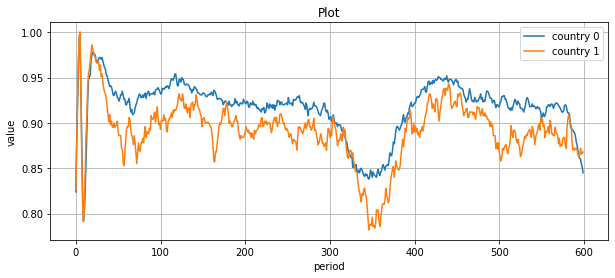

In [92]:
plot(ee["employment"].means())

10


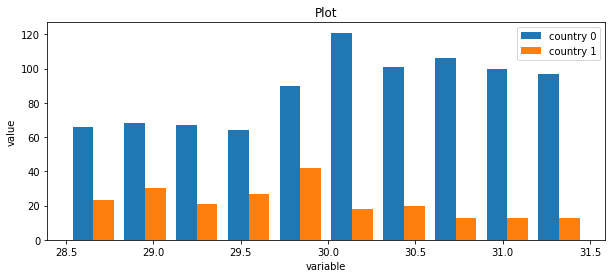

20


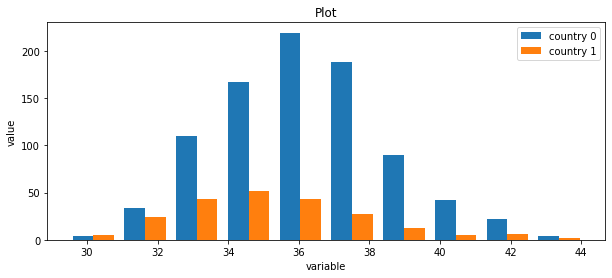

30


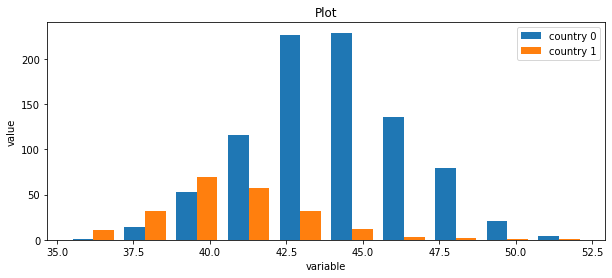

50


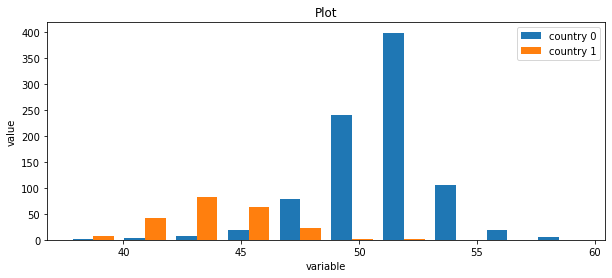

80


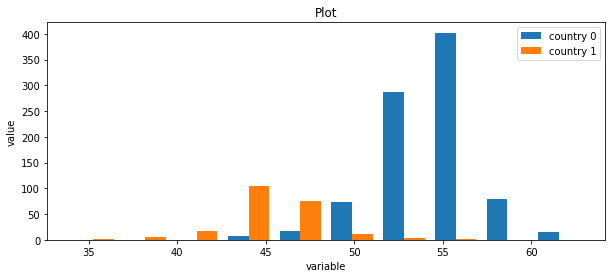

120


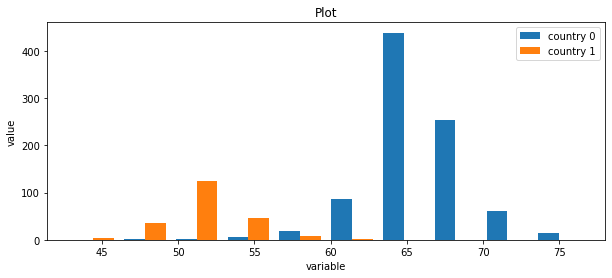

200


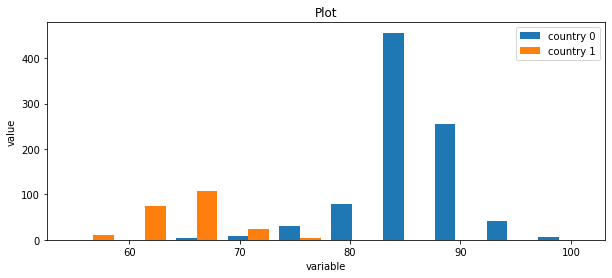

300


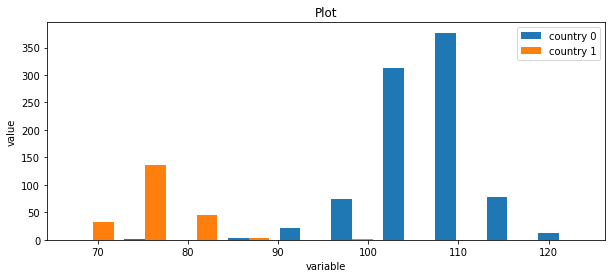

450


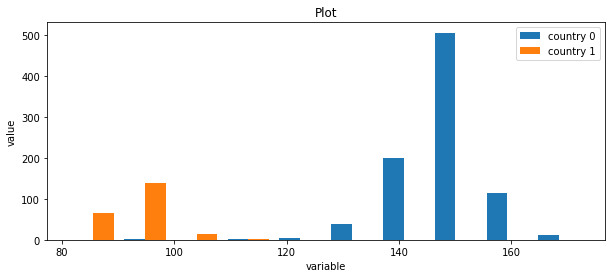

600


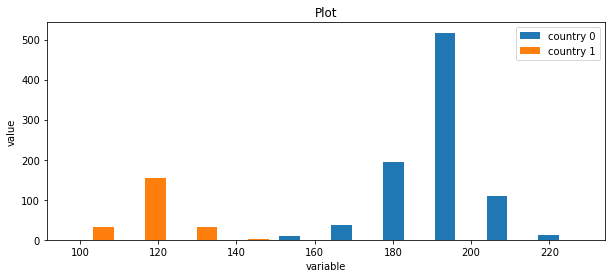

In [95]:
for i, pp in enumerate(p_stops):
    print(pp)
    histogram(prices_data[i][0:2])

10


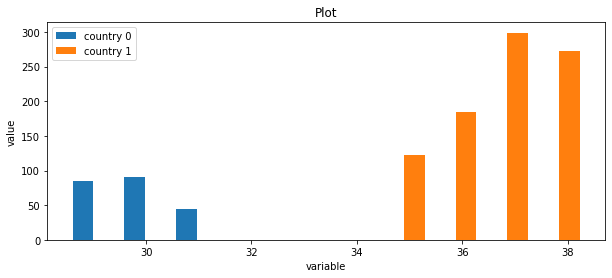

20


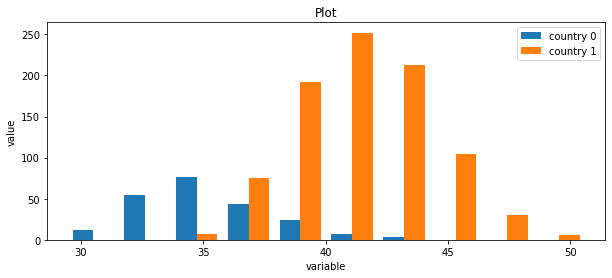

30


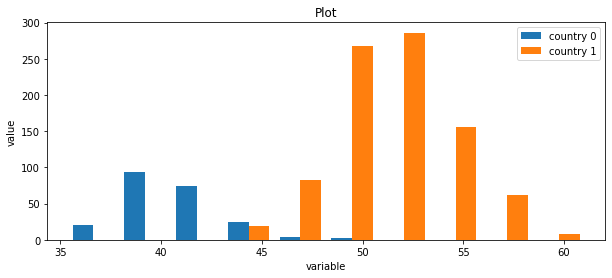

50


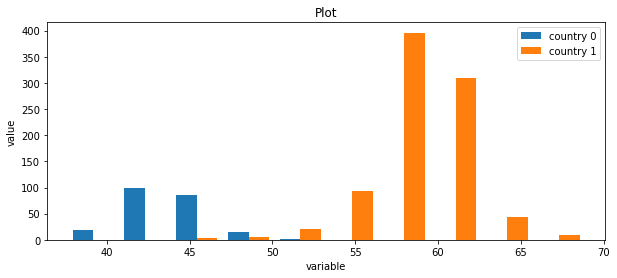

80


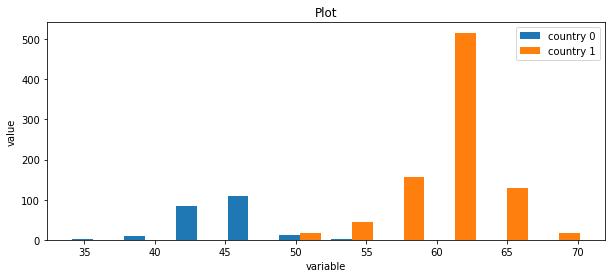

120


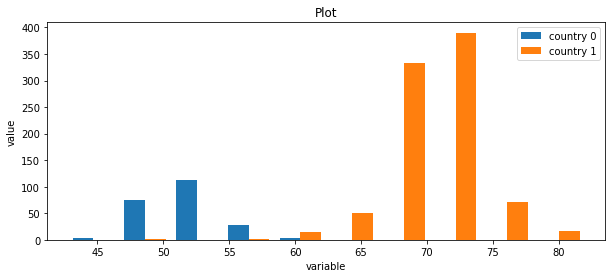

200


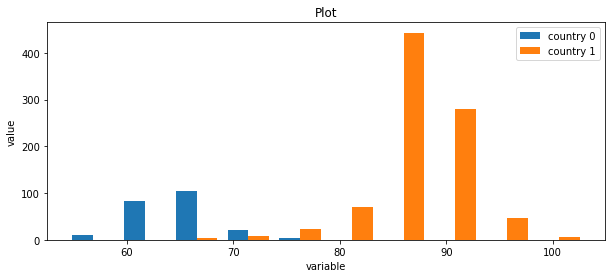

300


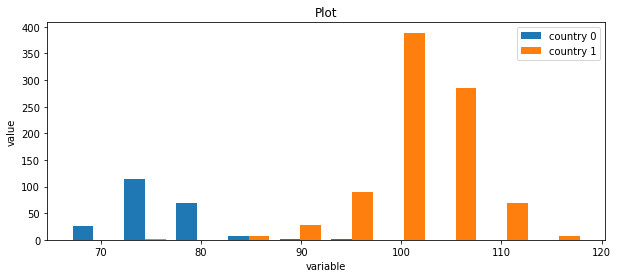

450


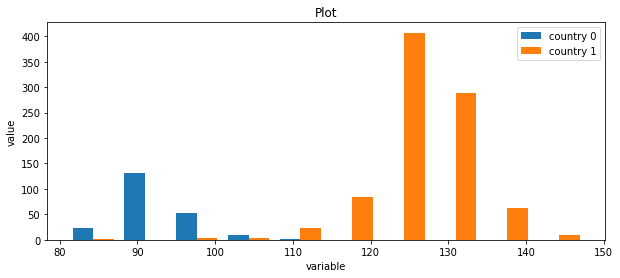

600


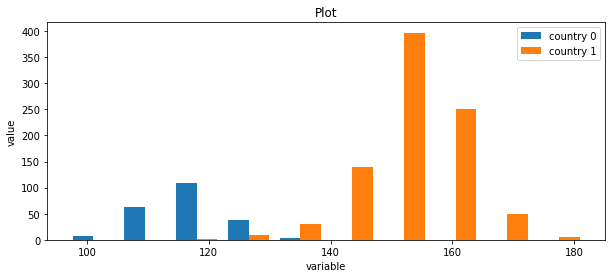

In [96]:
for i, pp in enumerate(p_stops):
    print(pp)
    histogram(prices_data[i][1:2]+exp_prices_data[i][0:1])

10


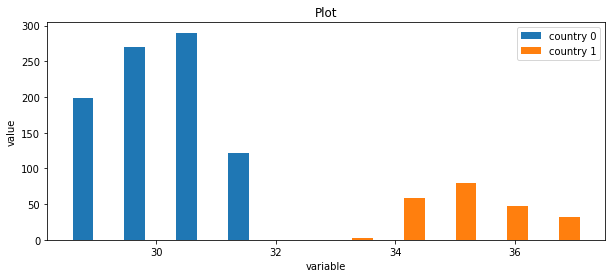

20


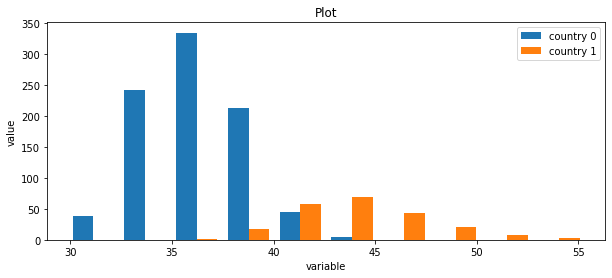

30


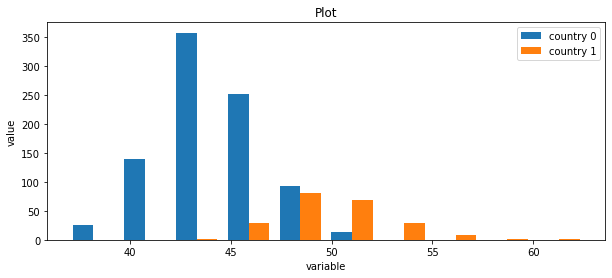

50


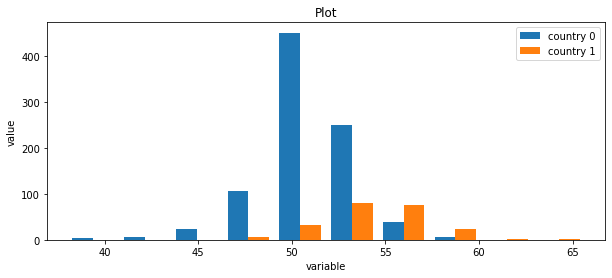

80


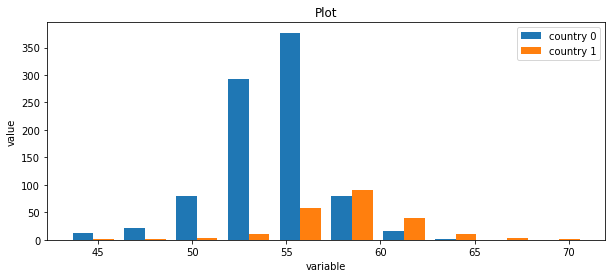

120


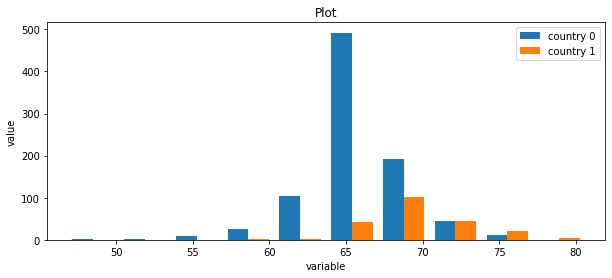

200


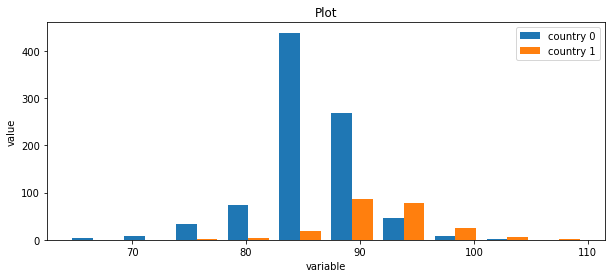

300


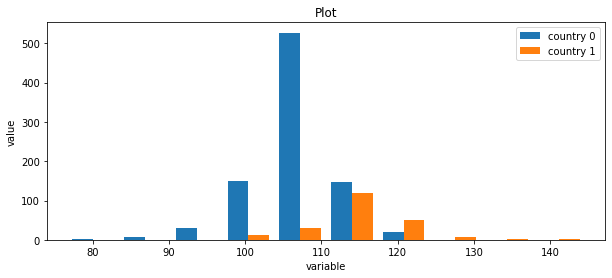

450


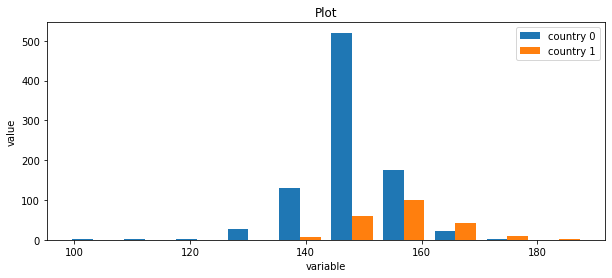

600


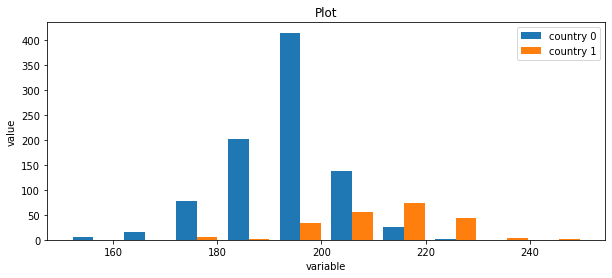

In [97]:
for i, pp in enumerate(p_stops):
    print(pp)
    histogram(prices_data[i][0:1]+exp_prices_data[i][1:2])

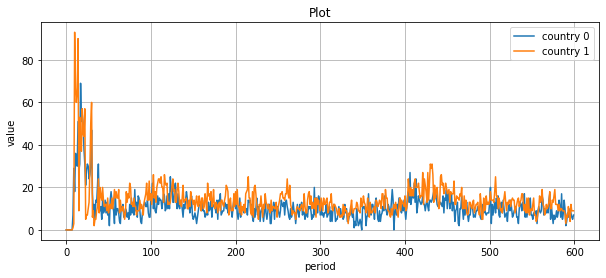

In [98]:
plot(ee["exporting_firms"].sums())

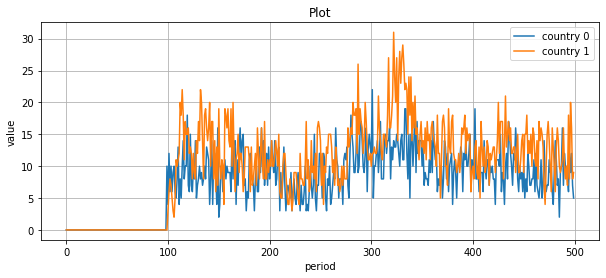

In [131]:
plot(ee2["exporting_firms"].sums())

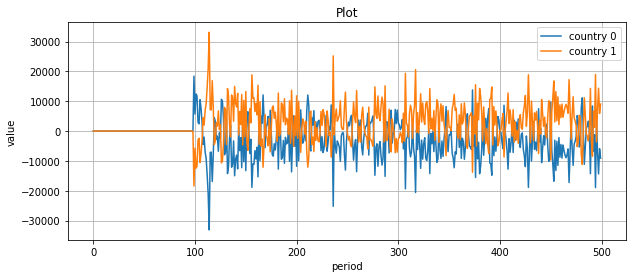

In [132]:
plot(ee2["total_trade_balances_m"])

In [126]:
set_base_pars([8000,2000])
free_market = False
trade_quotas = np.array([[0]*no_countries]*no_countries)                                  
np.fill_diagonal(trade_quotas, [1]*no_countries) 
trade_quotas = [list(country) for country in trade_quotas]

In [127]:
p_stops2 = [90,99,100,110,120,150,200,350,500]
p_steps2 = [90] + list(np.diff(p_stops2))

In [128]:
sim = Simulation(42,42)
prices_data2 = []
exp_prices_data2 = []
for p_step, p_stop in zip(p_steps2, p_stops2):
    if p_stop == 100:
        trade_quotas = np.array([[1]*no_countries]*no_countries)                                  
        np.fill_diagonal(trade_quotas, [1]*no_countries) 
        trade_quotas = [list(country) for country in trade_quotas]
        free_market = True
    sim.run(p_step)
    prices_data2.append([[f.price for f in cc] for cc in FIRMs] + [p_stop]) 
    exp_prices_data2.append([[f.exporting_price for f in cc] for cc in FIRMs]+ [p_stop])

In [129]:
sim.finalize_data()
ee2 = {**TSs, **sim.additional_ts}

<ipython-input-41-dbd4cc37c641>:12: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(multiply*s1/s2))
<ipython-input-40-288ecbf87cb6>:17: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(diff/s1))
<ipython-input-41-dbd4cc37c641>:12: RuntimeWarning: divide by zero encountered in true_divide
  results.append(list(multiply*s1/s2))


90


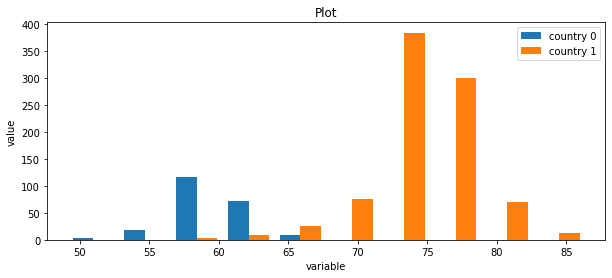

99


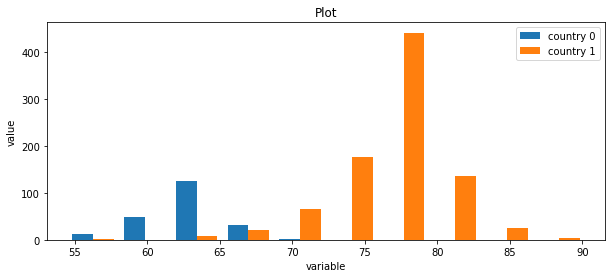

100


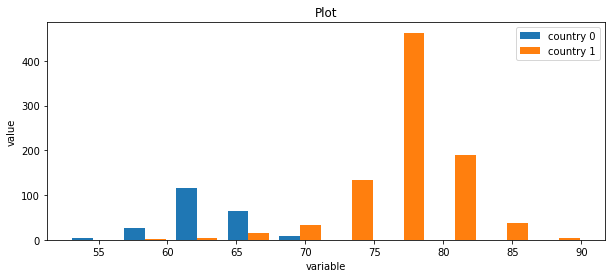

110


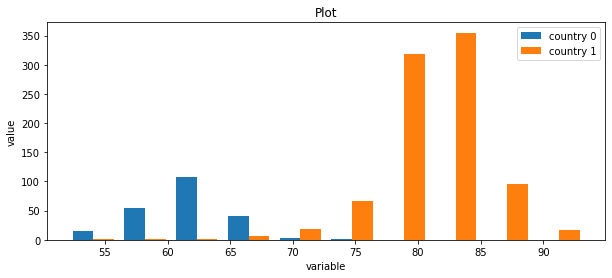

120


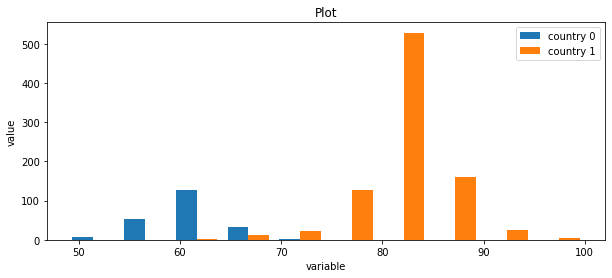

150


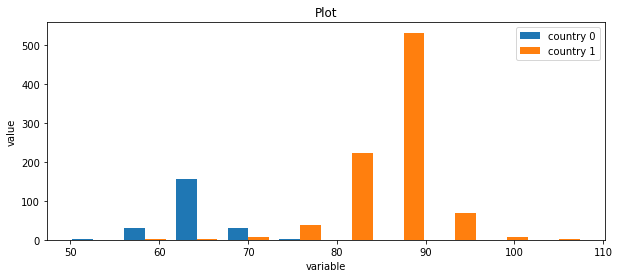

200


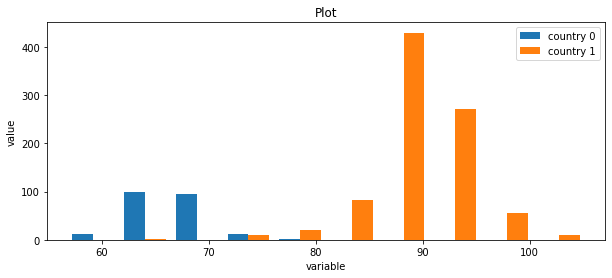

350


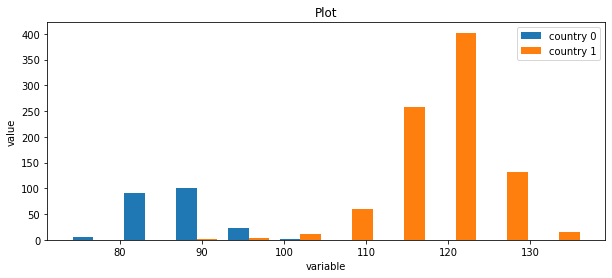

500


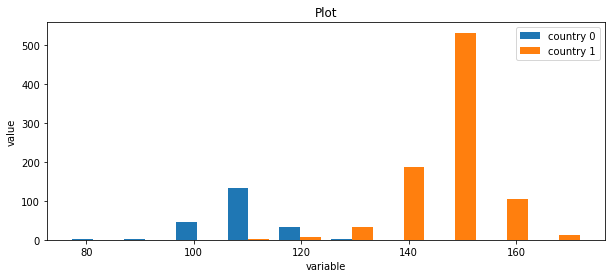

In [130]:
for i, pp in enumerate(p_stops2):
    print(pp)
    histogram(prices_data2[i][1:2]+exp_prices_data2[i][0:1])

90


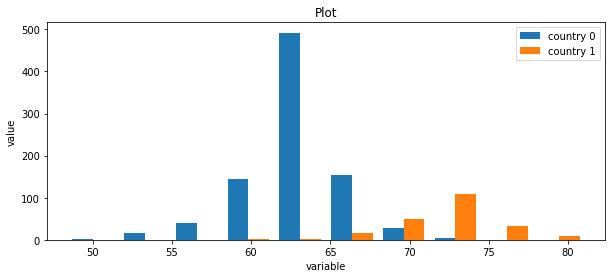

99


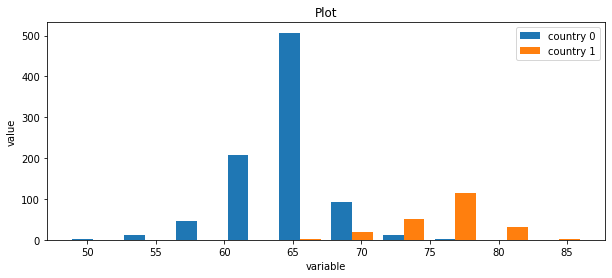

100


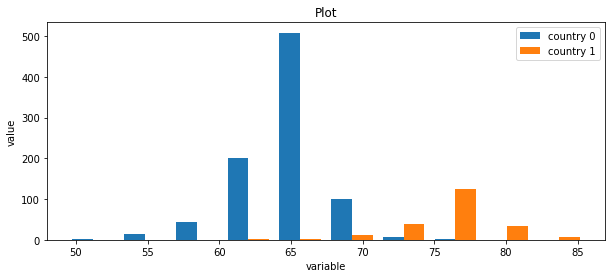

110


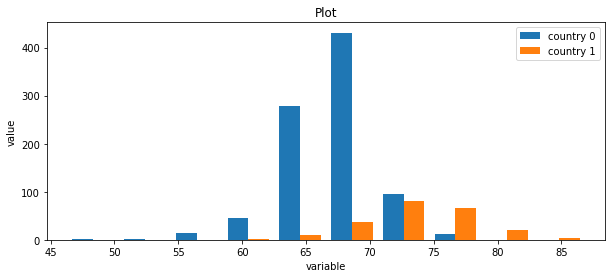

120


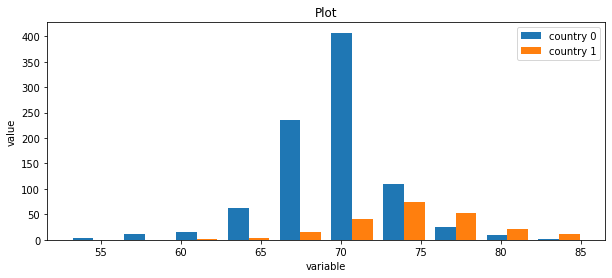

150


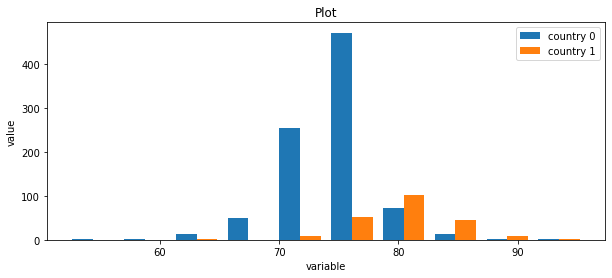

200


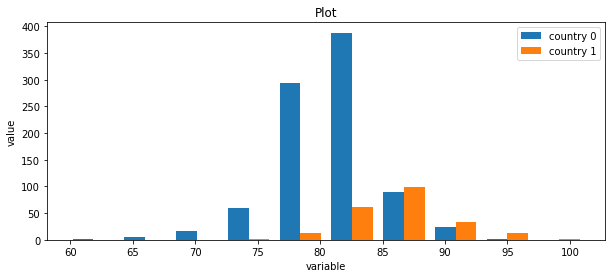

350


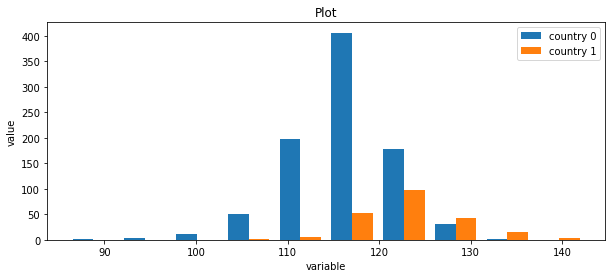

500


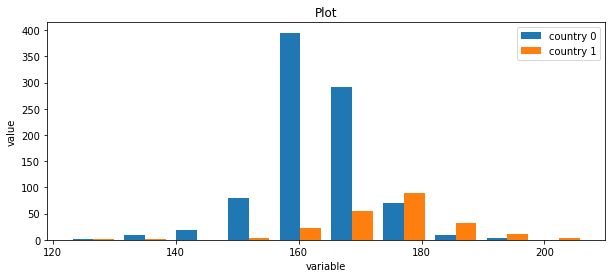

In [133]:
for i, pp in enumerate(p_stops2):
    print(pp)
    histogram(prices_data2[i][0:1]+exp_prices_data2[i][1:2])

In [108]:
trade_quotas = np.array([[1]*no_countries]*no_countries)                                  
np.fill_diagonal(trade_quotas, [1]*no_countries) 
trade_quotas = [list(country) for country in trade_quotas]
free_market = True

In [110]:
sim.run(700)
sim.finalize_data()
ee2 = {**TSs, **sim.additional_ts}
#ee1 = cut_dict(ee)[0]   # with normal distr in exch rate noise

<ipython-input-41-dbd4cc37c641>:12: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(multiply*s1/s2))
<ipython-input-40-288ecbf87cb6>:17: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(diff/s1))
<ipython-input-41-dbd4cc37c641>:12: RuntimeWarning: divide by zero encountered in true_divide
  results.append(list(multiply*s1/s2))


In [115]:
ee2["production_y"] = periodize(ee2["production"].sums())

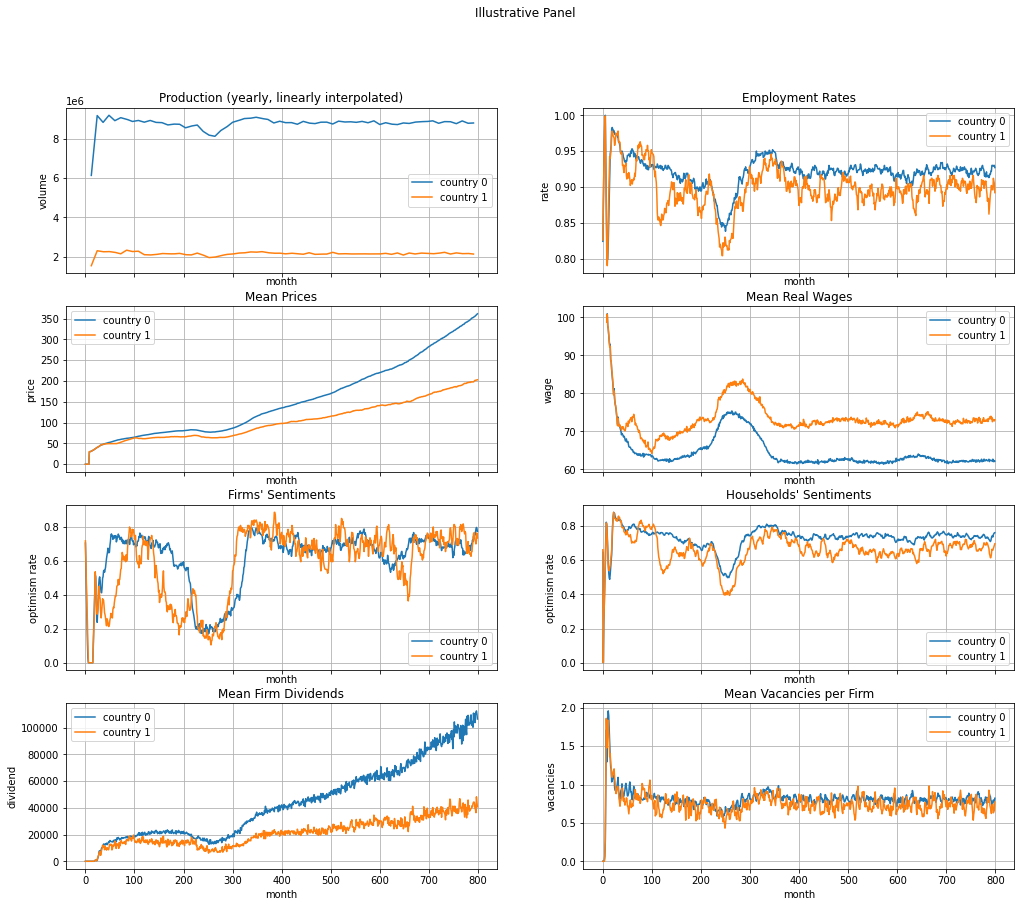

In [116]:
panel(ee2, name = "ill")

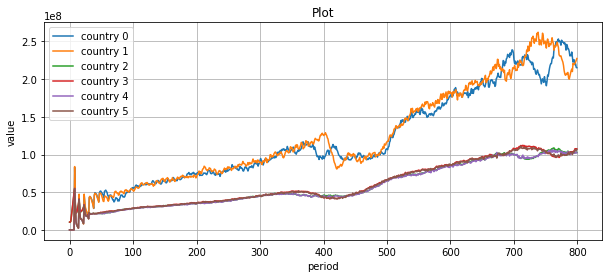

In [131]:
plot(ee["nom_supply"].sums() + ee["budget"].sums() + ee["sales_value"].sums() )

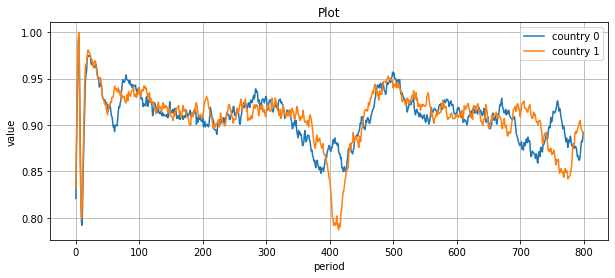

In [135]:
plot(ee["employment"].means())

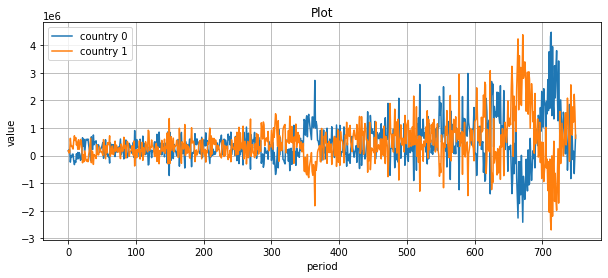

In [225]:
plot( cut(differences(ee["budget"].sums(), ee["sales_value"].sums()), start = 50) )

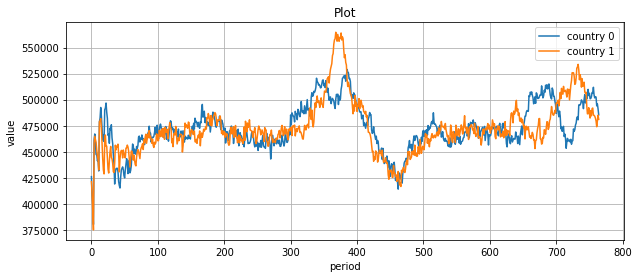

In [212]:
plot(cut(differences(ee["inventories"].sums(),ee["unsold_supply"].sums() ), start = 35))

<ipython-input-172-dbd4cc37c641>:12: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(multiply*s1/s2))


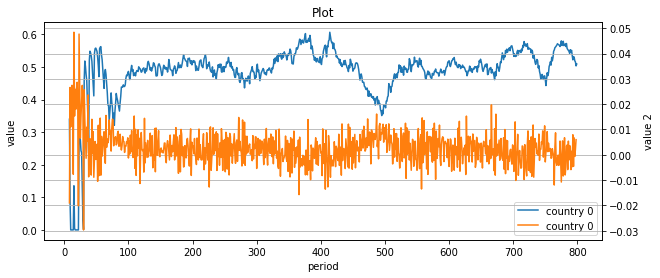

In [228]:
Visual.plot2(ratios(ee["unsold_supply"].sums()[0:1],ee["supply"].sums()[0:1]), 
             series2 = ee["inflation_m"][0:1])

<ipython-input-172-dbd4cc37c641>:12: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(multiply*s1/s2))


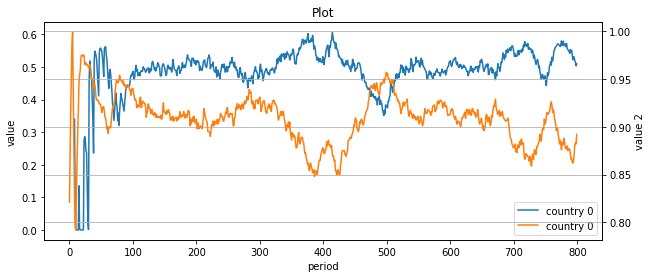

In [224]:
Visual.plot2(ratios(ee["unsold_supply"].sums()[0:1],ee["supply"].sums()[0:1]), series2 = ee["employment"].means()[0:1])

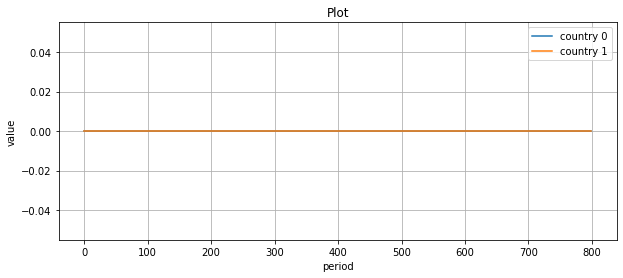

In [210]:
plot(differences(ee["unsold_supply"].sums(),differences(ee["supply"].sums(), ee["sales"].sums())))

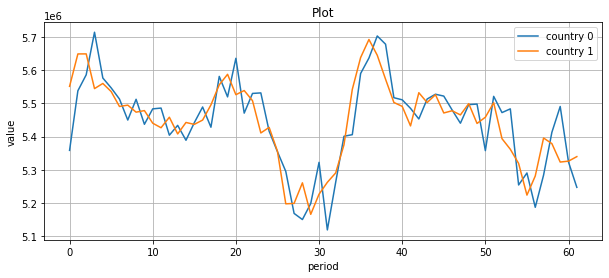

In [215]:
plot(periodize(cut(ee["production"].sums()[0:1] + ee["sales"].sums()[0:1], start = 50)) )

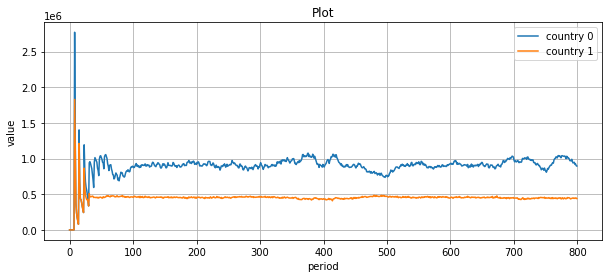

In [136]:
plot(ee["supply"].sums()[0:1] + ee["sales"].sums()[0:1] )

In [67]:
set_base_pars([5000]*2)
sim = Simulation(42, 42)
sim.run(700)
sim.finalize_data()
ee = {**TSs, **sim.additional_ts}
ee2 = cut_dict(ee)[0]   # with uniform distr in exch rate noise

<ipython-input-31-79ce60b4387c>:10: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(multiply*s1/s2))
<ipython-input-30-288ecbf87cb6>:17: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(diff/s1))
<ipython-input-31-79ce60b4387c>:10: RuntimeWarning: divide by zero encountered in true_divide
  results.append(list(multiply*s1/s2))


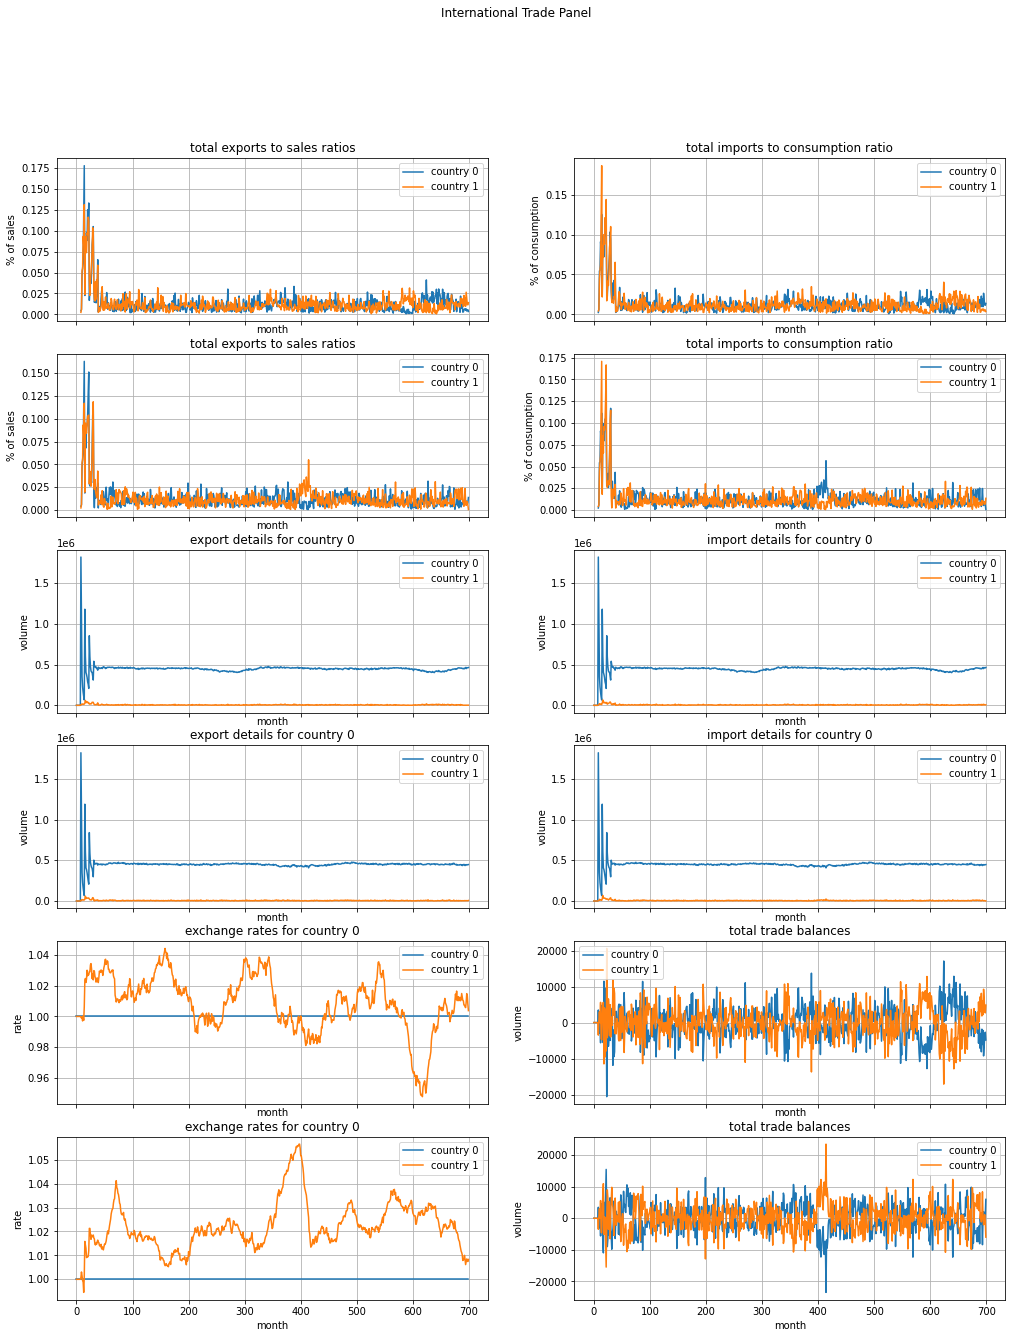

In [69]:
panel(ee1, ee2, name = "int_trade")

In [428]:
set_base_pars([5000]*2)
#trade_costs = np.array([[0, 0.05], [0.45, 0]])                         ## tau
12487, 96329

(12487, 96329)

In [431]:
wage_flex = [0.25, 0.25]
wage_resist = [8, 8]
trade_quotas = make_matrix(0.05)
free_market = False

In [432]:
sim = Simulation()

In [ ]:
sim.run(1500)

634:  Bank 1_b_0 is bankrupt!


In [ ]:
%%timeit
sim.run(10)

In [438]:
period

1499

In [439]:
sim.finalize_data()

<ipython-input-319-79ce60b4387c>:10: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(multiply*s1/s2))
<ipython-input-318-288ecbf87cb6>:17: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(diff/s1))
<ipython-input-319-79ce60b4387c>:10: RuntimeWarning: divide by zero encountered in true_divide
  results.append(list(multiply*s1/s2))


In [440]:
ee = {**TSs, **sim.additional_ts}

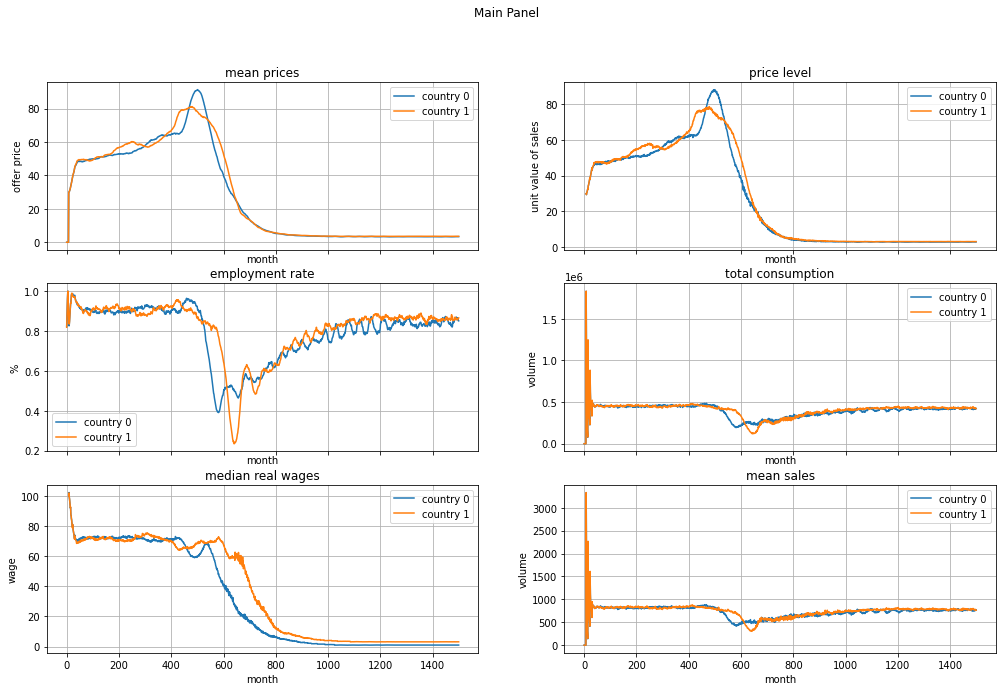

In [441]:
panel(ee)

In [264]:
ee0 = cut_dict(ee)[0]

In [265]:
sim.export_data(note="final_shock_1", csv = False)

<ipython-input-265-75d883913c72>:1: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['employment', 'wages', 'working_wages', 'vol_unemployed', 'months_u',
       'unemployed_months_u', 'hsh_sentiment', 'hsh_income', 'savings_T',
       'budget', 'cons', 'cons_value', 'forced_savings', 'hsh_deposits',
       'prices', 'offered_wages', 'production', 'production_value',
       'labor_demand', 'labor', 'job_offers', 'vacancies', 'inventories',
       'sales', 'sales_value', 'sales_costs', 'firm_assets',
       'firm_capital_target', 'firm_capital', 'firm_dividends',
       'firm_sentiment', 'firm_deposits', 'loans', 'bank_capital',
       'bank_deposit', 'deposits', 'doubtful_loans', 'doubtful_ratio',
       'bankruptcies', 'bank_dividend', 'spec_no_of_firms', 'spec_exch_rates',
       'spec_natural_exch_rates', 'spec_export_details', 'spec_import_details',
 

In [410]:
set_base_pars([5000]*2)
sim = Simulation(12487, 96329)
sim.run(460)
free_market = False
trade_quotas = make_matrix(0)       # shock at the bottom of second country's recession
sim.run(160)
sim.finalize_data()
ee = {**TSs, **sim.additional_ts}
ee1 = cut_dict(ee)[0]
sim.export_data(note="final_shock_2", csv = False)

<ipython-input-319-79ce60b4387c>:10: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(multiply*s1/s2))
<ipython-input-318-288ecbf87cb6>:17: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(diff/s1))
<ipython-input-319-79ce60b4387c>:10: RuntimeWarning: divide by zero encountered in true_divide
  results.append(list(multiply*s1/s2))
<ipython-input-410-eb4c69f894c8>:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['employment', 'wages', 'working_wages', 'vol_unemployed', 'months_u',
       'unemployed_months_u', 'hsh_sentiment', 'hsh_income', 'savings_T',
       'budget', 'cons', 'cons_value', 'forced_savings', 'hsh_deposits',
       'prices', 'offered_wages', 'production', 'production_value',
       'labor_demand', 'labor', 'job_offers', 'vacancies', 'inventories',
       'sales', 'sales_value'

In [271]:
set_base_pars([5000]*2)
sim = Simulation(12487, 96329)
sim.run(440)                       # dont forget 120 period cut from the beginning in the final
free_market = False
trade_quotas = make_matrix(0)       # shock just after first country bottoms 
sim.run(180)
sim.finalize_data()
ee = {**TSs, **sim.additional_ts}
ee2 = cut_dict(ee)[0]
sim.export_data(note="final_shock_3", csv = False)

<ipython-input-190-79ce60b4387c>:10: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(multiply*s1/s2))
<ipython-input-189-288ecbf87cb6>:17: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(diff/s1))
<ipython-input-190-79ce60b4387c>:10: RuntimeWarning: divide by zero encountered in true_divide
  results.append(list(multiply*s1/s2))
<ipython-input-271-b6d518bf728b>:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['employment', 'wages', 'working_wages', 'vol_unemployed', 'months_u',
       'unemployed_months_u', 'hsh_sentiment', 'hsh_income', 'savings_T',
       'budget', 'cons', 'cons_value', 'forced_savings', 'hsh_deposits',
       'prices', 'offered_wages', 'production', 'production_value',
       'labor_demand', 'labor', 'job_offers', 'vacancies', 'inventories',
       'sales', 'sales_value'

In [272]:
set_base_pars([5000]*2)
sim = Simulation(12487, 96329)
sim.run(410)
free_market = False
trade_quotas = make_matrix(0)       # shock just after first country enters recession 
sim.run(210)
sim.finalize_data()
ee = {**TSs, **sim.additional_ts}
ee3 = cut_dict(ee)[0]
sim.export_data(note="final_shock_4", csv = False)

<ipython-input-190-79ce60b4387c>:10: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(multiply*s1/s2))
<ipython-input-189-288ecbf87cb6>:17: RuntimeWarning: invalid value encountered in true_divide
  results.append(list(diff/s1))
<ipython-input-190-79ce60b4387c>:10: RuntimeWarning: divide by zero encountered in true_divide
  results.append(list(multiply*s1/s2))
<ipython-input-272-dc5445670109>:10: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->Index(['employment', 'wages', 'working_wages', 'vol_unemployed', 'months_u',
       'unemployed_months_u', 'hsh_sentiment', 'hsh_income', 'savings_T',
       'budget', 'cons', 'cons_value', 'forced_savings', 'hsh_deposits',
       'prices', 'offered_wages', 'production', 'production_value',
       'labor_demand', 'labor', 'job_offers', 'vacancies', 'inventories',
       'sales', 'sales_value'

In [411]:
shocks_load = Load_analysis(2, "final_shock_", 5, scenario_names = ["normal", "at second's bottom", "after first's bottom", "after start"])

In [412]:
shocks = Analysis(shocks_load)

In [ ]:
shocks.analyze_all()

In [442]:
pp = 'd:\\moje_dokumenty\\Desktop\\diplomka\\model\\text parts\\tables\\special'

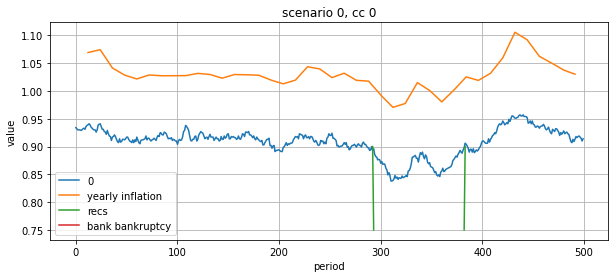

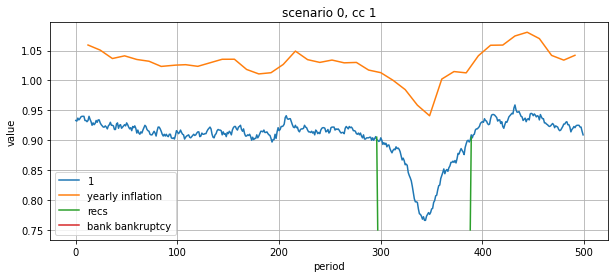

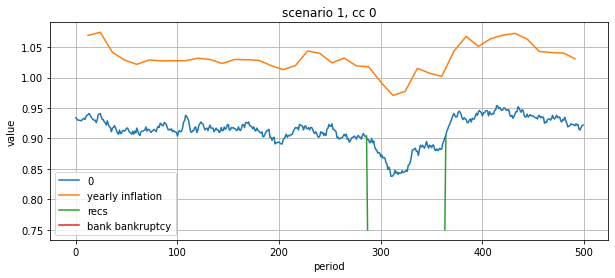

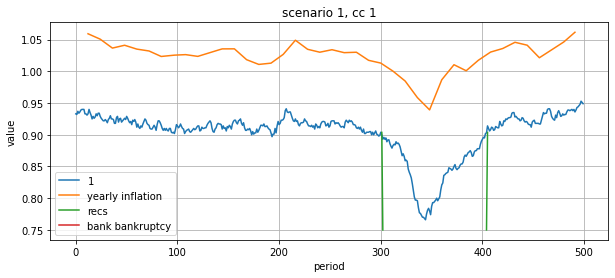

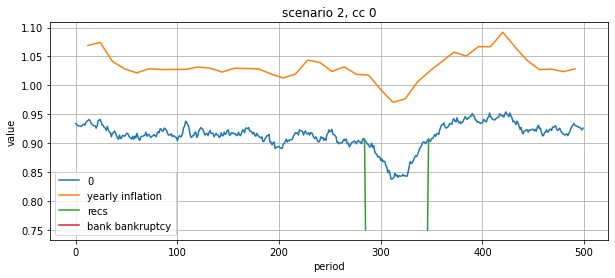

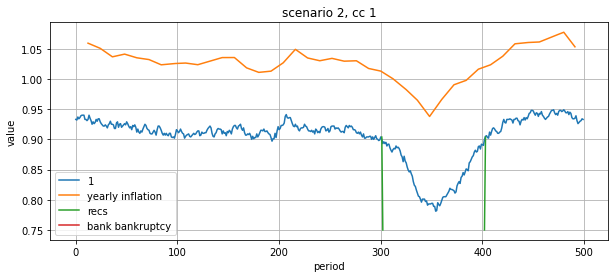

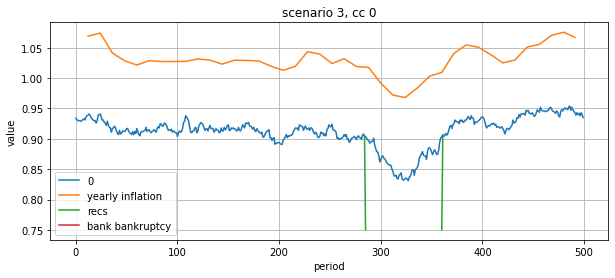

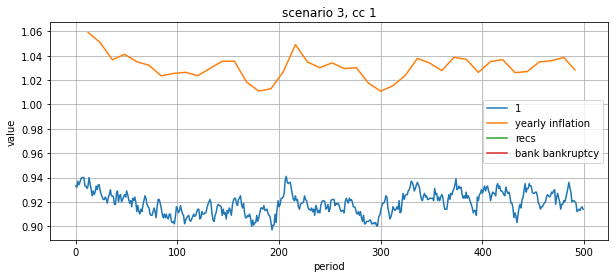

In [415]:
shocks.plot_recs()

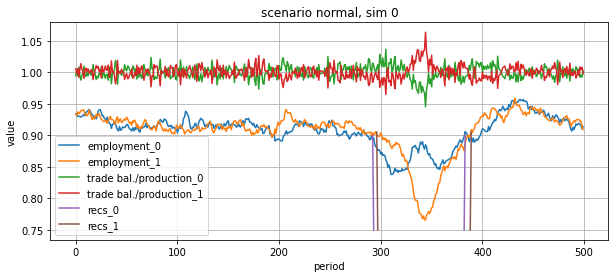

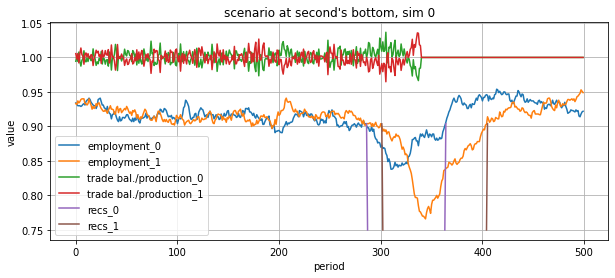

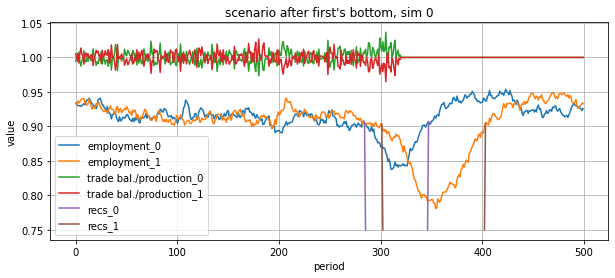

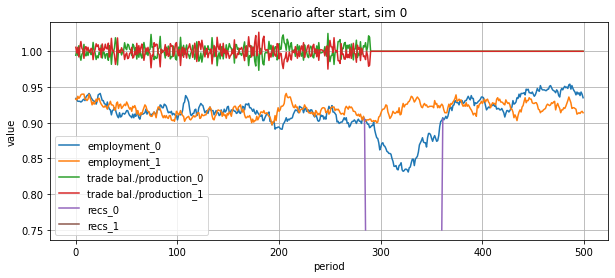

In [443]:
shocks.plot_trading(y_lim = 0.75, path = pp + "\\trade_stop.jpg" )

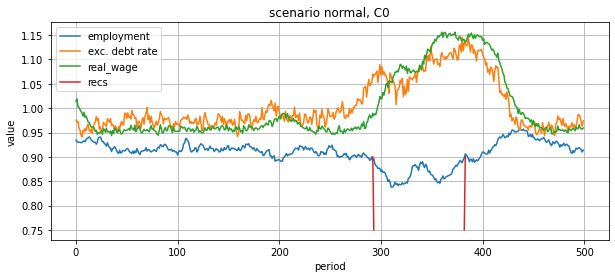

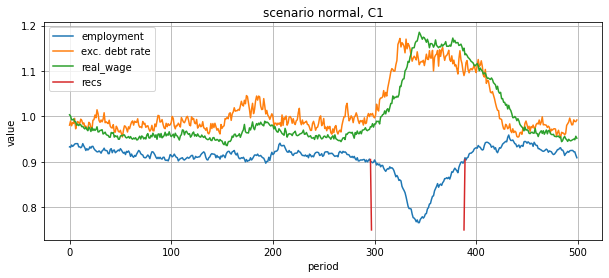

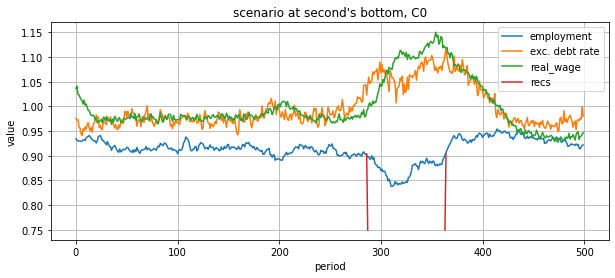

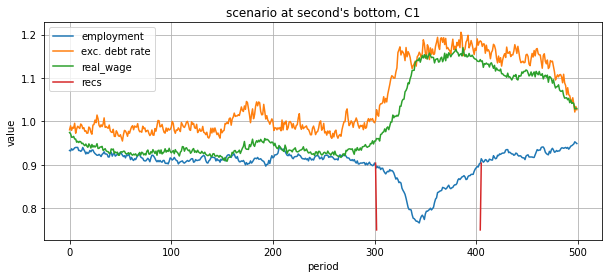

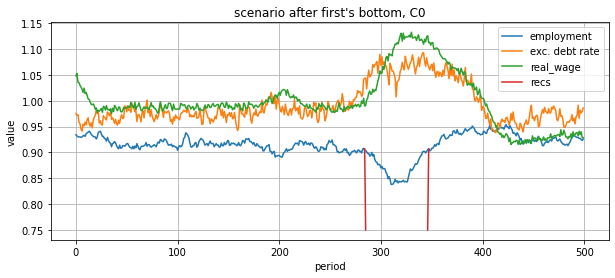

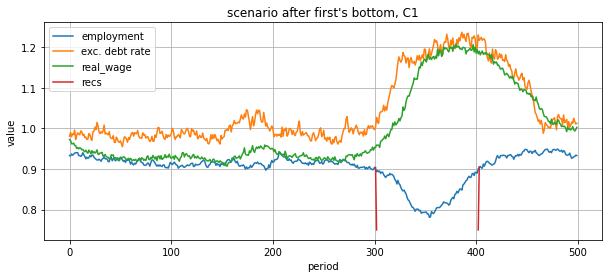

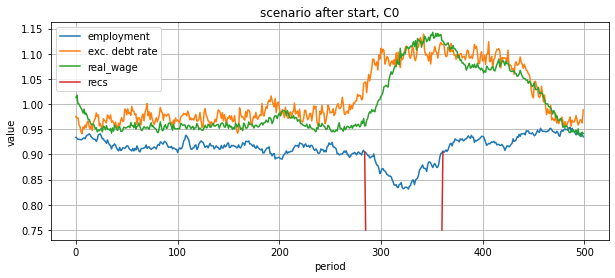

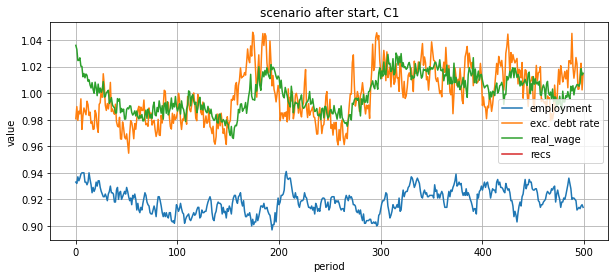

In [417]:
shocks.plot_recovery(y_lim = 0.75)

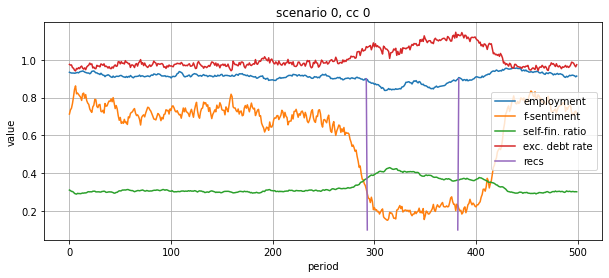

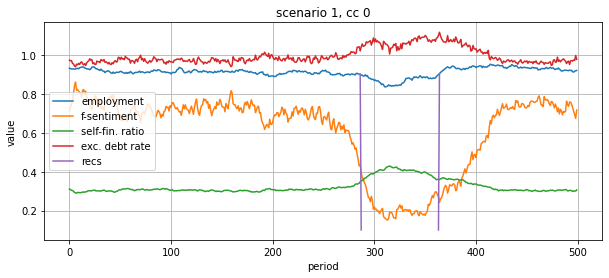

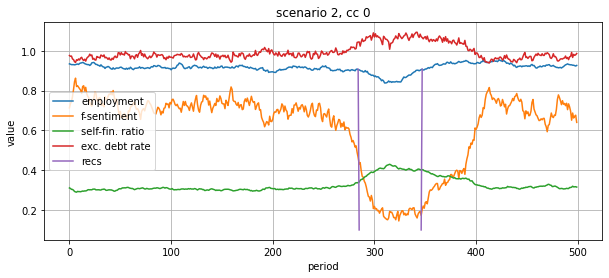

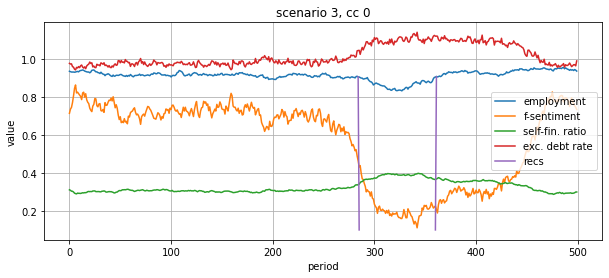

In [418]:
shocks.plot_deleveraging(countries = [[0]]*4)

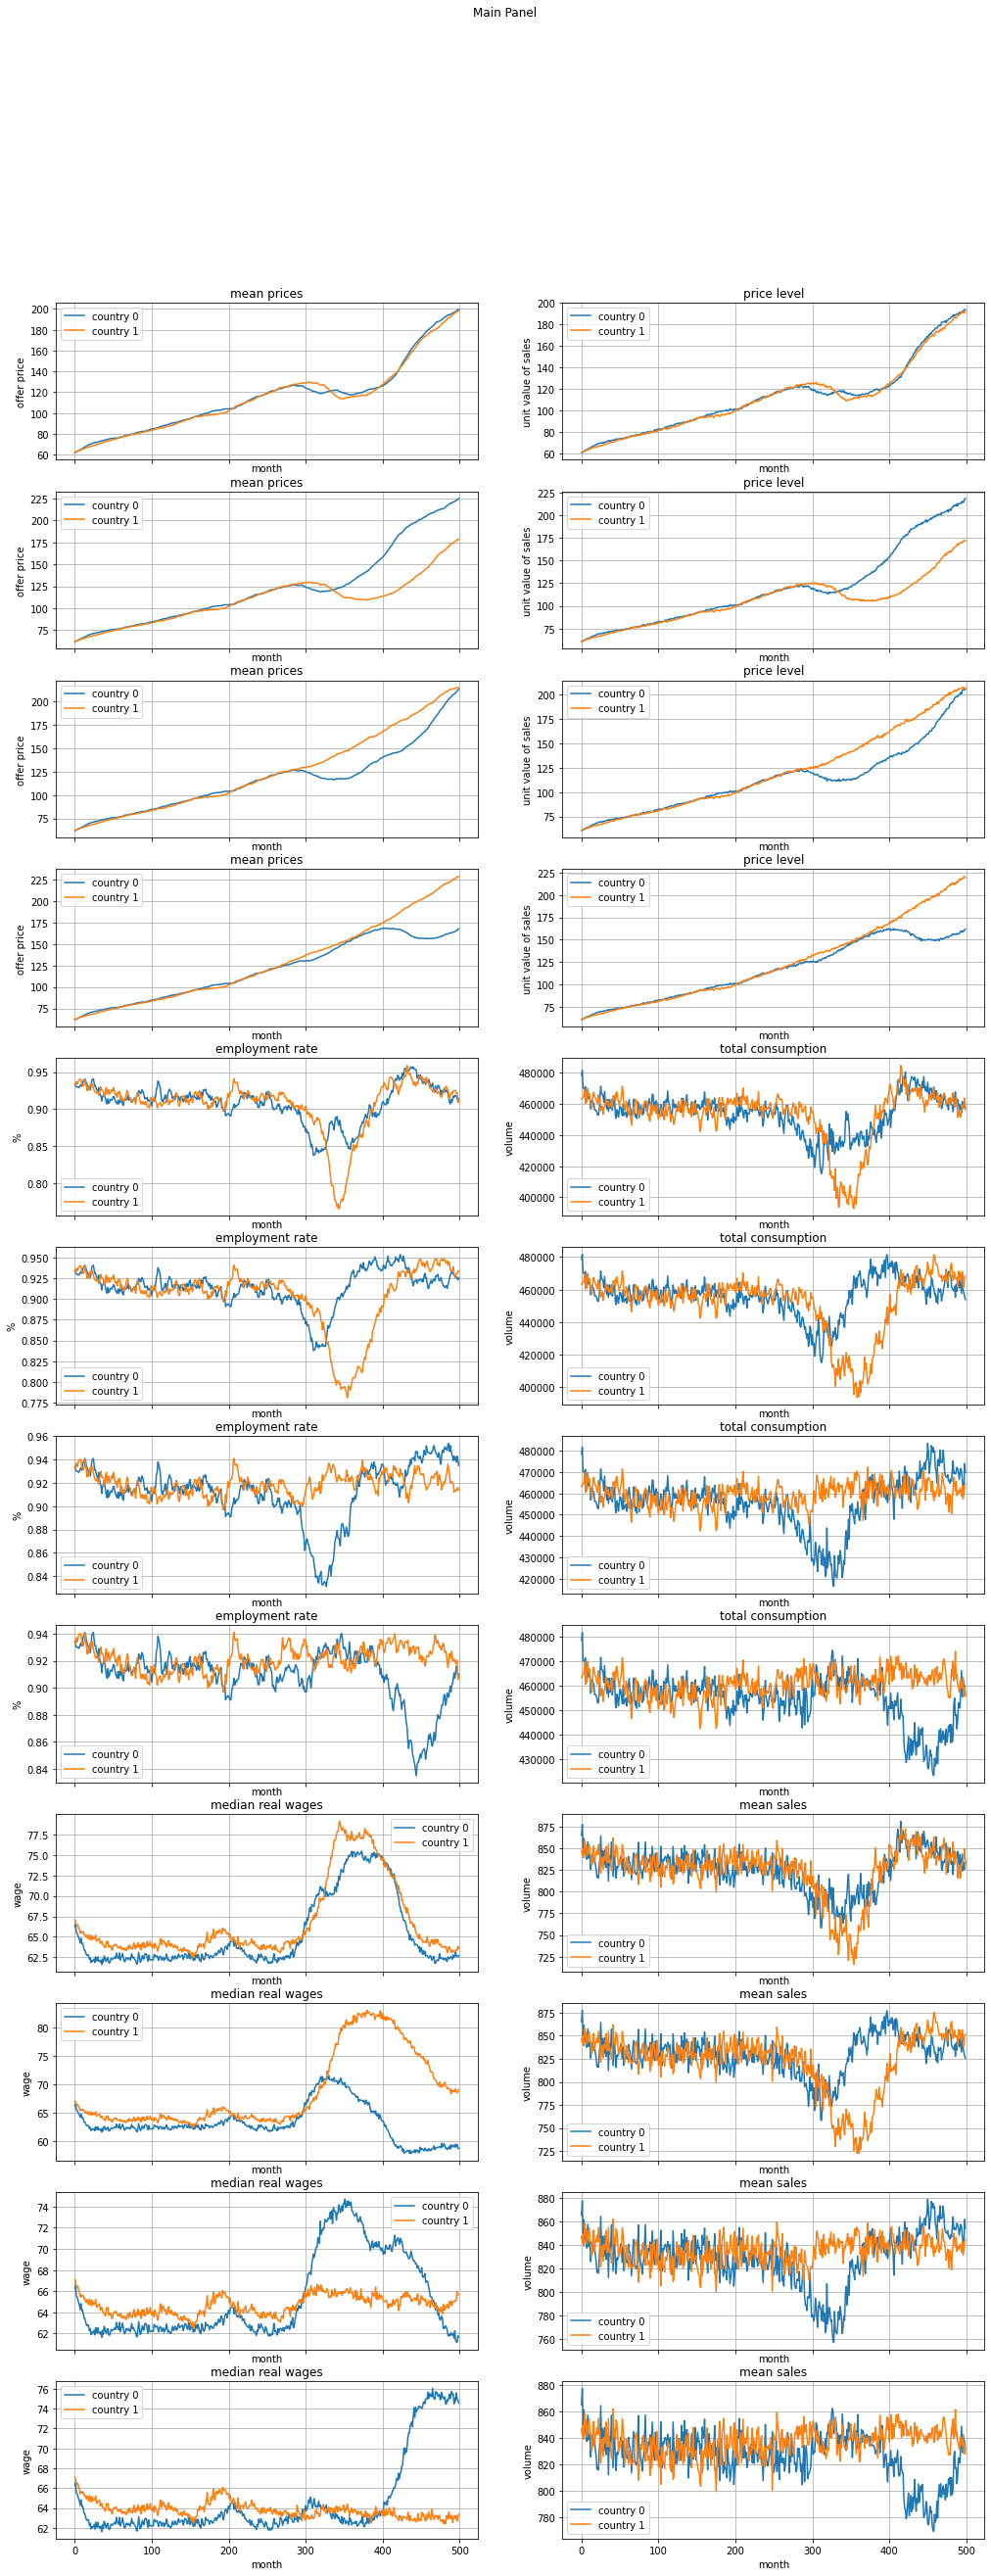

In [284]:
panel(*shocks.firsts, name="main")

In [275]:
ee0_c, ee1_c, ee2_c, ee3_c = cut_dict(ee0, ee1, ee2, ee3, start = 120)

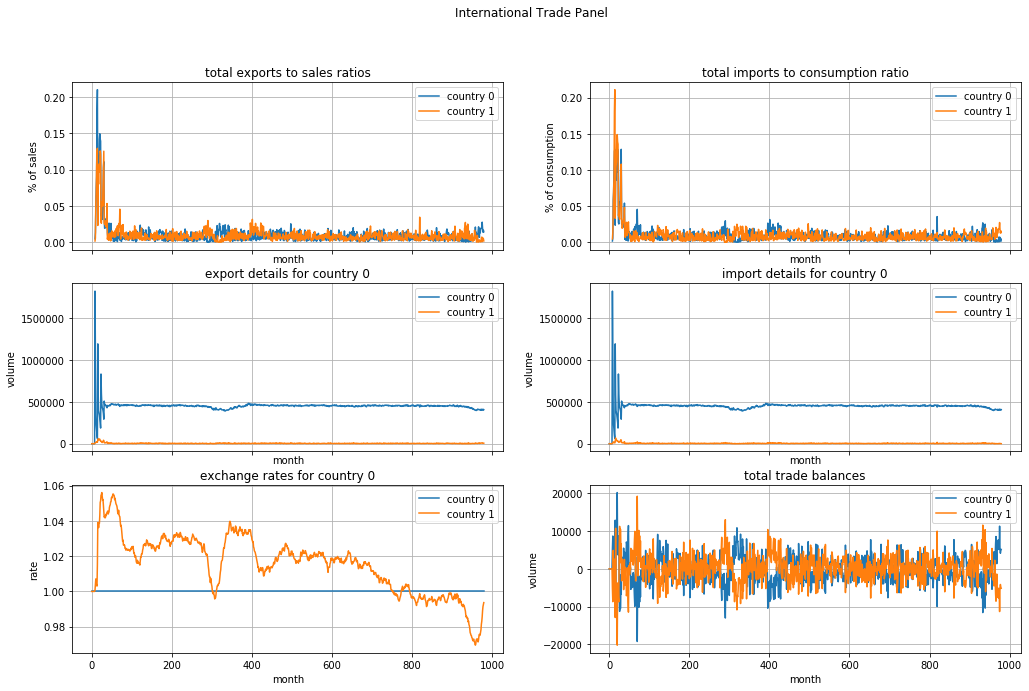

In [151]:
panel(ee0,name="int_trade")

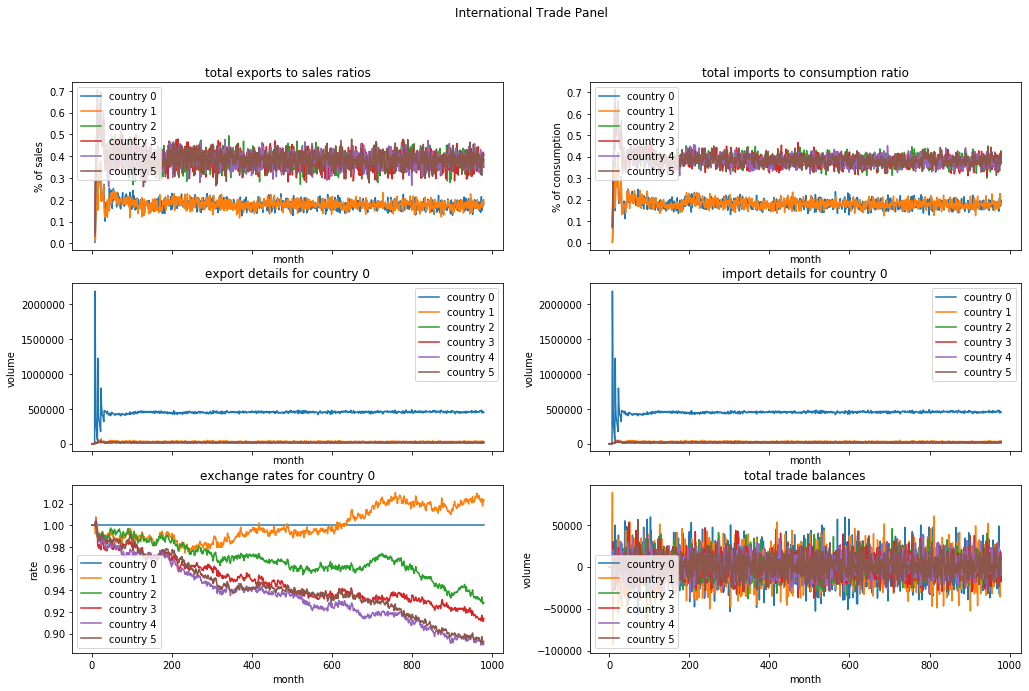

In [279]:
panel(ee3,name="int_trade")

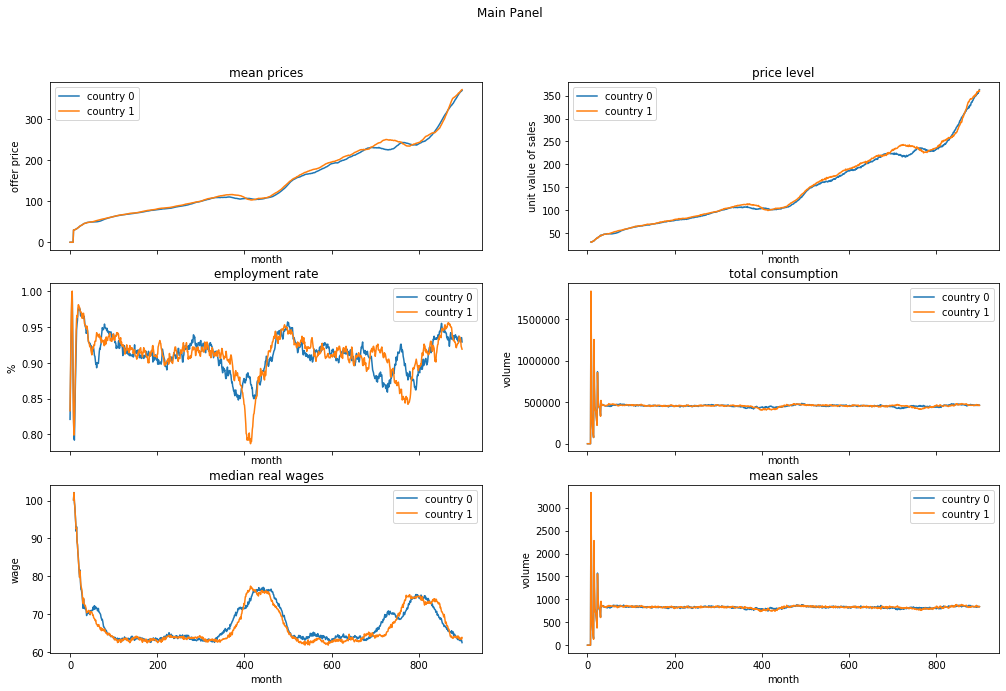

In [186]:
panel(ee4,name="main")

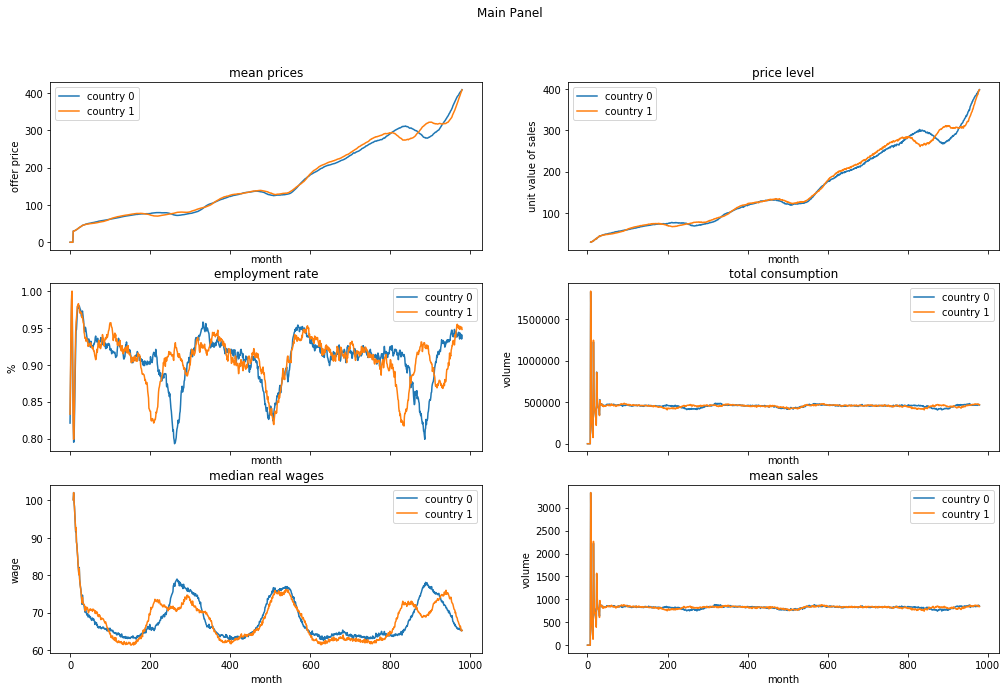

In [188]:
panel(ee5,name="main")

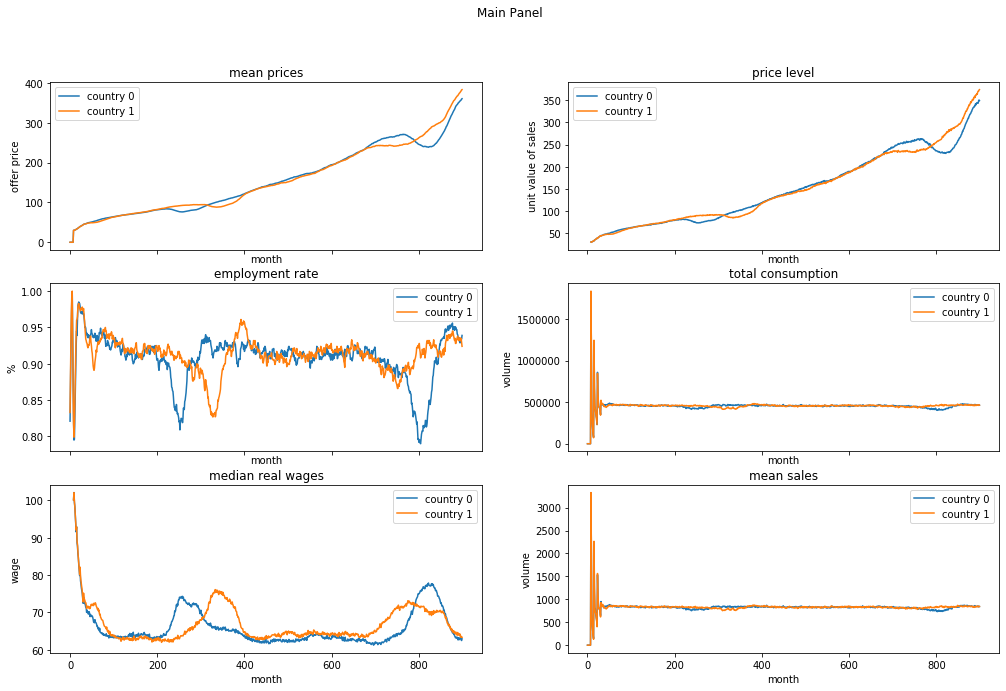

In [197]:
panel(ee6,name="main")

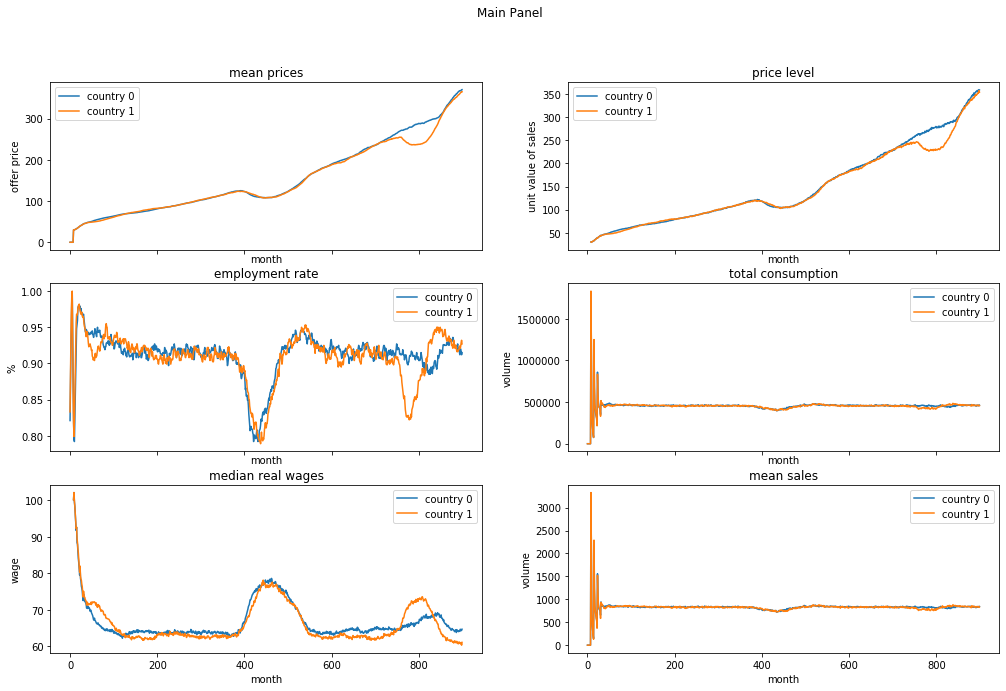

In [198]:
panel(ee7,name="main")

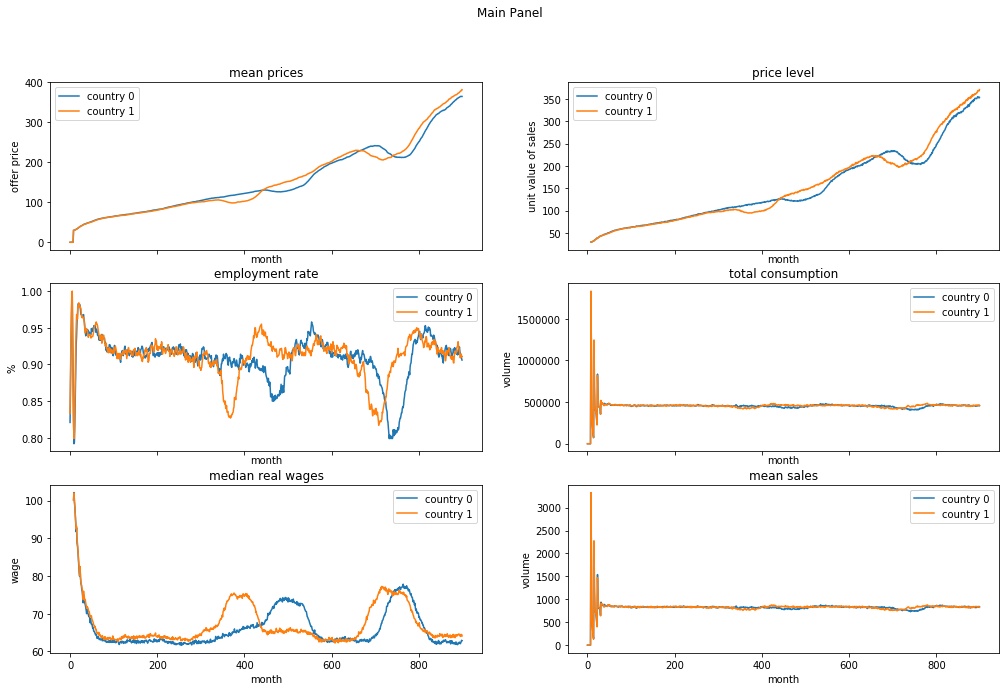

In [199]:
panel(ee8,name="main")

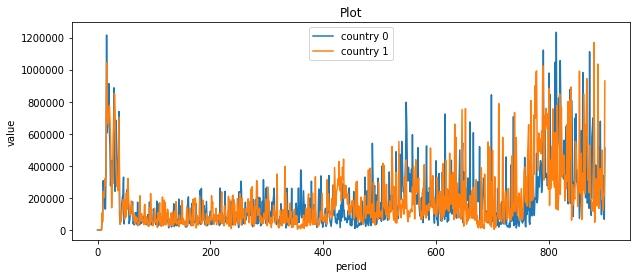

In [210]:
plot(ee8["spec_trade_fees"].sums())

In [ ]:
curve(sim.additional_ts["unemployment_y"], sim.additional_ts["inflation_y"],
      individually = False, standard = True)

curve(sim.additional_ts["unemployment_y"], sim.additional_ts["vacancy_rates_y"],
      individually = False, standard = True, title = "Beveridge curve", y_label = "vacancies_rate")

In [ ]:
price_stats = [TSs["prices"].mins()[0], TSs["prices"].medians()[0], TSs["prices"].maxs()[0]]

price_stats2 = [TSs["prices"].mins()[1], TSs["prices"].medians()[1], TSs["prices"].maxs()[1]]

wage_stats = [TSs["working_wages"].mins()[0], TSs["working_wages"].medians()[0], TSs["working_wages"].maxs()[0]]

wage_stats2 = [TSs["working_wages"].mins()[1], TSs["working_wages"].medians()[1], TSs["working_wages"].maxs()[1]]

In [ ]:
compare( price_stats, price_stats2, wage_stats, wage_stats2, dim = [2,2], size=(12,6),
       titles = ["prices 0", "prices 1", "wages 0", "wages 1"], legend = ["mins", "medians", "maxs"])

In [ ]:
compare( TSs["spec_exch_rates"].sums(), TSs["bankruptcies"].sums(), dim = [2,1], size=(12,7),
       titles = ["exch_rates", "bankruptcies"])

In [ ]:
i = 0
tss = list(TSs.keys()) 

In [ ]:
plot(TSs[tss[i]].means(), title = tss[i])
i +=1

In [ ]:
#i = 0
#tss = list(TSs.values()) 

In [ ]:
#plot(tss[i].sums(), title = tss[i].name)
#i +=1

In [ ]:
plot(TSs["vacancies"].sums())

In [ ]:
plot(TSs["bank_dividend"].sums())

In [ ]:
chosen_HSHs[0].archive

In [54]:
## archive version pre-7.7.2021
class Analysis:
       
    def __init__(self, load_obj):
        self.name = load_obj.name 
        self.first = load_obj.first
        self.last = load_obj.last
        self.cut_start = load_obj.cut_start
        self.cut_end = load_obj.cut_end
        self.scenario_names = load_obj.scenario_names.copy()
        self.no_countries = load_obj.no_countries.copy()
        self.data_list = load_obj.data_list.copy()
        self.pars_list = load_obj.pars_list.copy()
        self.files_list = load_obj.files_list.copy()
        self.firsts = load_obj.firsts.copy()
        self.no_scens = load_obj.no_scens
        
        self.correlations = {}.copy()
        self.ind_correlations = {}.copy()
    
    def concatenate(self, load_obj, name = None):
        """Concatenate with another loaded dataset."""
        if name is None:
            self.name += " " + load_obj.name
        else:
            self.name = name
        # first, last, cut_start/end remains unchanged
        self.scenario_names.extend(load_obj.scenario_names)
        self.no_countries.extend(load_obj.no_countries)
        self.data_list.extend(load_obj.data_list)
        self.pars_list.extend(load_obj.pars_list)
        self.files_list.extend(load_obj.files_list)
        self.firsts.extend(load_obj.firsts)
        self.no_scens += load_obj.no_scens
        
    def subset(self, scenarios, name = None):
        """Creates load object containing chosen scenarios."""
        ee = Load_analysis(0,"empty", 0)
        if name is None:
            ee.name = self.name
        else:
            ee.name = name
        # first, last remain as in empty load object
        ee.cut_start = self.cut_start
        ee.cut_end = self.cut_end
        ee.scenario_names = [self.scenario_names[i] for i in scenarios]
        ee.no_countries = [self.no_countries[i] for i in scenarios]
        ee.data_list = [self.data_list[i] for i in scenarios]
        ee.pars_list = [self.pars_list[i] for i in scenarios]
        ee.files_list = [self.files_list[i] for i in scenarios]
        ee.firsts = [self.firsts[i] for i in scenarios]
        ee.no_scens = len(scenarios)
        return ee
    
    def make_pars_dicts(self):
        """Works for standardly loaded objects."""
        name = self.name.split(" ")
        if name[0] == "BB":
            no = 4
            ns = [ [5000,5000]]*no
            res = [[12, 12], [8,8], [12,8], [12,8]]
            flex = [[0.05, 0.05], [0.08,0.08], [0.05, 0.08], [0.05,0.25]]
        else:
            no = 6
            ns = [ [8000,2000]]*no
            res = [[12, 12], [8,8], [12,8], [8,12], [12,8], [8,12]]
            flex = [[0.05, 0.05], [0.08,0.08], [0.05, 0.08], [0.08, 0.05], [0.05,0.25], [0.25,0.05]]
    
        if name[1] == "base":
            costs = [str(make_matrix(0.2, True))]*no
        elif name[1] == "nc":
            costs = [str(make_matrix(0, True))]*no
        else:
            if name[0] == "BB":
                costs = [str(make_matrix(0.7, True))]*no
            else:
                costs = [str(make_matrix(0.4, True))]*no
    
        if name[-2] == "free":
            quotas = [str(make_matrix(1))]*no
            free_m = [True]*no
        elif name[-2] == "med":
            quotas = [str(make_matrix(0.3))]*no
            free_m = [False]*no
        else:
            quotas = [str(make_matrix(0.05))]*no
            free_m = [False]*no
    
        if name[2] == "pegged":
            pegs = [[-1, 0]]*no
        else:
            pegs = [[-1, -1]]*no
            
           
        dicts = [{"ns": ns[i], "wage_resist": res[i], "wage_flex": flex[i], 
              "trade_costs": costs[i], 'trade_quotas': quotas[i], "free_market": free_m[i],
             'pegged_rates': pegs[i], "transport_firms": 2} for i in range(self.first-1, self.last-1)]
        return dicts
        
    def test_parameters(self, pars_dicts = "default"):
        """Default works for standardly loaded objects."""
        errors = []
        if pars_dicts == "default":
            pars_dicts = self.make_pars_dicts()
        for i, pars_dict in enumerate(pars_dicts):
            for par in pars_dict:
                for j, sim in enumerate(self.pars_list[i]):
                    value = sim[par][0].split("= ")[-1]
                    if str(pars_dict[par]) != value:
                        errors.append("scenario " + str(i) + " simulation " + str(j) + ": " + par)
        self.pars_errors = errors
        return errors

    
    def analyze_recs(self, recs_cond = 0.03, recs_percentile = 25, general = True):
        """Analyze recessions."""
        self.empl_borders = []           # scenario->country->simulation
        self.empl_data = []              # scenario->country->simulation
        self.BC_synchronizations = []    # scenario->country->simulation
        self.general_low = general
        
        for ii, scenario in enumerate(self.data_list):    # go scenario by scenario
            recs_borders = []
            recs_scenario_data = []
            empl_sync = []
            
            for cc in range(self.no_countries[ii]):   # go country by country
                recs_data = []
                if general:                       # area of stability shared across all simulations in a scenario
                    percs = [np.percentile(sim["employment"].means()[cc], recs_percentile) for sim in scenario]
                    low = np.mean(percs)                     # find border of area of stability
                    recs_borders.append((low, np.std(percs)))  
                for sim in scenario:          # go simulation by simulation
                    series = sim["employment"].means()[cc]
                    if not general:               # simulation-specific area of stability
                        low = np.percentile(series, recs_percentile)
                        
                    # find_recs gives stability border, and recessions' starts, ends, depths, and lengths 
                    recs_data.append(find_recs(series, recs_cond, recs_percentile, low = low))  # find recessions
                    if cc == 0:
                        if self.no_countries[ii] == 2:
                            empl_sync.append(np.corrcoef(sim["employment"].means())[0][1])
                        else:
                            empl_sync.append(np.corrcoef(sim["employment"].means()))                ### work out differently 
                recs_scenario_data.append(recs_data)
            
            self.empl_borders.append(recs_borders)
            self.empl_data.append(recs_scenario_data)
            if self.no_countries[ii] == 2:
                rec_sync = [BC_synchronization(recs_scenario_data[0][sim][1:3], recs_scenario_data[1][sim][1:3]) 
                            for sim in range(len(scenario))]
                self.BC_synchronizations.append([(round2(np.mean(empl_sync),1), round2(np.std(empl_sync),2)), 
                                                 (round2(np.mean(rec_sync),1), round2(np.std(rec_sync),2))])
            else:
                self.BC_synchronizations.append([(np.mean(empl_sync, axis = 0), np.std(empl_sync, axis = 0))])
        
        self.recs_depths, self.recs_lengths, self.recs_count = [], [], []
        self.recs_time = []
        self.recs_ind_data = []
        for scenario in self.empl_data:
            scen_depths, scen_lengths, scen_count = [], [], []   # everything for only finished recessions
            scen_time = []
            scen_recs_ind_data = []
            for country in scenario:
                lengths, time = [], []
                depths, count = [], []
                for sim in country:
                    lengths.extend(sim[4])
                    depths.extend(sim[3])
                    count.append(len(sim[2])) 
                    time.append(sum(sim[4]))    
                scen_depths.append((round2(np.mean(depths),1),round2(min(depths),1),round2(np.median(depths),1),
                                    round2(max(depths),1), round2(np.std(depths),2)))
                scen_lengths.append((round2(np.mean(lengths),1), round2(min(lengths),1), round2(np.median(lengths),1), 
                                     round2(max(lengths),1), round2(np.std(lengths),2)))
                scen_count.append((round2(np.mean(count),1), round2(min(count),1), round2(np.median(count),1),
                                   round2(max(count),1), round2(np.std(count),2)))
                scen_time.append((round2(np.mean(time),1), round2(min(time),1),round2(np.median(time),1),
                                  round2(max(time),1), round2(np.std(time),2)))
                scen_recs_ind_data.append([depths, lengths, time, count])
            self.recs_ind_data.append(scen_recs_ind_data)
            self.recs_depths.append(scen_depths)
            self.recs_lengths.append(scen_lengths)
            self.recs_count.append(scen_count)
            self.recs_time.append(scen_time)
        
    def get_averages(self, variables = "all"):
        """Calculates averages,stds and stds-of-stds of interesting time series.
        For "all" option assumes same variables across scenarios."""
        self.averages = {}
        if variables == "all":
            variables = self.data_list[0][0]
        for key in variables:
            try:
                self.averages[key] = averaging(self.data_list, key, "means")
            except:
                try:
                    self.averages[key] = averaging(self.data_list, key, "data")
                except:
                    self.averages[key] = averaging(self.data_list, key, "sums")
        
    
    def make_correlations(self, var1, var2 = None, type1 = "sums", type2 = "sums",
                          across = True, countries = "all", scenarios = "all", sims = "all",
                         save = False):
        """Option "across" for scenarios with 2 countries only."""
        if scenarios == "all":
            scenarios = [s for s in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if sims == "all":
            sims = [[i for i, sim in enumerate(self.data_list[scen])] for scen in scenarios]
            
        all_ind_corrs, corrs_stats = [], []
        
        for scen in scenarios:
            scen_corrs = []
            for sim in sims[scen]:
                sim_data = self.data_list[scen][sim]
                if across:
                    if type1 == "data":
                        corr = np.corrcoef(sim_data[var1])[1][0]
                    elif type1 == "means":
                        corr = np.corrcoef(sim_data[var1].means())[1][0]
                    elif type1 == "sums":
                        corr = np.corrcoef(sim_data[var1].sums())[1][0]
                    
                else:
                    if type1 == "data":
                        v1s = sim_data[var1] 
                    elif type1 == "means":
                        v1s = sim_data[var1].means()
                    elif type1 == "sums":
                        v1s = sim_data[var1].sums()
                    if type2 == "data":
                        v2s = sim_data[var2] 
                    elif type2 == "means":
                        v2s = sim_data[var2].means()
                    elif type2 == "sums":
                        v2s = sim_data[var2].sums()
                    corr = [np.corrcoef(v1s[cc], v2s[cc])[1][0] for cc in countries[scen]]
                scen_corrs.append(corr) 
            if across:
                all_ind_corrs.append(round2_vect(scen_corrs,1))
            else:
                countrywise = [[sim[cc] for sim in scen_corrs] for cc in countries[scen]]
                all_ind_corrs.append(round2_vect(countrywise,1))
            stats = (round2_vect(np.mean(scen_corrs, axis = 0),1), round2_vect(np.min(scen_corrs, axis = 0),1), 
                        round2_vect(np.median(scen_corrs, axis = 0),1), round2_vect(np.max(scen_corrs, axis = 0),1), 
                        round2_vect(np.std(scen_corrs, axis = 0),2))
            if across:
                corrs_stats.append([float(st) for st in stats])
            else:
                countrywise_stats = [[stat[cc] for stat in stats] for cc in countries[scen]]
                corrs_stats.append(countrywise_stats)
        if across:
            var2 = type1
        if save:
            self.ind_correlations[var1 + "-" + var2] = all_ind_corrs
            self.correlations[var1 + "-" + var2] = corrs_stats
        return all_ind_corrs, corrs_stats     
              
    
    def analyze_all(self, recs_cond = 0.03, recs_percentile = 25):
        """Analyze everything."""
        self.analyze_recs(recs_cond, recs_percentile)
        self.get_averages()
            
    
    def plot_recs(self, scenarios = "all", sims = [0], countries = "all", 
                  y_lim = 0.75,  length = 1380,
                  marker = "-", grid = True, path = None):
        if scenarios == "all":
            scenarios = [i for i in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if path is not None:
            iii = path.find(".")
        for scenario in scenarios:
            for simulation in sims:
                for country in countries[scenario]:
                    empl = self.data_list[scenario][simulation]["employment"].means()[country]
                    low, sts, ends = self.empl_data[scenario][country][simulation][:3]
                    marks = markers(sts, ends, low, y_lim = y_lim,  length = length)
                    title = "scenario " + str(scenario) + ", cc " + str(country)
                    bb = self.data_list[scenario][simulation]["bank_bankruptcies"][country][0]
                    if bb is False:
                        marks2 = markers([],[],1)
                    else:
                        marks2 = markers([bb],[],1, y_lim = y_lim,  length = length)
                    legend = [str(country), "recs", "bank bankruptcy"]
                    if path is None:
                        path2 = path
                    else:
                        path2 = path[:iii] + "_" + str(scenario) + "_" + str(country) + path[iii:]
                    plot([empl] + [marks] + [marks2], marker = marker, grid = grid, title = title, legend = legend,
                        path = path2)
                    
    def plot_recovery(self, scenarios = "all", sims = [0], countries = "all", 
                  y_lim = 0.6,  length = 1380,
                  marker = "-", grid = True, path = None):
        if scenarios == "all":
            scenarios = [i for i in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if path is not None:
            iii = path.find(".")
        for scenario in scenarios:
            for simulation in sims:
                for country in countries[scenario]:
                    data_dict = self.data_list[scenario][simulation]
                    empl = data_dict["employment"].means()[country]
                    low, sts, ends = self.empl_data[scenario][country][simulation][:3]
                    wage = self.data_list[scenario][simulation]["mean_real_wage_m"][country]
                    wage_rate = np.array(wage)/np.mean(wage)
                    exports = self.data_list[scenario][simulation]["total_export_rates_m"][country]
                    export_rate = np.array(exports)/np.mean(exports)
                    
                    imports = self.data_list[scenario][simulation]["total_import_rates_m"][country]
                    import_rate = np.array(imports)/np.mean(imports)
                    tbs = self.data_list[scenario][simulation]["total_trade_balances_m"][country]
                    tbs_rate = np.array(tbs)/np.mean(np.abs(tbs))
                    marks = markers(sts, ends, low, y_lim = y_lim,  length = length)
                    title = "scenario " + str(self.scenario_names[scenario]) + ", C" + str(country)
                    if path is None:
                        path2 = path
                    else:
                        path2 = path[:iii] + "_" + str(scenario) + "_" + str(country) + path[iii:]
                    plot([empl] + [data_dict["excessive_debt_rate_m"][country]] +
                         [wage_rate] #+ [tbs_rate] +[export_rate] + [import_rate]
                         + [marks] , marker = marker, grid = grid, title = title, 
                         legend = ["employment", "exc. debt rate", "real_wage", #"TBs", "exports", "imports",
                                   "recs"], path = path2)
    
    def plot_deleveraging(self, scenarios = "all", sims = [0], countries = "all", 
                  y_lim = 0.1,  length = 1380,
                  marker = "-", grid = True, path = None):
        if scenarios == "all":
            scenarios = [i for i in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if path is not None:
            iii = path.find(".")
        for scenario in scenarios:
            for simulation in sims:
                for country in countries[scenario]:
                    data_dict = self.data_list[scenario][simulation]
                    empl = data_dict["employment"].means()[country]
                    low, sts, ends = self.empl_data[scenario][country][simulation][:3]
                    marks = markers(sts, ends, low, y_lim = y_lim,  length = length)
                    title = "scenario " + str(scenario) + ", cc " + str(country)
                    if path is None:
                        path2 = path
                    else:
                        path2 = path[:iii] + "_" + str(scenario) + "_" + str(country) + path[iii:]
                    plot([empl] + [data_dict["firm_sentiment"].means()[country]] 
                         + [data_dict["self_financing_ratio_m"][country]] + [data_dict["excessive_debt_rate_m"][country]]
                         + [marks] , marker = marker, grid = grid, title = title, 
                         legend = ["employment", "f-sentiment", "self-fin. ratio", "exc. debt rate", "recs"], path = path2)
                    
    def plot_trading(self, scenarios = "all", sims = [0], countries = "all", 
                  y_lim = 0.7,  length = 1380,
                  marker = "-", grid = True, path = None):
        if scenarios == "all":
            scenarios = [i for i in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if path is not None:
            iii = path.find(".")
        for scenario in [scen for scen in scenarios if self.no_countries[scen] > 1]: 
            for simulation in sims:
                data_dict = self.data_list[scenario][simulation]
                trade0 = ratios(data_dict["total_trade_balances_m"], data_dict["production"].sums())
                trade = [np.array(trade0[cc])+1 for cc in countries[scenario]]
                empl0 = data_dict["employment"].means()
                empl = [empl0[cc] for cc in countries[scenario]]
                marks_list = []
                for cc in countries[scenario]:
                    low, sts, ends = self.empl_data[scenario][cc][simulation][:3]
                    marks = markers(sts, ends, low, y_lim = y_lim,  length = length)
                    marks_list.append(marks)
                legend = ["employment_" + str(cc) for cc in countries[scenario]] + \
                ["trade bal./production_" + str(cc) for cc in countries[scenario]] + \
                ["recs_" + str(cc) for cc in countries[scenario]]            
                title = "scenario " + str(self.scenario_names[scenario]) + ", sim " + str(simulation) 
                if path is None:
                    path2 = path
                else:
                    path2 = path[:iii] + "_" + str(scenario) + path[iii:]
                plot(empl + trade + marks_list, marker = marker, grid = grid, title = title, 
                     legend =  legend, path = path2)
                
    def recs_whiskers(self, measure = "lengths", scenarios = "all", countries = "all", 
                   path = None, title = "default", labels = "default", size = (12,5)):
        if scenarios == "all":
            scenarios = [i for i in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        if title == "default":
            title = self.name + "recession " + measure
        if labels == "default":
            labels = ["scenario " + str(self.scenario_names[scen]) + ", C" + str(cc) for scen in scenarios for cc in countries[scen]]
        m_d = {"depths": 0, "lengths": 1, "time": 2, "count": 3}
        data = [self.recs_ind_data[scen][country][m_d[measure]] for scen in scenarios for country in countries[scen]]
        ll = len(data)
        if path is not None:
            bb = path.find(".")
        if ll%6 == 0:
            i = 0
            while 6*i < ll:
                path2 = path
                if i != 0 and path is not None:
                    path2 = path[:bb] + str(i) + path[bb:]
                whiskers(data[6*i:6*(i+1)], title = title, x_labels = labels[6*i:6*(i+1)], path = path2, size = size)
                i += 1
        else:
            i = 0
            while 4*i < ll:
                path2 = path
                if i != 0 and path is not None:
                    path2 = path[:bb] + str(i) + path[bb:]
                whiskers(data[4*i:4*(i+1)], title = title, x_labels = labels[4*i:4*(i+1)], path = path2, size = size)
                i += 1
            
    
    def stats_table(self, variable, folder = None, scenarios = "all", note = ""):
        if scenarios == "all":
            scenarios = [s for s in range(self.no_scens)]
        data = self.averages[variable]
        tables = [DF({"min": data[0][i], "mean": data[1][i], "max": data[2][i], "std of mean": data[3][i],
                      "inner std": data[4][i], "std of inner std": data[5][i]}) for i in scenarios]
        if folder is None:
                folder = 'd:\moje_dokumenty\Desktop\diplomka\model\\text parts\\tables\\'
        
        sim_name = self.name
        var_name = " ".join(variable.split("_"))
        caption = sim_name + var_name + " descriptive stats"
        name = folder + self.name + note + variable + ".tex"
        descr, lats = [], []
        for i, df in enumerate(tables):            # for each scenario create individual tables
            scen = scenarios[i]
            descr.append(self.scenario_names[scen])
            if df["mean"][0] < 1.1:
                df = df*100              # work with percentages
            df.index = ["country " + str(j) for j in range(self.no_countries[scen])]
            if lats == []:
                lat = df.to_latex(caption = caption)
                lat = lat.replace("lrrrrrr","lrrrr|rr") 
                lats.append(lat)
            else:
                lats.append(df.to_latex(caption = caption))
                
        final = concat_lat(lats, descr)
        ii = final.find("\\end{table}")
        label = name[name.find("\\tables"):]
        final = final[:ii] + "\label{tab:" + label + "}\n" + final[ii:]
        with open(name,'w') as tf:
            tf.write(final)
    
    def recs_table(self, folder = None, countries = "all", scenarios = "all", note = ""):
        if scenarios == "all":
            scenarios = [s for s in range(self.no_scens)]
        if countries == "all":
            countries = [[i for i in range(no_cc)] for no_cc in self.no_countries]
        measures = ["bottoms", "lengths", "time", "count"]
        data = list(zip(self.recs_depths, self.recs_lengths, self.recs_time, self.recs_count))  # group by scenarios
        cols = [[meas + " C" + str(cc) for meas in measures for cc in countries[i]] for i in range(self.no_scens)]
        fin_data = [[]]*self.no_scens
        for i in scenarios:
            scen = data[i]      # choose scenario
            dat = []
            for meas in scen:
                for cc in countries[i]:
                    dat.append(meas[cc])
                
            fin_data[i] = dat
        
        tables = [DF({col: dat for col,dat in zip(cols[i], fin_data[i])}) for i in scenarios]
    
        for j, df in enumerate(tables):
            df.index = ["mean", "min", "median", "max", "std"]
            for cc in countries[scenarios[j]]:
                df["bottoms C"+ str(cc)] *= 100
            tables[j] = df.T
          
        if folder is None:
            folder = 'd:\moje_dokumenty\Desktop\diplomka\model\\text parts\\tables\\'
        
        sim_name = self.name
        var_name = "recessions"
        caption = sim_name + var_name + " descriptive stats"
        name = folder + self.name + note + var_name + ".tex"
        descr, lats = [], []
        for i, df in enumerate(tables):            # for each scenario create individual tables
            scen = scenarios[i]
            descr.append(self.scenario_names[scen])
            lat = df.to_latex(caption = caption)
            lats.append(lat)
                           
        final = concat_lat(lats, descr, kind = 1)
        ii = final.find("\\end{table}")
        label = name[name.find("\\tables"):]
        final = final[:ii] + "\label{tab:" + label + "}\n" + final[ii:]
        with open(name,'w') as tf:
                tf.write(final)
    
    def export_tables(self):
        if "DF" not in globals():
            global DF
            from pandas import DataFrame as DF
        base_path = 'd:\moje_dokumenty\Desktop\diplomka\model\\text parts\\tables\\'+self.name
        base_path = create_folder(base_path)
        #for i, scenario in enumerate(self.data_list):
            #path = base_path + "\\" + str(i)
            #create_folder(path)
        self.stats_table("employment", folder = base_path + "\\")
        self.stats_table("mean_real_wage_m", folder = base_path + "\\")
        self.stats_table("prices", folder = base_path + "\\")
        self.stats_table("inflation_y", folder = base_path + "\\")
        self.stats_table("total_export_rates_y", folder = base_path + "\\")
        self.recs_table(folder = base_path + "\\")
        self.base_path = base_path

In [249]:
list(range(2,8,2))

[2, 4, 6]

In [294]:

def plot_circles(radii, spacing = 1, grid = None,
                 no_rows = 3, no_cols = 3,
                 x_ticks = None, y_ticks = None,
                 x_label = None, y_label = None,
                 title = None,
                 path = None):
    figure, axes = plt.subplots()
    axes.set_aspect( 1 )
    if grid == None:
        grid = [[(spacing*j, spacing*i) for j in range(1,1+no_cols)] for i in range(1,1+no_rows)]
    for i, per_costs in enumerate(radii):
        for j, rad in enumerate(per_costs):
            Drawing_colored_circle = plt.Circle(( grid[i][j][0] , grid[i][j][1] ), rad/2 )
            axes.add_artist( Drawing_colored_circle )
    
    plt.xlim(0,spacing*(no_cols+1))
    plt.ylim(0,spacing*(no_rows+1))
    
    if x_ticks is None:
        x_ticks = ["low", "medium", "free trade"][0:no_cols]
    if y_ticks is None:
        y_ticks = ["high", "medium", "none"][0:no_rows]
    plt.xticks([row[0] for row in grid[0]], x_ticks)
    plt.yticks([row[0][1] for row in grid], y_ticks)
    
    if x_label is None:
        x_label = "trade quotas"
    if y_label is None:
        y_label = "trade costs"
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    if title is None:
        title = 'Mean Export Rates for base-base scenario'
    plt.title( title )
    if path is not None:
        plt.savefig(path, bbox_inches = "tight")  
    plt.show()
          


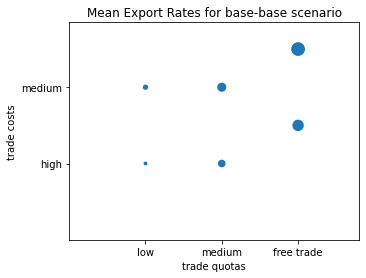

In [299]:
radii = [[0.05, 0.1, 0.15],
        [0.07, 0.12, 0.18]]
plot_circles(radii, 0.95, no_rows = 2, grid = [[(1,1),(2,1),(3,1.5)],[(1,2),(2,2),(3,2.5)]], path = "cir.png")

In [302]:
file1 = open("radii.txt","w")
file1.write(str(radii))
file1.close()